# SUPPORTING PYTHON CODE NOTEBOOK FOR MSc THESIS:
# < The Role of CDS and BONDS in the Price Discovery of Credit Risk > 

#### Thesis Details: 
* **Thesis Title:** The Role of CDS and BONDS in the Price Discovery of Credit Risk
* **University:** Universiteit van Amsterdam (University of Amsterdam) 
* **Program:** MSc Quantitative Finance
    * **Program Year:** 2019-2020
* **Supervisor:** Dr. Tomislav Ladika

######  KEY WORDS 
* Price Discovery, Credit Derivatives, Credit risk, Corporate Bonds, Vector Autoregressions, Vector Error Correction Models

#### Author's Details:
* **Name:** Jason Spano
* **Email Contact:** jason.spano@student.uva.nl


## SUPPORTING CODE NOTEBOOK (#1)
* **NOTE:**  This workbook has been intended as a (mostly pre-executed) stylised method to present the supporting code for the written paper. The majority of the iterations / calculations where done in collaboration across multiple different work environments/notebooks -- this one final notebook is designed to combine all of those multiple work products into one easily-presentable flow
    * The robustness checks section also includes some bonus work conducted as part of research with Dr. Tomislav Ladika and his own paper regarding the CDS-BOND Basis
    
    
* Thesis was approved in October 2020 -- pending publication under UvA open-licencing rules
    * Once released, it will be available via: https://scripties.uba.uva.nl/
    
    
### A NOTE ON FUTURE EXTENSIONS TO THIS RESEARCH 

* As of March, 2021, a collaborative research project is currently being developed to extend the bivariate VECM model with a Markov Switching Autoregressive model for the VIX, combined with some GARCH model variations (E.G. GJR-GARCH / E-GARCH) for forecasting volatility in the CDS/STOCK series. The aim is to test whether incorporating current and forecasted volatility and the current regime level of the VIX into the bivariate VECM (CDS/BONDS) models has any predictive power in forecasting future asset prices; with a particular focus on testing whether 'supposed' the earlier price discovery mechanism of CDS contracts will be able to provide predictive power in this model on future stock prices
    * ETA for completion, Mid-2021. 

### THESIS EXECUTIVE SUMMARY 
* According to financial theory, both CDS and bonds are linked by their relationship in measuring credit risk. Moreover, the theory of no-arbitrage pricing would sugest that both markets price credit risk equally- as reflected by their prices- otherwise, opportunities risk-free arbitrage profits would arise. In practice, there are a multitude of factors which lead to market frictions that can prevent this so-called 'equilibrium' or no-arbitrage state from persisting. 


* The existing body of research, supported by underlying economic theory would suggests that this equilirium state of the two asset prices should be cointegrated. This idea will be tested by utilising a sample size far greater than any previous paper; furthermore, the sample size will be long enough to incorporate both the global financial crisis and the euro-zone crisis. Thus, the dynamics of the CDS-bond relationship can be empirically tested over time.


* This empirical testing will be done by examining if a cointegrating relationship exist between the CDS and BOND for a particular firm. If the presence of this cointegrating relationship is confirmed, a vector error correction model (VECM) will be applied and subsequent price-discovery speed mechanisms (introduced in the relevant section) calculated to determine the underlying dynamics of each series. 

    * Where no cointegration is found, the series can be used to perform a vector autoregression (VAR) and test the causality through a Granger causality test; however, this mechanism is unable to conclude the price discovery or adjustment mechanisms, but will provide an outline of causality through the predictive power of (p) lags on the current price. 

# TABLE OF CONTENTS

### PART ONE - DATA CLEANING & PREPARATION
* [Data Explanations & Overviews](#data_explanations) 
    * [data import from WRDS example](#data_importing_wrds_example)
* [Choice of RFR and importing](#RFR)
* [Firm level ratios importing & re-sampling manipulations](#firm_level_ratios)
* [Applying data restrictions & general data cleaning](#data_restrictions) 

### PART TWO: PECDS & THE BASIS
* [Introducing the Par Equivalent Credit Default Swap (PECDS)](#PECDS)
* [CDS-BOND Basis descriptive statistics and graphical breakdowns](#basis_descriptive_statistics)

### PART THREE: PRE-REGRESSION TESTS (COINTEGRATION & UNIT ROOT TESTING)
* [Augmented Dickey Fuller (ADF) test](#ADF_test)
* [Dickey Fuller Generalised Least Squares (DFGLS) test](#DFGLS_test)
    * [Compare and contrast DFGLS and ADF results](#comparing_ADF_DFGLS)
* [Structural Break / Zivot Andrews Test](#za_test)
    * [Pre-Regressions Stylized Primer Example on a single GVKEY](#pre_reg_primer)
* [Variance Ratio Test](#variance_ratio_test)
* [(Johansen) Cointegration Test](#cointegration_test)

### PART FOUR: REGRESSION MODELS
* [Vector Autoregression (VAR) and Granger Causality Tests](#var_gct_regressions)
* [Vector Error Correction Model (VECM) - FULL SERIES VERSION](#VECM_MODEL_FULL)
* [Price Discovery Measures Results Presentation & Summary](#PRICE_DISCOVERY_RESULTS_FULL)

### PART FIVE: ADDITIONAL ROBUSTNESS TESTING
* [Zivot Andrews Breakpoint Split VECM Model](#za_split_vecm)
    * [Zivot Andrews Split VECM model results & PD measures summaries](#za_split_vecm_results_summary)
* [Price Discovery Measures Segmented by Firm-level Ratios](#PD_measures_firm_ratios)
* [Out of sample VECM model fitting](#oos_vecm_fitting)
* [Omitted Variable Bias Testing](#ovb_analysis)

### APPENDICES 
* [A Stylized Primer Example Of All Econometric/Statistical Tests (+ Graphs) On A Single GVKEY](#appendix_a)
     * An external function which requires an additional import
* [Appendix B: References](#appendix_b)
* [Appendix C: All Firms Compendium - Description of GVKEY to FIRM NAME etc.](#appendix_c)

### IMPORTED PACKAGES

In [1]:
#system packages
import sys
import warnings
import os 
if not sys.warnoptions:
    warnings.filterwarnings("ignore")  

In [2]:
#base packages:
import collections
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats, optimize
from scipy.stats.mstats import winsorize
import datetime
from datetime import date, timedelta

## graphing packages ## 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tabulate import tabulate   ## may require pip install 

In [3]:
#packages for the econometrics / models
import statsmodels.api as sm
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import adfuller, zivot_andrews
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error

## ARCH package may require pip install
from arch.unitroot import DFGLS, ADF, ZivotAndrews, VarianceRatio

#import the functionality for detecting mathematical errors (E.G. types of linear algebra issues etc.)
from statsmodels.tools.sm_exceptions import ValueWarning
from arch.utility.exceptions import (
    InfeasibleTestException,
    InvalidLengthWarning,
    invalid_length_doc)
warnings.filterwarnings("once", category = ValueWarning)

In [4]:
## optional packages / display preferences ##
from IPython.display import display
pd.options.display.max_columns = 60  

## may require pip install 
from see import see                  

### READ IN THE ALREADY PRE-EXECUTED DATAFRAME PICKLE WITH ALL NECESSARY DATA SERIES
* This DF is the final result after merging the results of all the data cleaning, filtering, merging + unit root tests, cointegration tests. It also contains the merged RFR, VIX, and equities data


* Labelled "sorted_alldata_df_final_adf_results" 

* Use this pickle if you wish to test the regression models and skip the unit root testing / data preparation and cleaning phase.

In [5]:
#read pickle if in the same directiory as this notebook:
sorted_alldata_df_final_adf_results = pd.read_pickle("./sorted_alldata_df_final_adf_results.pkl")

<a id='data_explanations'></a>

# Section 1.1) DATA EXPLANATIONS & OVERVIEW
> * NOTE: an academic account to Wharton/Datastream etc. does not grant access to a data API (if one exists). Thus, the only available options are CSV / TXT file imports. 

1) First data section is a raw .txt file (~50GB) of Bond Trades Data, downloaded from Wharton Research/Data Services (WRDS): pertaining to TRACE bond trades for all regular bonds (senior bonds with fixed or zero coupons) issued by firms in Compustat. Observations are at the day-level
    * contains all bond trades between 2002 and June-2017
    * Data included is bond ID, cusip_id, exact trade date/time, traded price, quoted_yield
    
2) Second data section is Bond Maturities information (~2-3GB) - from TRACE as well. Format is .txt file from WRDS, relating to the corresponding data on bond maturities seniority etc.
    * contains bond ID, cusip_id, sub-product type, debt-type, issuer_name, maturity date, grade, convertible_flag, company_symbol
    
3) Third data section is Bond Coupon Rates (~5GB) in  a .txt file from (Mergent FISD), pertaining to coupon information per bond
    * contains: issue_id, coupon_type, offering_date, principal, first_interest_date, interest_frequency, coupon, day_count_basis, last_interest_date
    
4) Fourth data entry is information extracted from Fred, relating to information on swap_rates from one-year through to five-year (the risk-free rate proxy in this report)- all denonted in USD; in addition to values of VIX and other interest rate components

5) Fifth data entry is the trace-mergent linkfile (provides a common factor to merge bond coupon rae information with bond market prices and bond maturities)
    * contains: bond_ID, issue_id, issue_id_fisd
    * This file is necessary to merge together the data about the bonds as WRDS has data on coupons, maturities, prices from different sub-vendors who potentially use different codes/reference numbers. This file will enable us to merge all of the above information on bonds and eventually, with their respective Credit Default Swap (CDS) counterparts. 
    
6) Sixth date entry is CDS spreads (From Datastream) .txt file (~ 40GB) of CDS trades on the same date range as the earlier bond information. Only CDS with standard contractual clauses are considered. Observations are at the day-level
    * contains information on: series_id, gvkey, company_name, stock_ticker, source, duration, clause, currency, class_type, date, cds_spread
    
7) (By earlier filtered viable GVKEY sub-sample) Equivalent Equity trading data (Daily) from WRDS/Compustat (CSV ~1GB)
    * Includes: open, high, low, close, trading_volume, market status indicators

8) (By earlier filtered viable GVKEY sub-sample)(Data is monthly/quarterly level) of: Firm-level ratios (~1-2GB)
    * pertaining to: EPS, debt/capital ratios, profitability ratios, R&D etc.
    
9) Equity Sector Data & Returns (Daily-level) from WRDS/Compustat     

10) (EXTENSION DATA) (By earlier filtered viable GVKEY sub-sample) detailed breakdown of opening, high, low, closing bond-trades data
    * Contains measures that would make it possible to statistically determine bond market liquidity 


#### SIDENOTE: Additional robustness checks will be performed on the same data but re-sampled by weekly/monthly - these DFs will be based off the final DF which includes the merging of all the above dataframes labelled "sorted_alldata_df_final_adf_results " and included in the GIT repository as a pickle file. The weekly re-sample will re-sample the data from Wednesday-To-Wednesday for observations
* Provided that the regressions on the different sampling periods is virtually identical, this repetitive code has been omitted from this stylized example notebook

<a id='data_importing_wrds_example'></a>

## EXAMPLE OF DATA IMPORT OF BOND TRADING DATA
* Data is (.txt) format (restriction of educational account from Wharton data services)
* Initial range is all bond trades on the US exchanges from 2006-2017 (Roughly a decade of data)
    * Data source is WRDS (Wharton)

* NOTE: only the price is required from this, as the equivalent "yield" will be formulated through another mathematical procedure "par equivalent credit default swap (PECDS)" as the raw yield here is not directly comparable with CDS spreads


* Given data will be collapsed to the daily-level (one trade per bond, per day) - thus, the trade_time variable is not needed. However, it could be incorporated if some intraday trading phenomena became part of the analysis in future studies. 


* Variables definitions: 
    * bond_sym_id == the "ticker" of the bond instrument
    * date == date the trade took place
    * trade_time == the exact time / date
    * quantity == the volume (amount of bonds) traded at that respective trade_time / date
    * price == price paid per bond
    * _yield == simple reported yield (quoted yield / price)
    


In [ ]:
#BOND DATA: DATA_FILE_#1

#read the file (adjust the local directory if necessary)
bond_file = open('sample_bond_data_all.txt','r')      

#initalise a dictionary to write to
bonds_date_price = {}                                           

#for each line, strip the whitespace characters [new line, return key etc.]
for line in bond_file:  
  line = line.rstrip("\r\n")  
  
  #for each variable [bond_sym_id, date etc.] split on the [tab] space   
  [bond_sym_id, date, trade_time, quantity, price, _yield] = line.split("\t")    
   
  if bond_sym_id=="bond_sym_id" and date=='date':               
    continue
    
  #try to update the initial dictionary with the respective bond, for each date, with the traded price for that time  
  #note: (value error was rarely- that is, (less than) 25 instances encountered, usually missing or corrupted data points)  
    
  try:
      bonds_date_price[(date, bond_sym_id)] = price
  except ValueError as ve:
    print("ValueError: Row: {}, Reason : {} ".format(line, ve))   
    ## subsequent iterations, substitute in the "pass" argument and apply subsequent checks to rectify missing/corrupt data
    
    
#construct the final DF with the necessary items, label the columns    
bonds_date_price_df = pd.DataFrame(list(bonds_date_price.items()), columns=['date','date_id_price'])

#close the file
bond_file.close()

In [ ]:
#Create a datetime object for later merging this data with the relevant swap_rates / other data
#this is because the date column imported is not yet recognised as date format in Python: 

format_date = '%Y%m%d'                                                                
datetime_obj = bonds_date_price_df['trade_date'].apply(lambda x: datetime.datetime.strptime(x, format_date))
#NOTE: American style date

## FURTHER DATA IMPORTS FOLLOW THE SAME STRUCTURE
* Thus, the code has been omitted as without access to the original files the code is largely useless. Naturally, the final pickled-DF is available in GitHub. 

### OTHER IMPORTED FILES ARE: 
* The Master File (Bond Sym ID, Bond Maturities, Debt Type, Issuer, Grade, Contractural Clauses etc.)
* The Coupon File (CDS) (ID, coupon type, offering data, first interest date, interest frequency, day count basis etc.)
* The Trace Mergent Linkfile - linking bonds and CDS by ID
* The CDS spread File (GVKEY, clause, class type, date, currency, cds spread etc.)



<a id='RFR'></a>

## Risk Free Rate (RFR) 
* As numerous studies have pointed out, one prominent example being "An Empirical Analysis of the Dynamic Relation between Investment‐Grade Bonds and Credit Default Swaps" by (Blanco, Brennan, & Marsh, 2005) government bonds are no longer the ideal RFR proxy due to a host of factors: taxation effects, repo market activity, scarcity premia. 
* The selected RFR proxy is 5-Year USD denominated swap rate, acquired from St. Louis Fred
    * https://fred.stlouisfed.org/
    
* Due to the vendor changing their internal data structure, constructing a continuous RFR for the entire sample period in this paper required stitching together their legacy series for swap rates with the new ICE swap rate. 


In [8]:
## find the first and last trade-date in the subsample
sorted_alldata_df_final_adf_results['trade_date'].min()

Timestamp('2006-07-03 00:00:00')

In [9]:
## last (max) date in the DF
sorted_alldata_df_final_adf_results['trade_date'].max()

Timestamp('2017-06-30 00:00:00')

In [25]:
## pre-format date with 
firstobs = date(2006, 7, 3)
lastobs = date(2017, 6, 30)
time_horizon = lastobs - firstobs
print(" TIME HORIZON (DAYS): {}".format(time_horizon.days), '\n', 
     "TIME HORIZON (YEARS): {}".format(time_horizon.days / 365))

 TIME HORIZON (DAYS): 4015 
 TIME HORIZON (YEARS): 11.0


#### IMPORTING & CONCATENING THE SWAP RATES
* Use the API from FRED
* NOTE: the api_key has been censored

In [5]:
## API 
from fredapi import Fred

## note -- my api key has been censored. It is free to sign up for a FRED api key from the website linked above.
fred = Fred(api_key='################################')

In [ ]:
## discontinued 5Y Swaprate (Discontinued in 2016) however, ICE swap rates commence from 2014
## Hence, ICE swap rates are used from the first available point
discon_1y_swaprate = fred.get_series('DSWP1',firstobs,'2014-07-31')
discon_2y_swaprate = fred.get_series('DSWP2',firstobs,'2014-07-31')
discon_3y_swaprate = fred.get_series('DSWP3',firstobs,'2014-07-31')
discon_4y_swaprate = fred.get_series('DSWP4',firstobs,'2014-07-31')
discon_5y_swaprate = fred.get_series('DSWP5',firstobs,'2014-07-31')

## ICE Swap rates: From (2014-08-01) to present
ice_1y_swaprate = fred.get_series('ICERATES1100USD1Y','2014-08-01',lastobs)
ice_2y_swaprate = fred.get_series('ICERATES1100USD2Y','2014-08-01',lastobs)
ice_3y_swaprate = fred.get_series("ICERATES1100USD3Y",'2014-08-01',lastobs)
ice_4y_swaprate = fred.get_series('ICERATES1100USD4Y','2014-08-01',lastobs)
ice_5y_swaprate = fred.get_series('ICERATES1100USD5Y','2014-08-01',lastobs)

In [ ]:
#combine each tenor (1:5Y) into a single series
oneyear_swaprate = pd.concat([discon_1y_swaprate, ice_1y_swaprate],axis=0)
twoyear_swaprate = pd.concat([discon_2y_swaprate, ice_2y_swaprate],axis=0)
threeyear_swaprate = pd.concat([discon_3y_swaprate, ice_3y_swaprate],axis=0)
fouryear_swaprate = pd.concat([discon_4y_swaprate, ice_4y_swaprate],axis=0)
fiveyear_swaprate = pd.concat([discon_5y_swaprate, ice_5y_swaprate],axis=0)

In [ ]:
#combine into final DF containing the entire series of each tenor of swaprate
swap_rates_concat = pd.concat([oneyear_swaprate, twoyear_swaprate, threeyear_swaprate, 
                               fouryear_swaprate, fiveyear_swaprate], axis=1)

swap_rates_df = pd.DataFrame(swap_rates_concat.values, 
                             index=oneyear_swaprate.index, 
                             columns=['1Y_SR','2Y_SR','3Y_SR','4Y_SR','5Y_SR'])

## while FRED data is highly reliable, it is still recommended to check the resulting frame for any abnormalities E.G. 
print(swap_rates_df.index.duplicated().any())

## for each series, check if there are any duplications / a reasonable amount of nulls (52 * weekends (104)) annually
print(swap_rates_df.isnull().any())

### LINEAR INTERPOLATION OF THE RFRs
* The imposed limit is (5); meaning any consecutive break in the swap series greater than (5) will not be interpolated. This is roughly equivalent to there being an entire week missing.
* However, FRED data is reliable and there were no instances of large breaks in the data.

In [ ]:
#method = linear; consecutive NaN(s) are filled forward (interpolation occurs down the columns by default (axis=1) )
fulldata_df[['riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr', 'riskfree_rate_4yr', 'riskfree_rate_5yr']] = 
fulldata_df[['riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr', 'riskfree_rate_4yr', 
             'riskfree_rate_5yr']].interpolate(method='linear', limit=5, limit_direction='forward')

## VIX / TED SPREAD 
* VIX SPREAD:
    * an implied volatility index that measures the market's expectation of the S&P 500's 30-day volatility implicit in the prices of short-term S&P options
* Ted Spread:
    * The difference between the 3m Treasury Bill and the 3M LIBOR (denominated in US dollars) -- occassionally used as a proxy for the price of money / perceived risk of the finanl system in the past
        * Another way of viewing it is to say the TED spread is the difference between the interest rate on short-term US government debt and the interest rate on loans between banks
        
        
* SOURCE: https://fred.stlouisfed.org/

In [ ]:
#VIX series
cboe_vix = fred.get_series('VIXCLS', firstobs, lastobs)

#TEDRATE
ted_rate = fred.get_series('TEDRATE', firstobs, lastobs)

#concatenate the two series column-wise
int_spreads_concat = pd.concat([cboe_vix, ted_rate],axis=1)

#convert to a dataframe
interest_spreads_df = pd.DataFrame(int_spreads_concat.values, 
                                   index=cboe_vix.index,
                                  columns=['cboe_vix','ted_rate'])

#interpolate the DF (linearly) any missing values in the: VIX or TED rates
interest_spreads_df[['cboe_vix','ted_rate']] = interest_spreads_df[['cboe_vix','ted_rate']].interpolate(
    method='linear',limit_direction='forward')

In [ ]:
#reset the index of the DF so that the trade-date becomes a seperate column (to allow merging onto the main bond/cds DF)
interest_spreads_df = interest_spreads_df.reset_index()

#rename the relevant columns to allow a common merge:
interest_spreads_df = interest_spreads_df.rename(columns={'index':'trade_date'})

# check both series for NaN(s) before proceeding to the merge
interest_spreads_df.isna().sum()

## the date column may need to have its dtype reformatted to match the original DF 

### Merge this DF onto the main dateframe with the firm-level data
* set the main-DF as the principal DF, such that a left merge on trade-date will only keep the relevant dates for each firm
* that is, E.G. if Firm(X) has data from 2010:2014, only the interest_spreads from 2010:2014 will be affixed for this firm 

In [ ]:
#E.G. of the left merge on trade_date: 
sorted_alldata_df_final_adf_results = sorted_alldata_df_final_adf_results.merge(
    interest_spreads_df, how='left', on='trade_date')

<a id='firm_level_ratios'></a>

# DATAFRAME (#8) - FIRM LEVEL RATIOS
#### E.G. of ratios contained within & outlining what the Wharton abreviations actually represent: 

* #bm = book/market
* #pe_inc = P/E (Diluted, Incl. EI)
* #ps = price/sales
* #p/cf = Price/Cash flow	
* #npm = net profit margin
* #roe = return on equity 
* #Gprof = Gross profit / Total Assets
* #Capital_ratio = Capitalization ratio
* #fcf_ocf = Free Cash Flow/Operating Cash Flow
* #de_ratio = Total Debt/Equity
* #curr_ratio = current ratio 
* #rd_sale = Research and Development/Sales
* #ptb = price to book
* #divyield = dividend yield 

#### NOTE: due to the inherently different nature of the included firms, it is expected that there will be (Null) values in each ratio per firm, E.G. not all firms will pay a dividend and thus dividend_yield will be 0.

In [ ]:
firm_level_ratios = 'firm_level_ratios_gvkey.csv'
firm_level_ratio_df = pd.read_csv(firm_level_ratios)

In [ ]:
#because of the .CSV file, the dtypes won't be compatible with the existing pandas-based DF
#principally, the date series (for merging onto the main DF) will need to be converted to datetime from string

#convert the float64 column to datetime
#in Wharton: the series for which the ratio was released as public information is referred to as 'public_date'
firm_level_ratios_dtime = pd.to_datetime(firm_level_ratio_df['public_date'], format='%Y%m%d', errors='coerce')

#rename this column to match 'trade_date' so it can be merged 
firm_level_ratios_dtime = firm_level_ratios_dtime.rename(columns={"public_date": "trade_date"})

## Overcoming a major issue: different frequencies of reporting, as ratios per firm are reported either monthly, or quarterly:
* Need to devise a method to interpolate the values between these two points in time and transform it to daily-level values so some series can later be used in the various models, E.G. Vector Autoregressions 
* Also, need to make sure the method cuts the time periods correctly for each firm-combination, as virtually every firm-combination has a unique set of start and finish dates for its CDS/BOND data series: both for accuracy and to reduce computation strain 

In [ ]:
#also noted that we will need to merge by [GVKEY, DATE] now and thus GVKEY needs to be converted from (object) type
firm_level_ratios_dtime['gvkey'] = firm_level_ratios_dtime['gvkey'].astype(np.int)

In [ ]:
#create a seperate date column which is just the month:year and leave the daily-level series unaffected
firm_level_ratios_dtime['trade_date_month'] = firm_level_ratios_dtime['trade_date']

#convert to date-time, the level of the ratios data is at minimum (month:year)
firm_level_ratios_dtime['trade_date_month'] = pd.to_datetime(firm_level_ratios_dtime['trade_date_month'], format='%Y-%m')

#create a pivot-tabel of those value-series deemed relevant for the later regression models
df_firm_ratios_mini = firm_level_ratios_dtime.pivot(index='trade_date_month', columns='gvkey',
                                                     values=['ps','pcf','GProf','capital_ratio','de_ratio','rd_sale'])

## now, create the offsets for the DF's dates: 
## note: "trade_date_month" is now the index column from the .pivot method above
start_date = df_firm_ratios_mini.index.min() - pd.DateOffset(day=1)    
end_date = df_firm_ratios_mini.index.max() + pd.DateOffset(day=31)

## fill in the 'date range' from start to end with a daily (D) frequency
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'

#ffill will pad the values in-between the two dates to create a continuous flow E.G. January 1, 2,... 31st etc.
pivot_df_firm_ratios_mini = df_firm_ratios_mini.reindex(dates, method='ffill') 

In [ ]:
#now, need to rearrange the pivot-DF back to a regular format by stacking the DF on the GVKEY
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.stack('gvkey')

#sort the DF, so that each GVKEY is sorted chronologically
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.sort_index()

#reset the index, so that this chronologically sorted date-series is now treated as a column within the DF (for easier merging)
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.reset_index()

### [optional]  MERGE THE FIRM EQUITY DATE ONTO THE MAIN DATAFRAME 
* If speed/memory constraints are a concern, the other recommended method would be to pickle this particular DF and call it when the need arises with the pd.read_pickle method.
* Both code snippets are presented below

In [ ]:
#now, the final merge to re-affix the now converted/padded values of firm-level ratios on a daily level to the main DF
#optional to rename DF to modified version, e.g. fulldata_df_ratios to confirm the ratios are correctly formatted now
fulldata_df = fulldata_df.merge(pivot_df_firm_ratios_mini, how='left', on=['gvkey','trade_date'])

In [ ]:
#Optional: create a pickle of the firm equity data (will be stored in the local directory of your .ipynb file) 

pivot_df_firm_ratios_mini.to_pickle("./pivot_df_firm_ratios_mini.pkl")
#pivot_df_firm_ratios_mini = pd.read_pickle("./pivot_df_firm_ratios_mini.pkl")  

### [optional] TIME RESAMPLING & INTERPOLATION OF MISSING RATIO DATA
* Some interpolation can be performed to fill in some intermittent instances of missing ratio data.
    * The optimal limit imposed is largely dependent on the research being performed, but for weekly data, a limit of (4) roughly equivalent to one month is imposed in this paper
* In the main paper, the weekly level data and associated regression results are included as a part of the robustness process. The entire process is omitted from this workbook due to it being both very long and the code being almost identical for the most part. 
    * The below code would be the precursor to having an identical DF equivalent to the 'sorted_alldata_df_final_adf_results' but in weekly format, from which the remainder of the regression tests could be applied in the same manner as the daily-level DF

In [ ]:
## resample from wednesday to wednesday on the first instance of 'trade_date'
fulldata_df_weekly = sorted_alldata_df_final_adf_results.groupby('gvkey').resample('W-WED', on='trade_date').first()

# will result in a multi-level index
# personal preference to reset index to move ['GVKEY','trade_date'] back to the columns

In [ ]:
#An example of: interpolating the price  to sales ratio per GVKEY group 
fulldata_df_weekly = fulldata_df_weekly.groupby(['gvkey','price_sales']).apply(
    lambda g: g.interpolate(method='linear',limit_direction='forward', limit=4, axis=0))

#if this were for [weekly data]: limit == 4 would exclude the interpolation of any series with a structural break >1m time

## depending on which ratios are needed, repeat this process for other ratios

# DATAFRAME (#9) DAILY EQUITY PRICES / TRADING INDICATORS
* Again, from Wharton services

* DVRATED -- Indicated Annual Dividend Rate - Daily
* curcdd = CURCDD -- ISO Currency Code - Daily
* cshoc = CSHOC -- Shares Outstanding
* cshtrd = CSHTRD -- Trading Volume - Daily
* eps = EPS -- Current EPS
* prccd = PRCCD -- Price - Close - Daily
* prchd = PRCHD -- Price - High - Daily
* prcld = PRCLD -- Price - Low - Daily
* prcod = PRCOD -- Price - Open - Daily
* exchg = Stock Exchange Code: 
    * (19) = other-OTC US, 12 = Amaerican, 14 = NASDAQ, 11 = NYSE
* secstat = Security Status Market	 I = inactive, A= active
* costat = COSTAT -- Active/Inactive Status Marker

### GSUBIND -- GIC Sub-Industries
* Global Industry Classification Standard (GICS). The Sub-industry is represented by all 8 digits of the total GICS code.

* idbflag = IDBFLAG -- International, Domestic, Both Indicator (B = North-America & Int, D = domestic (NA), I = int)
* spicindcd = SPCINDCD -- S&P Industry Sector Code

In [ ]:
## read in the CSV file of firm ratios/trade data
daily_us_equity_prices = 'gvkey_daily_usa_equity_prices.csv'
daily_us_equity_prices_df = pd.read_csv(daily_us_equity_prices)

## FILTERING THE DATA
* Keep only the first observation for each day
    * NOTE: the last, or some other frequency is also a valid filter to apply. None are generally regarded as superior to another and especially not when looking over long horizons. 

In [ ]:
## keep only the first observaiton per GVKEY per day in the sample
daily_us_equity_prices_df = daily_us_equity_prices_df.drop_duplicates(subset=['gvkey','trade_date'], keep='first')

<a id='data_restrictions'></a>


# TIME RESTRICTING / FILTERING THE DATA

* I dropped all bonds with missing or negative prices (assume this is an error in the data on the vendor's end as it is implausible to have a negatively priced bond); repeated this step with other important data points, such as: missing coupon rates or maturity dates. 
    * Out of 10M + total observations, only a few thousand were dropped in this manner so the data integrity as whole is sound. 
    * Around 10% of the bonds have no data on interest_frequency (frequency of the coupon payments, usually semi-annual for most fixed-rate bonds); this issue is elaborated on more in one of the next steps


* Multiple approaches in merging, I believe a fairly simple method is to perform an outer-join on the BOND & CDS data frames; thus, potentially there will be some observations with bond prices and no CDS spreads, and vice-versa. However, quickly dropping the NaN from the DF will resolve this, resulting in a DF with just the overlapping firms with both CDS and BOND data. 


## FILTER THE DF BY MATURITIES ON THE CDS/BOND SERIES. 
* Restrict the aggregate DF to only those firms with both a CDS:Bond trading between 4-6 years
* First, calculate the time gap between date traded (From the original bond trade file) and the maturity date by bond_ID (from the 2nd data entry file on bond maturities)- to filter the DF to only those observatios beteen four and six years

In [ ]:
#Convert the maturity date column to more workable datetime format for the later date(1) - date(2) calculation 
fulldata_df['maturity_date'] = pd.to_datetime(fulldata_df['maturity_date'], format="%Y%m%d", errors='coerce')

#Extract the existing dates within the index as seperate column to simplify the subsequent calculation
fulldata_df['time_dif'] = ((fulldata_df['maturity_date'] - fulldata_df['trade_date']))

In [ ]:
#filter sample to keep only observations for which both a CDS-Bond combination exist with maturities between 4-6 years

#pre-create the variables to hold the date limits (note, 1Y == 365.25 days)
fouryear_timedelta = timedelta(days=(365.25 * 4))
sixyear_timedelta = timedelta(days=(365.25 * 6))

#first, restrict to only maturities less than 6 years
fulldata_df = fulldata_df[fulldata_df['time_dif'] < pd.Timedelta(sixyear_timedelta, unit='d')]

#further filter to only those maturities greater than 4 years; resulting in a range of 4-6Y
fulldata_df = fulldata_df[fulldata_df['time_dif'] > pd.Timedelta(fouryear_timedelta, unit='d')]

In [ ]:
## improve the readability of the dataframe above by converting the days to years
## the '.fillna' will: fill NaN or missing values with 0 days
fulldata_df['time_dif'] = (fulldata_df['time_dif'] / np.timedelta64(1, 'Y')).fillna(pd.Timedelta('0 Days'))

#optional but recommended: round the large float value for a more compact, readable DF
fulldata_df['time_dif'] = np.round(fulldata_df['time_dif'], 3)

### Inspecting a DF of the NaN / Missing values revealed that there were a few corrupted data points with {} in place of the data
* There were 31 instances of corrupted data points

In [ ]:
#find all the occurences of the corrupted data points with: {} instead of price (#NO = 31)
corrupted_price_df = fulldata_df[fulldata_df.price.str.contains('\{}')==True]

#send the index numbers to a list
corrupted_indexes = corrupted_price_df.index.tolist()

#find the loc of these indexs so faciliate dropping them from the DF 
corrupted_indexloc = []
for i in corrupted_indexes:
    corrupted_indexloc.append(fulldata_df.index.get_loc(i))
    

In [ ]:
#drop all of the rows with the corrupted {} in place of the price for the entire DF: based off their index.loc list above
fulldata_df = fulldata_df.drop(fulldata_df.index[corrupted_indexloc], axis=0)

## RECTIFYING NON-CHRONOLOGICALLY SORTED DATA

* Some data appears to have become jumbled in the sorting, as the index was set to an arbitrary counter (1, 2...., 450K etc.) 
* The problem is that the data associated with an index number of (E.G. 451434) is actually occuring before a data point associated with an index number of (E.G. 99866). Thus, resulting in some intermittent sections of sorted data with chunks of un-sorted sections

    * This is potentially an issue with how the vendor indexes data relative to python's base interpretation
    * Could also be a product of merging multiple data sources from different sources
    * E.G. screenshot below

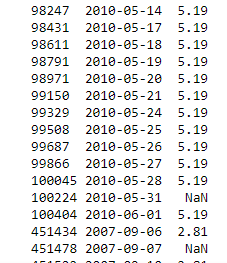

In [ ]:
#re-organise the DF by (GVKEY) and then sort chronologically on the trade_date
sorted_alldata_df_final_adf_results = sorted_alldata_df_final_adf_results.set_index(['gvkey','trade_date']).sort_index()

#reset the index to move GVKEY and trade_date back to regular columns, while preserving the now chronologically sorted format
sorted_alldata_df_final_adf_results = sorted_alldata_df_final_adf_results.reset_index()

# Conclusion on the data cleaning process: 
* After applying the above data preparation process:
    * Filter by 4-6Y maturities
    * Keep only CDS that have corresponding bond data + bond coupon data (else PECDS cannot be calculated)
    * Dropping corrupted data points / NaNs / Duplicated indexes etc.


* The result is roughly 408 firms with outstanding CDS contrats, bonds which mature in 4-6 years, as well as have information available on the bonds coupons
    * Roughly equivalent to 5-6m total data ponts across the 408 total GVKEYs
    * These GVKEYs are now valid firms to have the PECDS methodology applied to 

<a id='PECDS'></a>

# PART TWO: Calculating Par-Equivalent Credit Default Swap (PECDS) 

* This is a technique used to be able to compare bond spreads (even those trading far from par) with their equivalent CDS contracts
    * Originally developed by JP & Morgan's Credit Derivatives Research Division: 
        * Elizalde, Abel, Doctor, S., & Saltuk, Y. (2009). Bond-CDS Basis Handbook: Measuring, Trading, and Analysing Basis Trades. J.P. Morgan Credit Derivatives Research.

> ###  A brief primer on the underlying mechanics and mathematics of PECDS


 $$ PRICE(BOND) = c \sum_{i=1}^n \delta_{t,i} e^{-\lambda{ti}} D(t_{i}) + FV e^{-\lambda{t,n}} D + RR \sum_{t=1}^n e^{-\lambda(t_{i-1} - t{i})} D(t_{i}) $$
 
* This is the formula for the market price of the bond. All of the necessary elements are: observable (E.G. coupon rate), or assumed to be constant (E.G. recovery rate is almost always (1-0.4). Thus, the only remaining unknown is the the lambda (hazard rate), denoted as:  $\lambda$

* For clarity, the components in the above formula are:
    * $C$ is the coupon rate
    * $\delta$ (delta) represents the day count convention between $t_{i-1}$ and $t_{i}$ 
    * $ D(t_{i})$ is the chosen proxy for the RFR
    * $FV$ term stands for face value of the bond- always 100. 
    * $RR$ stands for the recovery rate (virtually always chosen to be (1 - 0.4) in practice
    * The subscript of $n$ attached to $\lambda$<sub>n</sub> represents the remaining coupon periods

* The default mechanism in the PECDS framework is modelled as Poisson process, meaning that if the bond has not defaulted at the beginning of the year, the subsequent probability of default in the next year is: $1 - \exp^{\lambda(ti)}$

* Accordingly, once the hazard rate is calculated (requires optimisation to find the root of the expression due to non-linear components), the PECDS is calculated as follows:

$$ PECDS = \frac{(1 - RR) \sum_{i=1}^n e^{-\lambda_(t_{i-1} - t_{i})} D(t_{i}) } { \sum_{i=1}^n \delta_{t, i} e^{-\lambda{i}} D(t_{i}) + \sum_{i=1}^n \frac{\delta_{t, i}}{2} e^{-\lambda_(t_{i-1} - t_{i})} D(t_{i})  } $$

* In this formula, the numerator is the CDS's contingent payment in default. This expected value is further contingent on the given recovery rate assumption, as well as the probability of default in the respective year, all discounted by the appropriate RFR. 


* the denominator is the CDS spread payments which occur so long as the underlying bond has not defaulted. The expected value of these spread payments is again contingent on default probabilities discounted by the respective years.


* Thus, the value of the spread payments and the value of the default contingent payment must be equal at inception. Put simply, an investor buying the CDS must at least expect to breakeven in expected value

### There are some restrictive assumptions to what data can have a mathematically valid PECDS - refer to the write-up report for a full breakdown

#### Initial Class Function:


* NOTE: the "hypothetical_bond_price" returned from this function, is the hypothetically implied price of the bond if the initial (starting value guessed) hazard rate (AKA default rate) were indeed the true hazard rate being used in the market Obviously, this is not the case, but the subsequent function will 'optimise' this process to return the true hazard rate and subsequently, be able to calculate the PECDS.

* Furthermore, given that the initial guess is not actually the true hazard rate, the hypothetical bond price variable in itself has no meaning until the subsequent function which re-optimises the entire processs with the newly solved hazard rate. 

* NOTE: the divison by 100 in the "def__init__(self...)" is a nothing more than converting formats from the online data vendor. E.G. 4.75% should be divided by 100 to be read correctly as 0.0475.

In [ ]:
class lambda_exp_solver:
    def __init__(self, coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, 
                 riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr):
        self.coupon = float(coupon) / 100                             
        self.interest_frequency = int(float(interest_frequency))      # must be read in as (int(float( )) to avoid error
        self.maturity = float(years_to_maturity)                           
        self.price = float(price)                                  
        self.riskfree_rate_1yr = float(riskfree_rate_1yr) / 100
        self.riskfree_rate_2yr = float(riskfree_rate_2yr) / 100
        self.riskfree_rate_3yr = float(riskfree_rate_3yr) / 100
        self.riskfree_rate_4yr = float(riskfree_rate_4yr) / 100
        self.riskfree_rate_5yr = float(riskfree_rate_5yr) / 100     
        #note: the division by /100 is a feature of the data from WRDS (where 4.75 is == 4.75% but in python should = 0.0475)
        
    #formulate function for expected (present value) of bond- as a function of the numerically optimised hazard_rate (lambda)
    def lambda_bond_price_equation(self, hazard_r):
        
        #initialise variables for bond pricing
        pv_coupon_payments = 0    
        pv_bond_repayment_default = 0     
        pv_bond_repayment_no_default = 0          
        
        #initalise fixed parameters: the floating is simply for consistency if debugging is required: 
        principal = float(100)                                       #bonds quoted on basis of principal == $100
        recovery_rate = float(0.4)                                   #equivalent to 0.4 == (1 - RR)
        
        #initialise the class function's self.params
        maturity = self.maturity
        coupon_frequency = self.interest_frequency                  
        coupon_r = self.coupon
        price = self.price                                           
        riskfree_rate_1yr = self.riskfree_rate_1yr
        riskfree_rate_2yr = self.riskfree_rate_2yr
        riskfree_rate_3yr = self.riskfree_rate_3yr
        riskfree_rate_4yr = self.riskfree_rate_4yr
        riskfree_rate_5yr = self.riskfree_rate_5yr
        
        #initialise the risk-free rates as if they were 'one' series, to allow the correct year reference for discounting cash flows
        risk_free_rates_series = pd.Series([riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr])
        
        #calculate No. Years where bond makes a payment: math.ceil = returns smallest integral value greater than the passed in number
        total_payment_years = math.ceil(maturity)
        
        #for coupon bonds-- derive the number of coupon payments that will be made in its final year
        if ( coupon_frequency > 0):
            
            ## Start by calculating duration of final year (as a fraction of the total year). 
            duration_final_year = maturity - math.floor(maturity)
            
            ## Next calculate duration between each coupon payment (this equals 0.5 for semi-annual coupon bonds)
            duration_between_payments = 1/coupon_frequency
            
            ## Start by setting the number of payments in the final year to 1, since each bond pays a coupon on its maturity date (so as long as the bond matures in year 5, at least one payment is made then)
            number_coupons_final_year = 1
            
            ## Next shorten duration of final year by time period between coupon payments 
            remaining_duration_final_year =  duration_between_payments - duration_final_year
            
            #assuming the math.ceil(mat) means 3.8 >> 4.0; this should ensure the remaining duration is always positive for that 1/2 year's worth of coupon
            
            ## As long as this remaining duration is positive, increment number of coupon payments
            while (remaining_duration_final_year > 0):
                number_coupons_final_year += 1 
                
                #this loop segment handles any issue with negative (remaining_duratuin_final_year):if 5.1 == (0.1 - 0.5) = -0.4
                if (duration_final_year <= 0.5):
                     remaining_duration_final_year = duration_final_year - duration_final_year #should cancel out the while loop when the if-clause hits this
                elif (duration_final_year > 0.5):        
                    remaining_duration_final_year = duration_final_year - duration_between_payments 
        
        #formula for pricing the bond, as a function of the hazard_rate (lambda) 
        for i in range(1 ,total_payment_years+1):                  
                
            ## Obtain risk free rate corresponding to year of bond payment
            # The try/except format is to counter a "key error" occuring with some bonds nearing 6Y maturities - this is resolved by reverting the reference for maturities > 5Y to the 5Y swap rate
            try:
                risk_free_rate = risk_free_rates_series[i]
            except KeyError:
                risk_free_rate = risk_free_rates_series[4]  
                #note: in python, reference loc[4] is actually referring to the (5 year) swap rate - not the 4th
            
            ## Calculate the number of coupons paid during the payment year. In all but the final payment year, this is equal to the standard number of coupons per year.
            if ( i < total_payment_years):            
                number_coupons_in_payment_year = coupon_frequency
            elif ( i == total_payment_years):
                try:
                    number_coupons_in_payment_year = number_coupons_final_year
                except UnboundLocalError:            #occurs with zero-coupon bonds; simply fix zero-coupon bonds to have just one coupon (only the final year)
                    #This resolves the issue with zero-coupon bonds, as this variable is not defined for coupon_freq <= 0 (loop above)
                    number_coupons_final_year = 1
            
            ## Next increment expected present values of coupon payments (with t denoting the payment number within the year, always starting at 1)
            ## this is because most bonds pay semi-annual coupons (a select few pay quarterly, but the code will handle either without further changes)
            t = 1
            
            ## In each year, iterate over the number of coupon payments in that year
            ## Note that this loop will be skipped over for zero-coupon bonds, which have coupon_frequency of 0
            while ( t <= number_coupons_in_payment_year):
                
                ## Add present value of coupon payment, with hazard rate and risk-free rate multiplied by year i (since only discounting once per year)
                pv_coupon_payments += (np.exp(- (hazard_r) * i )) * coupon_r * principal * np.exp(-(risk_free_rate * i))
                
                ## Increment counter for number of coupon payments
                t+= 1
                
            ## Increment expected present value of bond recovery payment in case of default in each year i. Note this value is incremented only once per year.
            pv_bond_repayment_default += recovery_rate * principal * np.exp(-risk_free_rate * i) * ( np.exp(-hazard_r * (i-1)) - np.exp(-hazard_r * i) ) 

            ## Increment expected present value of bond principal repayment in case of no default in final year. 
            ## Note this value is incremented only once (as there can only be one 'final' payoff obviously)
            if ( i == total_payment_years):                              
                pv_bond_repayment_no_default += np.exp(-hazard_r * i) * principal * np.exp(-risk_free_rate * i)                  
                
        ## After looping over all payment years, calculate expected present value of bond          
        hypothetical_bond_price = pv_coupon_payments + pv_bond_repayment_default - pv_bond_repayment_no_default       
    
        ## Return total expected present value
        return hypothetical_bond_price
    
    #the above (lambda_bond_price_equation) function can now be numerically solved by np.optimize
    #this will yield the necessary hazard rate (implied by the market prices/variables) which would set the bond's value to par ($100)
    def solve_for_lambda(self):                                     
        optimised_lambda = optimize.fsolve(self.lambda_bond_price_equation, x0 = 0.05) 
        #note: x0 = initial starting guess parameter.
        #not particularly important as the updated x0 will be the previous function's value anyhow, but 5-10% is a safe initial choice
        return optimised_lambda[0]

### Multiple methods for applying the above function to the Bond/CDS dataframe
* This code has since been updated to use pandas within a DF, however, originally the code could not be made to work with iteratively applying the scipy.optimise function which has multiple iterative references. As this step only had to be performed once, the one off long computation was not overly restrictive. It has been left here as a legacy.


In [ ]:
reader_df_txt = open('final_df_cleaned_txt.txt','r')         #read the main DF(data) file
output_df_txt = open('output_df_v2_01.txt','w+')             #Create a file called () or write to it if it already exists (w+)

initial_hr = 0.075                                           #starting guess for solver 

for line in reader_df_txt:                            
    line = line.rstrip("\r\n")
    [bond_sym_id, trade_date, price, issue_id, bond_in_mergent,
       coupon, interest_frequency, coupon_type, maturity_date,
       secured, seniority, years_to_maturity, gvkey,
       riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr,
       riskfree_rate_4yr, riskfree_rate_5yr, cds_spread, series_id] = line.split()    # ("\t") tab space(not how my data is formatted)
    if bond_sym_id=="bond_sym_id":
        print('bond_sym_id', 'trade_date', 'price', 'issue_id', 'bond_in_mergent',
       'coupon', 'interest_frequency', 'coupon_type', 'maturity_date',
       'secured', 'seniority', 'years_to_maturity', 'gvkey',
       'riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr',
       'riskfree_rate_4yr', 'riskfree_rate_5yr', 'cds_spread', 'series_id', sep="\t", end="\n", file=output_df_txt)
        continue
    if (interest_frequency =="nan"):                                        #if I_FREQ = NAN >> assume == zero coupon bond ()
        interest_frequency = int(0)

    ## These should have already been filtered but for completeness    
    if (bond_sym_id=="" or bond_sym_id=="{}" or bond_sym_id=="NA"):          
        init_bondprice = "NA"
        init_solved_lam = "NA"
    
    ## initialise the code for solving the non-linear equation, returning the lambda rate
    else:
        lambda_exp_solver_instance = lambda_exp_solver(coupon, interest_frequency, years_to_maturity, 
            price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr)
        
        #initial_hr == 0.075 as defined at the beginning of this cell (as only needs to be initialised once)
        
        init_bondprice = lambda_exp_solver_instance.lam_exp_4(initial_hr)
        
        init_solved_lam = lambda_exp_solver_instance.solve_for_lambda()
        
        ## update the initial starting guess using solved value from T-1
        ## otherwise, it would reset to X0 = 7.5% for every iteration
        initial_hr = init_solved_lam    
        
        
    print(bond_sym_id, trade_date, price, issue_id, bond_in_mergent,
       coupon, interest_frequency, coupon_type, maturity_date,
       secured, seniority, years_to_maturity, gvkey,
       riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr,
       riskfree_rate_4yr, riskfree_rate_5yr, cds_spread, series_id, init_bondprice, init_solved_lam, sep="\t", end="\n", file=output_df_txt)    

        
reader_df_txt.close()  
output_df_txt.close() 

# Modified function using solved lambda

* Modifies the above formula to now make use of the correct lambda rate to 'price' the PECDS rate- now a correct figure as the input hazard rate will be the optimised (true) value for each GVKEY

In [ ]:
def lambda_exp_closed_solution(solved_lambda, coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr, market_cds_spread):
        """
        Function to re-input the solved lambda; as this function can be applied in pandas, through df.apply with an auxiliary
        row function- it is easier to pull it out of the class and just directly apply it
        """
        #initialise variables for bond pricing
        pv_coupon_payments = 0    
        pv_bond_repayment_default = 0     
        pv_bond_repayment_no_default = 0   
        
        #redefine / rename variables where necessary
        hazard_r = solved_lambda
        maturity = years_to_maturity
        coupon_frequency = interest_frequency
        coupon_r = coupon / 100
        riskfree_rate_1yr = float(riskfree_rate_1yr) / 100
        riskfree_rate_2yr = float(riskfree_rate_2yr) / 100
        riskfree_rate_3yr = float(riskfree_rate_3yr) / 100
        riskfree_rate_4yr = float(riskfree_rate_4yr) / 100
        riskfree_rate_5yr = float(riskfree_rate_5yr) / 100          

        #initalise fixed parameters:
        principal = float(100)                                       
        recovery_rate = float(0.4)
        
        #initialise RFR(s) to enable linking respective RFR to its corresponding bond payment
        risk_free_rates_series = pd.Series([riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr])
        
        #calculate No. Years where bond makes a payment: math.ceil = returns smallest integral value greater than the passed in number
        total_payment_years = math.ceil(maturity)
        
        #for coupon bonds-- derive the number of coupon payments that will be made in its final year
        if ( coupon_frequency > 0):
            
            ## Start by calculating duration of final year (as a fraction of the total year). 
            duration_final_year = maturity - math.floor(maturity)
            
            ## Next calculate duration between each coupon payment (this equals 0.5 for semi-annual coupon bonds)
            duration_between_payments = 1/coupon_frequency
            
            ## Start by setting the number of payments in the final year to 1, since each bond pays a coupon on its maturity date (so as long as the bond matures in year 5, at least one payment is made then)
            number_coupons_final_year = 1
            
            #
            remaining_duration_final_year =  duration_between_payments - duration_final_year
            
            ## As long as this remaining duration is positive, increment number of coupon payments
            while (remaining_duration_final_year > 0):
                number_coupons_final_year += 1 
                
                #this loop here should resolve the issue with negative (remaining_dur_final_year):if 5.1 == (0.1 - 0.5) = -0.4
                if (duration_final_year <= 0.5):
                     remaining_duration_final_year = duration_final_year - duration_final_year #should cancel out the while loop
                elif (duration_final_year > 0.5):        
                    remaining_duration_final_year = duration_final_year - duration_between_payments
    
        
        #formula for pricing the bond, as a function of the hazard_rate (lambda) 
        for i in range(1 ,total_payment_years+1):               
                
            ## Obtain risk free rate corresponding to year of bond payment
            try:
                risk_free_rate = risk_free_rates_series[i]
            except KeyError:
                risk_free_rate = risk_free_rates_series[4]   
                #this manually sets any maturities which are 5Y> and <6Y to reference the 5Y swap rate (max maturity is 6Y for PECDS)
            
            ## Calculate the number of coupons paid during the payment year. In all but the final payment year, this is equal to the standard number of coupons per year.
            if ( i < total_payment_years):            
                number_coupons_in_payment_year = coupon_frequency
            elif ( i == total_payment_years):
                try:
                    number_coupons_in_payment_year = number_coupons_final_year
                except UnboundLocalError:
                    #try to solve the "reference before assignment" issue with zero-coupon bonds given this variable is not defined for coupon_freq <= 0 (loop above)
                    number_coupons_final_year = 1            
            
            ## Next increment expected present values of coupon payments (with t denoting the payment number within the year, always starting at 1)
            t = 1
            
            ## In each year, iterate over the number of coupon payments in that year
            while ( t <= number_coupons_in_payment_year):
                
                ## Add present value of coupon payment, with hazard rate and risk-free rate multiplied by year i (since only discounting once per year). Note that this loop will be skipped over for zero-coupon bonds, which have coupon_frequency of 0
                pv_coupon_payments += (np.exp(- (hazard_r) * i )) * coupon_r * principal * np.exp(-(risk_free_rate * i))
                
                ## Increment counter for number of coupon payments
                t += 1  
                
            ## Increment expected present value of bond recovery payment in case of default in each year i. Note this value is incremented only once per year.
            pv_bond_repayment_default += recovery_rate * principal * np.exp(-risk_free_rate * i) * ( np.exp(-hazard_r * (i-1)) - np.exp(-hazard_r * i) ) 

            ## Increment expected present value of bond principal repayment in case of no default in final year. Note this value is incremented only once
            if ( i == total_payment_years):                              
                pv_bond_repayment_no_default += np.exp(-hazard_r * i) * principal * np.exp(-risk_free_rate * i)

        ## After looping over all payment years, calculate expected present value of bond          
        lam_exp = pv_coupon_payments + pv_bond_repayment_default - pv_bond_repayment_no_default

        #change the scale (CDS on notional of $10000) however only *100 (see note below this function)
        pv_bond_repayment_default_modified = pv_bond_repayment_default * 100
        
        #divide modified bond_repayment_default by PV coupons
        PECDS_eq = pv_bond_repayment_default_modified / pv_coupon_payments
        
        ## note: cds_basis == cds_bond_basis
        cds_basis = market_cds_spread - PECDS_eq

        return PECDS_eq, cds_basis


## Apply the solved-lambda function to the entire DF
* First, define an auxiliary-function which takes the necessary data points for the class function but generalised to apply to the entire DF at once.

In [ ]:
def lambda_exp_closed_solution_auxfunc(row):
    "auxiliary function to apply to multiple columns per row for the bond pricing equation"
    
    #returns each necessary data point referenced at its row, which is subsequently read in blocks according to the GVKEY
    return lambda_exp_closed_solution(row.solved_lambda, row.coupon, row.interest_frequency, row.years_to_maturity, row.price, 
    row.riskfree_rate_1yr, row.riskfree_rate_2yr, row.riskfree_rate_3yr, row.riskfree_rate_4yr, row.riskfree_rate_5yr, 
    row.market_cds_spread)

In [ ]:
#define a new column in the DF which holds the output value of the function
final_df_basis['pecds_eq'] = final_df_basis.apply(lambda_exp_closed_solution_auxfunc, axis=1)

# DF CLEAN-UP
* Split the PECDS value and the basis into two columns
* Rename variables for better clarity at later stages in the project 

In [ ]:
#to create two columns output, take the result of one column with the values seperated by a (comma) and split

#split the pecds / cds_bond_basis from one column into two 
pecds_eq_df = pd.DataFrame(final_df_basis['pecds_eq'].values.tolist(), index=final_df_basis.index)

#rename these columns for simplicity 
pecds_eq_df.columns = ['pecds','cds_bond_basis']

#drop the original incorrectly specified PECDS_EQ column from the main DF; as it is no longer needed / essentially meaningless
#this is the original PECDS (which used the wrong hazard rate, E.G. x0 = 5) before it was optimised & re-plugged in
final_df_basis = final_df_basis.drop(['pecds_eq'], axis=1)

#reaffix the original (two values in one column) as two columns, each with their one respective value
final_df_basis[['pecds','cds_bond_basis']] = pecds_eq_df[['pecds','cds_bond_basis']]

### CONCLUDING THE PECDS CALCULATION
* A small head of the main DF isolated to some of the PECDS variables demonstrates how the final result will look for each GVKEY
* The solved lambda rate's evolution over time is shown, as is the CDS-BOND basis (CDS - PECDS). 
* This obviously extends for each observation over the entire sample period for each GVKEY
    * From which, the Vector Error Correction Model will be applied to the CDS spread and PECDS series

In [15]:
sorted_alldata_df_final_adf_results[['gvkey','trade_date','price','int_pecds_value','solved_lambda','market_cds_spread',
                                     'pecds','cds_bond_basis']].head(5)

,gvkey,trade_date,price,int_pecds_value,solved_lambda,market_cds_spread,pecds,cds_bond_basis
0,1045,2009-09-24,103.1100,12.129838,0.036953,1468.95,12.046157,1456.903843
1,1045,2009-09-25,107.0000,12.123144,0.037014,1493.47,12.066573,1481.403427
2,1045,2009-09-28,104.2500,12.126682,0.037318,1522.60,12.167274,1510.432726
3,1045,2009-09-29,105.7500,12.124804,0.037335,1535.88,12.172879,1523.707121
4,1045,2009-09-30,105.6268,12.130400,0.037417,1634.44,12.200371,1622.239629


<a id='basis_descriptive_statistics'></a>

# BASIS DESCRIPTIVE STATISTICS

## DISCLAIMER: 
* This section represents the code used to generate the descriptive statistics tables used in the write-up; however, the analysis offered here is not designed to be a complete substitute for the length and rigour offered in the main report. Accordingly, the brief snippets of analysis offered below are closer to executive summaries for each sub-section and thus, should not be regarded a complete analysis

## VISUALISE THE MEDIAN CDS-BOND BASIS \\\
* Construct a line graph of each sector's median & mean CDS-BOND basis over the entire sample horizon
#### By Sector and Year

In [26]:
#pre-define min and max median values by sector group to define the upper and lower limits of the y-axis (median basis value)
min_median = sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).median()['cds_bond_basis'].min()
max_median = sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).median()['cds_bond_basis'].max()

print(" Minimum sector median CDS-Bond basis: {}".format(min_median), '\n',
     "Maximum sector median CDS-Bond basis: {}".format(max_median), '\n', '--'*30, '\n')

#add a small amount of buffer to each value before inserting that value as the y-axis min/max:
min_median_adjusted = min_median * 1.20
max_median_adjusted = max_median * 1.20

print(" Adjusted minimum sector median CDS-Bond basis: {}".format(min_median_adjusted),'\n',
     "Adjusted maximum sector median CDS-Bond basis: {}".format(max_median_adjusted))

 Minimum sector median CDS-Bond basis: -39.562582265761016 
 Maximum sector median CDS-Bond basis: 271.9672444858026 
 ------------------------------------------------------------ 

 Adjusted minimum sector median CDS-Bond basis: -47.475098718913216 
 Adjusted maximum sector median CDS-Bond basis: 326.3606933829631


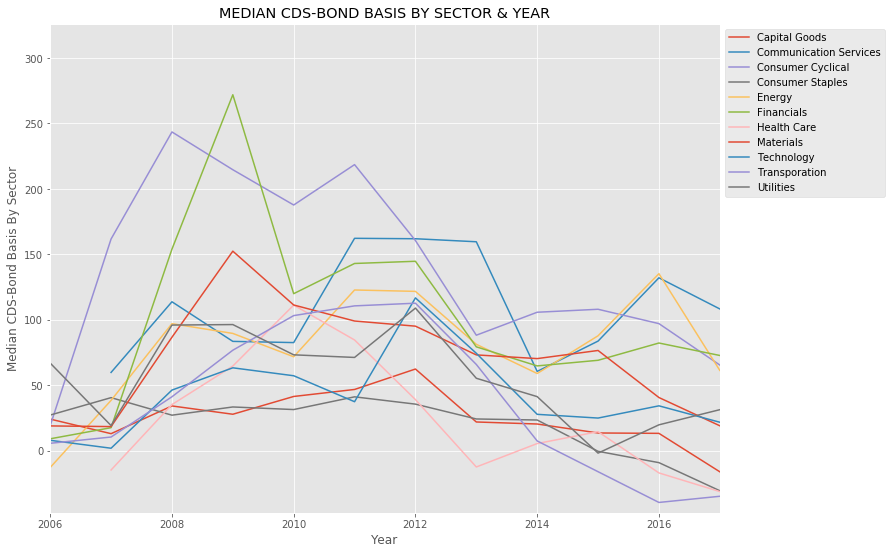

In [40]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,9))

## plot median basis by year and sector 
sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack().plot(ax=ax);

## specify the limits of eaach axis
plt.ylim(min_median_adjusted, max_median_adjusted)
plt.xlim(2006, 2017)

## title 
plt.title("MEDIAN CDS-BOND BASIS BY SECTOR & YEAR")

## optional argument to move legend outside of graph
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

## set labels per axis
ax.set_xlabel('Year')
ax.set_ylabel('Median CDS-Bond Basis By Sector');

## VISUALISE THE MEAN CDS-BOND basis \\\
#### By Sector and Year

In [32]:
#pre-define min and max mean values by sector group to define the upper and lower limits of the y-axis (median basis value)

min_mean = sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).mean()['cds_bond_basis'].min()
max_mean = sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).mean()['cds_bond_basis'].max()

#add a small amount of buffer to each value before inserting that value as the y-axis min/max:
min_mean_adjusted = min_mean * 1.05
max_mean_adjusted = max_mean * 1.05

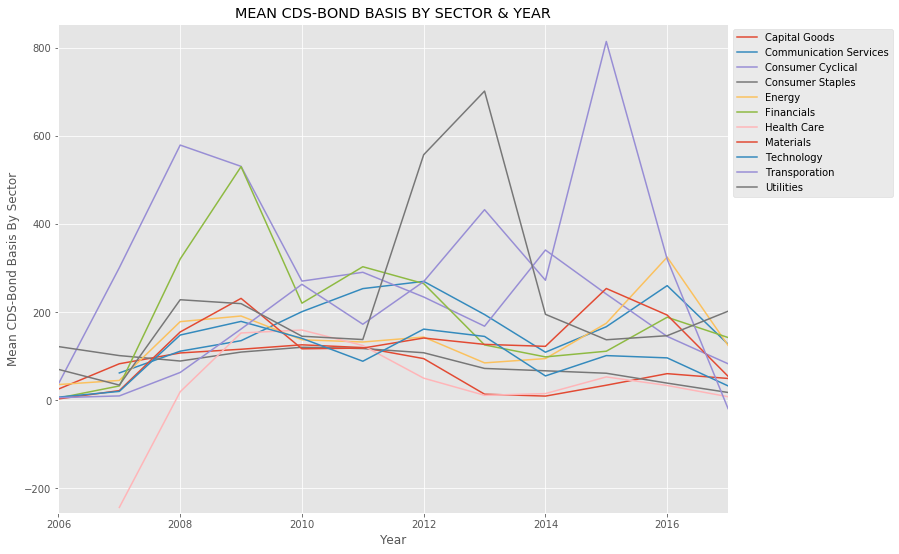

In [39]:
## plot the mean BASIS over time by sector

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,9))
sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).mean()['cds_bond_basis'].unstack().plot(ax=ax);
plt.ylim(min_mean_adjusted, max_mean_adjusted)
plt.xlim(2006, 2017)
plt.title("MEAN CDS-BOND BASIS BY SECTOR & YEAR")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Year')
ax.set_ylabel('Mean CDS-Bond Basis By Sector');

### Noticeable takeaways:
* Healthcare has a negative basis in 2007-2008; the basis then flucuates below 200 and reapproaches zero (but noteworthily does not go negative again_ in 2013-2014
    * The write-up report goes into depth on which factors drive the basis negative, and touches upon changing legal landscapes in the derivatives market which may explain by the basis does not go negative again.
    * Alternatively, this could be some form of data error, although the median basis also confirms negative basis for health-care at the same times. This would warrant a more detailed, specific inspection of this sector's data. 

* Additionally, we see high flucuations in the mean basis for transportation (with a large spike around 2015); although, this effect is less pronounced in the median- thus, the effect of a large outlier should be inspected before drawing any conclusions. 

* A similar situation is seen with utilities in 2013, although the median basis for this sector does not support this notion at all. This would suggests that a large positive basis in an outlier is perhaps to blame. 

* One expected takeaway that was expected is the high mean basis for financials around the GFC (2008-2009); which is further reinforced by the high median basis for that sector at the same time. 

## A closer inspection of healthcare & transportation

In [24]:
#visualise total unique firms by sector
sorted_alldata_df_final_adf_results.groupby(['sector'])['gvkey'].nunique()

sector
Capital Goods             35
Communication Services    10
Consumer Cyclical         70
Consumer Staples          46
Energy                    35
Financials                50
Health Care               27
Materials                 45
Technology                28
Transporation             14
Utilities                 28
Name: gvkey, dtype: int64

*  already, we see that transportation has around the smallest number of firms in the sample
    *  which would support the idea that the peak flucuation in mean- being detached from the median value-- could be potentially explained by extreme outlier values

In [49]:
## inspect the number of firms which appears in the sample period 2007-2008
## aim is to identify if the negative basis in health care is attributable to a small subsample of extreme outlier values

sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.year_index==(2007 | 2008)].groupby(
    ['sector'])['gvkey'].nunique()

sector
Capital Goods             24
Communication Services     8
Consumer Cyclical         44
Consumer Staples          34
Energy                    23
Financials                19
Health Care               15
Materials                 30
Technology                18
Transporation             10
Utilities                 14
Name: gvkey, dtype: int64

* doesn't initially appear to be a problem with extremely small subsample size

* Thus, take a more detailed inspection of 2007 and the mean-basis values for that year

In [44]:
sorted_alldata_df_final_adf_results.loc[((sorted_alldata_df_final_adf_results.sector=='Health Care') &
                                        (sorted_alldata_df_final_adf_results.year_index==(2007)))].groupby(
    ['sector'])['gvkey'].nunique()

sector
Health Care    9
Name: gvkey, dtype: int64

In [46]:
sorted_alldata_df_final_adf_results.loc[((sorted_alldata_df_final_adf_results.sector=='Health Care') &
                                        (sorted_alldata_df_final_adf_results.year_index==(2007)))].groupby(
    ['gvkey'])['cds_bond_basis'].mean()

gvkey
1602    -1059.052181
2403       -3.908243
7228     -183.197319
7257      -24.424001
7750      585.507308
8133      323.303352
14960      35.567183
28272     -17.461992
61483     143.788035
Name: cds_bond_basis, dtype: float64

### Healthcare takeaway:
* A non-trivial amount of firms in 2007 have negative bases (5 of 9); although, one firm has a particularly negatie basis
* This also confirms why the median basis is also negative as > 50% of the subsample is negative for 2007.


## PRESENTING THE MEDIAN BASIS BY SECTOR OVER TIME IN TABLE FORMAT
* [optional] May provide a slightly more detailed insight

* A full analysis of the trends and accompanying explanations is available in the formal write-up document - linked at the top of this notebook



### A brief primer on some principal trends are included here for convenience however: 
* There appears to be some aggregate-level macro event which occured around 2012, which temporarily reversed the earlier trend of shrinking basis values. One noteworthy observation is that the effect is significantly more pronounced for typically "riskier" industries, E.G. Technology, Financials and less pronounced for typically safer sectors E.G. Consumer Staples: which appears to be virtually unaffected. 
    * In the write-up, an argument and explanation is made in favour of determining whether the spike in median- and mean basis, which is presented in the write-up- can be causally explained by contagion effects from  2012's Eurozone Crisis. Broadly speaking, the answer is yes. 
    
    
* A more top-level observation is to note the long-run dynamics of the median basis across sectors. Drawing upon the aforementioned sectors above, the more typically "safe" asset classes have a long-run median which is closer to zero (E.G. consumer staples, capital goods) VS. more typically volatile sectors (E.G. Consumer Cyclical, Financials): which have consistently higher bases, as well as exhibit greater volatility. 



#####  A general observation of the data at an aggregate-level reveals the universal tendency for the median CDS-Bond basis to trend downwards over time
* Although, the graph is too noisy and therefore, too cumbersome to indentify individual sector trends- we will refer to a simple table to accomplish this task. As usual, refer to the write-up to see the detailed connection between the observeed phenomena and economic theory

* NOTE: herewithin, the CDS-Bond basis will be simply referred to as 'the basis'

In [10]:
#create a new dataframe which holds the median basis by sector per year across the sample horizon
median_sector_basis_by_sector = np.round(sorted_alldata_df_final.groupby(
    ['year_index','sector']).median()['cds_bond_basis'].unstack(),2)

In [11]:
median_sector_basis_by_sector

sector,Capital Goods,Communication Services,Consumer Cyclical,Consumer Staples,Energy,Financials,Health Care,Materials,Technology,Transporation,Utilities
year_index,,,,,,,,,,,
2006,24.12,NaN,19.09,27.22,-12.87,9.07,NaN,18.91,7.92,5.63,66.93
2007,12.99,59.78,161.75,40.52,38.44,17.57,-14.76,18.40,1.86,10.43,19.16
2008,34.18,113.78,243.54,27.12,97.03,153.96,35.23,86.67,46.29,41.19,95.97
2009,27.83,83.51,214.68,33.39,89.59,271.97,64.66,152.45,63.31,76.76,96.36
2010,41.42,82.59,187.72,31.42,71.75,119.96,111.24,111.32,57.24,103.21,73.24
2011,46.77,162.26,218.57,41.14,122.78,143.04,84.57,99.07,37.41,110.64,71.24
2012,62.39,161.94,160.57,35.56,121.72,144.72,39.03,95.14,116.75,112.68,108.94
2013,21.92,159.63,88.22,24.22,81.28,79.34,-12.46,73.18,74.42,65.89,55.32
2014,20.37,60.57,105.77,23.43,58.97,64.77,5.44,70.35,27.77,7.43,41.30


# PRE-REGRESSION CHECKS OVERVIEW
* A variety of tests must be performed prior to applying the Vector Error Correction Models (VECM)
* These tests are designed to ensure the necessary components to ensuring the validity of the VECM are satisified, otherwise no true conclusions can be drawn
* The unit root tests ensure that both series contain a unit root, such that the cointegration conclusion is valid
* The structural break test ensures that the outcomes of the unit root tests have not been influenced by a structural break in the data; more or less ensuring the outcomes of the unit root tests are valid

#### UNIT ROOT TESTS 
* Augmented Dickey Fuller (ADF)
* DFGLS 
    * an ADF test except the time series is prior transformed by a generalised least squares (GLS) regression 
* Variance Ratio Test

#### STRUCTURAL BREAK / UNIT ROOT TEST
* Zivot Andrews Structural Break Test

<a id='ADF_test'></a>

# AUGMENTED DICKEY-FULLER (ADF) TEST
* Makes use of the package from: https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ADF.html

### Unit Root Testing / Stationarity Testing
* Fundamentally, it uses an autoregressive model, and optimises the (Bayesian Information Criterion (BIC)) across multiple different lags. NOTE: Other information criterion can also be used, for which there are pros and cons. See full report for an indepth analysis on the choice of BIC over alternatives

* The hypotheses: 
    * Null Hypothesis (H0) = the process can be represented by a unit root (has a time dependent structure / is stationary)
        * If failed to be rejected, implies the series/process has a unit root (it is non-stationary)
    * Alternative Hypothesis (H1) = the process has no unit root (no-time dependent structure); that is, the series is non-stationary
        * Rejecting the H0 - suggests the series does not have a unit root and implies it is stationary
        

* Roughly speaking, the more negative the test statistic, the more likely it is to reject the null hypothesis (the data is stationary)

    
* Additionally, the interpretation of this result must be supported by a threshold p-value; this paper uses a 95% certainty (p-value <= 0.05 will result in rejecting the H0). Similarily, a p-value > 0.05 will indicate a failure to reject H0 and imply the presence of a unit root / non-stationarity


### IMPORTANT : The VECM model & its extensions require the series to not only be non-stationary, but be integrated of the same order; accordingly, all series must be characterised by a unit-root for the regression models to be valid

* THE TEST PROCEDURE FOR THE ADF TEST IS APPLIED TO A TYPICAL SERIES/MODEL (SEPERATELY FOR CDS AND BONDS)-
* A TIME SERIES AS SPECIFIED BELOW: 

$$ \Delta y_{t} = \alpha + \beta_{t} + \gamma_{yt-1} + \delta 1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_{t} $$

* Where the inputs are: 
    * $\alpha$ = constant 
    * $\beta$ = is the coefficient of a time trend (if specified, else 0) and the term will drop out
    * $p$ = the (p)th lag order of the autoregressive process
    
* By including lags, up to the potential lag order (p), this means that the lag length (p) must be determined in applying the test. Multiple strategies exist, for instance: using the t-stat and progressively working (high orders first down towards to zero) or using information crtieria. This ADF test procedure will select the order (p) according to the Bayesian Information Criterion (BIC). 
    * For a detailed analysis of why BIC was selected over alternatives, E.G. Akaike Information Criterion (AIC) please refer to the main write-up report.
    
* Accordingly, the unit-root test is carried out with the null hypothesis being denoted $\gamma$ = 0   Vs. the alternative hypothesis that $\gamma$ is <0 
* The test statistic to be compared against the relevant critical values is:
    > $$ DF _{\Gamma} =  \frac{\hat\gamma}{SE (\hat\gamma)} $$
    
    * As mentioned above, if the DF test statistic is more negative than the CV, the null hypothesis that: $\gamma$ = 0 is rejected and no unit root is presented 

In [22]:
%%time

## colletions.dict method:
df_stat_cdsbond_results = collections.defaultdict(list)

## collect novel error instances in the models + counters for logging the quantity of each error
model_error_instances_adf = []
linalg_errors = 0; value_errors = 0                 

#THE ADF CRITICAL VALUES for 1%, 5%, 10%: 
## (could be called directly from the ADF class instance but for clarity printed here)
one_percent_cv = -3.43472   
five_percent_cv = -2.86347 
ten_percent_cv = -2.56779

#create loop to test for stationarity in each GVKEY's data group: was (#sorted_alldata_df_final)
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    
    ## assign the remainder of the data to be callable from data.(variable)
    data = val[1]                        
    df_stat_cdsbond_results['gvkey'].append(gvkey)
    sector_string = data.sector
    df_stat_cdsbond_results['sector'].append(sector_string.iloc[0])
    
    #compute the specifics of each GVKEY's date / time horizon
    df_stat_cdsbond_results['first_obs'].append(data.trade_date.min())
    df_stat_cdsbond_results['last_obs'].append(data.trade_date.max())
    time_difference = data.trade_date.max() - data.trade_date.min()
    df_stat_cdsbond_results['time_horizon'].append(time_difference.days)
    
    #define the appropriate series for the ADF test: 
    cds = data.market_cds_spread         
    pecds = data.pecds
    
    #the VAR model package requires the data be structured in a particular way; np.column stack is the fastest method
    data = np.column_stack((cds, pecds)) 
    
    #the VAR model construction is necessary for computing the BIC
    model = smt.VAR(data)  

    #compute the optimised BIC value from [model] which holds the vector autoregression model per GVKEY
    try:
        #for daily data, a maximum lag length is imposed (5 trading days, roughly equivalent to one trading week)
        bic_selected_lag = model.select_order(maxlags=10).bic 
        
        # store the optimised bic_lag length per GVKEY
        df_stat_cdsbond_results['VAR_lags_bic'].append(bic_selected_lag)
        
        #ADF test - plugging in the bic selected lag length to run a unique length ADF test per GVKEY, per instrument
        test_ADF_cds = ADF(cds, trend='c', max_lags=10, method='BIC') 
        df_stat_cdsbond_results['adf_lags_cds'].append(test_ADF_cds.lags)
        
        test_ADF_bond = ADF(pecds, trend='c',  max_lags=10, method='BIC')  
        df_stat_cdsbond_results['adf_lags_bond'].append(test_ADF_bond.lags)
        
        ## create a string object of each series ADF test statistic so it can be appended with its significance (*/**/***)
        adf_bond_teststat = str((np.round(test_ADF_bond.stat,4)))
        adf_cds_teststat = str((np.round(test_ADF_bond.stat,4)))
        
        #### CDS ADF LATEX TABLE CONSTRUCTION #### [OPTIONAL] -- depending on presentation needs -- 
        #this part reads the test stat per GVKEY / instrument and assigns the appropriate (*) per its significance level
        #E.G. > 99% significance is commonly denoted as [test_statistic]*** in publication regression tables
        
        ## The 1% & 5% significance would reject H0 (series is a unit-root)
        ## The 10% and no level would fail to reject H0 (implying series is stationary)
        if test_ADF_cds.stat < one_percent_cv:
            #df_stat_cdsbond_results['ADF_signif_CDS'].append((np.round(test_ADF_cds.stat,4), "***"))   
            df_stat_cdsbond_results['ADF_signif_CDS'].append(adf_cds_teststat + str("***"))
            
        elif test_ADF_cds.stat < five_percent_cv:
            #df_stat_cdsbond_results['ADF_signif_CDS'].append((np.round(test_ADF_cds.stat,4), "**"))    
            df_stat_cdsbond_results['ADF_signif_CDS'].append(adf_cds_teststat + str("**"))
            
        elif test_ADF_cds.stat < ten_percent_cv:
            #df_stat_cdsbond_results['ADF_signif_CDS'].append((np.round(test_ADF_cds.stat,4), "*"))  
            df_stat_cdsbond_results['ADF_signif_CDS'].append(adf_cds_teststat + str("*"))
        else: 
            #df_stat_cdsbond_results['ADF_signif_CDS'].append((np.round(test_ADF_cds.stat,4), " "))  
            df_stat_cdsbond_results['ADF_signif_CDS'].append(adf_cds_teststat)
            

        #repeat for BONDS:
        if test_ADF_bond.stat < one_percent_cv:
            #df_stat_cdsbond_results['ADF_signif_BOND'].append((np.round(test_ADF_bond.stat,4), "***"))
            df_stat_cdsbond_results['ADF_signif_BOND'].append(adf_bond_teststat + str("***"))
            
        elif test_ADF_bond.stat < five_percent_cv:
            #df_stat_cdsbond_results['ADF_signif_BOND'].append((np.round(test_ADF_bond.stat,4), "**"))   
            df_stat_cdsbond_results['ADF_signif_BOND'].append(adf_bond_teststat + str("**"))
            
        elif test_ADF_bond.stat < ten_percent_cv:
            #df_stat_cdsbond_results['ADF_signif_BOND'].append((np.round(test_ADF_bond.stat,4), "*"))   
            df_stat_cdsbond_results['ADF_signif_BOND'].append(adf_bond_teststat + str("*"))
            
        else: 
            #df_stat_cdsbond_results['ADF_signif_BOND'].append((np.round(test_ADF_bond.stat,4), " "))
            df_stat_cdsbond_results['ADF_signif_BOND'].append(adf_bond_teststat)
            
        
        ##### JOINT ADF OUTCOMES ######
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        ## "not reject" the H0 implies the series is a unit root; while reject the null would imply a stationary series
        if (test_ADF_bond.stat > five_percent_cv and test_ADF_cds.stat > five_percent_cv):  
            df_stat_cdsbond_results['joint_stat_test'].append("BOND/CDS Both Have Unit Root") # jointly unit-roots
        elif (test_ADF_bond.stat > five_percent_cv and test_ADF_cds.stat < five_percent_cv):
            df_stat_cdsbond_results['joint_stat_test'].append("BOND ONLY HAS UR")
        elif (test_ADF_bond.stat < five_percent_cv and test_ADF_cds.stat > five_percent_cv):
            df_stat_cdsbond_results['joint_stat_test'].append("CDS ONLY HAS UR")            
        else: 
            df_stat_cdsbond_results['joint_stat_test'].append("Cannot Reject H0")

        
    # A linear-algebra error could be caused by market factors which have created highly erratic basis behaviour
    # This could be caused by a firm nearing bankruptcy where its basis deviates excessively far from par
    
    ## accordingly, the leading minor of the array is not positive definite is akin to taking the square root of a negative number
    except np.linalg.LinAlgError as lae:

        ## print out only the first instance of any new/novel encounted errors in the ADF loop
        linalg_error_instance = str(lae.args)
        if linalg_error_instance not in model_error_instances_adf:
            print("Novel Error Instance: << LinAlg Error >> GVKEY: {}, SECTOR: {}, Row: {}, Reason: {} ".format(
                gvkey, sector_string.iloc[0], i, lae))
            model_error_instances_adf.append(linalg_error_instance)        
      
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values or copy of the error instance instead
        df_stat_cdsbond_results['VAR_lags_bic'].append(np.nan)
        df_stat_cdsbond_results['adf_lags_cds'].append(np.nan)
        df_stat_cdsbond_results['adf_lags_bond'].append(np.nan)
        df_stat_cdsbond_results['joint_stat_test'].append("LinAlgEr")
        df_stat_cdsbond_results['ADF_signif_CDS'].append("LinAlgEr")
        df_stat_cdsbond_results['ADF_signif_BOND'].append("LinAlgEr")
        
        ## add +1 for each encountered Linear Algebra Error
        linalg_errors += 1
        continue
    
    #some series may have encounted some errors with a constant, thus adding a constant to the equation is invalid
    #this occurs due to poor liquidity in some markets, resulting in long periods of near-identical price quotes
    except (ValueError) as ve:
        
        ## print out only the first instance of any new/novel encounted errors in the ADF loop
        value_error_instance = str(ve.args)
        if value_error_instance not in model_error_instances_adf:
            print("Novel Error Instance: << ValueError >> GVKEY: {}, SECTOR: {}, Row: {}, Reason: {} ".format(
                gvkey, sector_string.iloc[0], i, ve))
            model_error_instances_adf.append(value_error_instance)
   
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values or copy of the error instance instead
        df_stat_cdsbond_results['VAR_lags_bic'].append(np.nan)
        df_stat_cdsbond_results['adf_lags_cds'].append(np.nan)
        df_stat_cdsbond_results['adf_lags_bond'].append(np.nan)
        df_stat_cdsbond_results['joint_stat_test'].append("ValueEr")
        df_stat_cdsbond_results['ADF_signif_CDS'].append("ValueEr")
        df_stat_cdsbond_results['ADF_signif_BOND'].append("ValueEr")        
    
        ## add +1 for each encountered value error
        value_errors += 1
        continue  

## construct the DF from the dictionary
df_stat_cdsbond_results_df = pd.DataFrame.from_dict(df_stat_cdsbond_results)

## print an overview of the ADF loop outcomes: 
print('\n', "--"*25, '\n', " Linear Algebra Errors #", linalg_errors, '\n', " Value Errors #", value_errors, '\n', " Total Errors #:", 
     (linalg_errors + value_errors), '\n', "--"*25, '\n', 
     "Successful ADF Tests: {}".format(len(sorted_alldata_df_final_adf_results.groupby('gvkey')['gvkey'].unique()) - (
     linalg_errors + value_errors)), '\n', "--"*25)

Novel Error Instance: << ValueError >> GVKEY: 5671, SECTOR: Consumer Cyclical, Row: 105, Reason: x contains a constant. Adding a constant with trend='c' is not allowed. 
Novel Error Instance: << LinAlg Error >> GVKEY: 5862, SECTOR: Materials, Row: 109, Reason: 1-th leading minor of the array is not positive definite 

 -------------------------------------------------- 
  Linear Algebra Errors # 4 
  Value Errors # 13 
  Total Errors #: 17 
 -------------------------------------------------- 
 Successful ADF Tests: 374 
 --------------------------------------------------
Wall time: 14.7 s


In [23]:
df_stat_cdsbond_results_df.head()

,gvkey,sector,first_obs,last_obs,time_horizon,VAR_lags_bic,adf_lags_cds,adf_lags_bond,ADF_signif_CDS,ADF_signif_BOND,joint_stat_test
0,1045,Transporation,2009-09-24,2014-05-30,1709,10.0,0.0,0.0,-4.4148,-4.4148***,CDS ONLY HAS UR
1,1078,Health Care,2008-03-17,2010-09-30,927,1.0,0.0,0.0,-1.2005,-1.2005,BOND/CDS Both Have Unit Root
2,1161,Technology,2008-04-10,2017-06-30,3368,2.0,1.0,0.0,-2.2782,-2.2782,BOND/CDS Both Have Unit Root
3,1209,Materials,2011-07-28,2017-06-30,2164,1.0,1.0,0.0,-1.5319,-1.5319,BOND/CDS Both Have Unit Root
4,1300,Capital Goods,2007-12-14,2017-03-01,3365,2.0,2.0,0.0,-2.521,-2.521,BOND/CDS Both Have Unit Root


### Merge & Pickle Updated Frame
* NOTE: only the outcome of the joint test is necessary for classifying the VECM/VAR models, hence the individual test statistics do not need to be merged. 

In [ ]:
# create simplified version without the "frills"
gvkey_adf_results_miniframe = df_stat_cdsbond_results[['gvkey','Joint_Test_Outcome','length_days']]

# merge ADF test results with main data DF: 
sorted_alldata_df_final_adf_results = sorted_alldata_df_final.merge(gvkey_adf_results_miniframe, how='left',on='gvkey')

## PICKLE OBJECT ## 
#sorted_alldata_df_final_adf_results.to_pickle("./sorted_alldata_df_final_adf_results.pkl")
sorted_alldata_df_final_adf_results = pd.read_pickle("./sorted_alldata_df_final_adf_results.pkl")

## STATIONARITY/UNIT ROOT TEST RESULTS BRIEF SUMMARY OVERVIEW
* Results under the ADF framework* 

### BRIEF RUNDOWN:
* Unit Root GVKEYS: 259
* Bond Only Unit Root GVKEYS: 67
* CDS only Unit Root GVKEYS: 35
* Both Series Stationary: 14
    * Total GVKEYS with at least one stationary series: 116
        * 116 keys will only be applicable in a VaR regression framework
    * Total GVKEYS potentially usable in VECM framework (subject to cointegration test): 259
    * Total GVKEYS to be usable in VaR / Granger Causality: (259 + 116) == 375
    

* Total Error GVKEYS (14 Value Errors + 2 Linear Algebra Errors == 16) 
* Total Analysed GVKEY groups (375 + 16) = 391

In [79]:
#isolate each group into a seperate DF
unitroot_gvkeys = df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=='BOND/CDS Both Have Unit Root']
stationary_gvkeys = df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=='Cannot Reject H0']

#group results by sector: 
unitroot_gvkeys_adf_results = unitroot_gvkeys.groupby('sector').agg({'Joint_Test_Outcome':['size']})
stationary_gvkeys_adf_results = stationary_gvkeys.groupby('sector').agg({'Joint_Test_Outcome':['size']})

#rename for better readability / the future titles
unitroot_gvkeys_adf_results = unitroot_gvkeys_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Unit Root', 'Unit_Roots')})
stationary_gvkeys_adf_results= stationary_gvkeys_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Stationary', 'Stat_Series')}) 

In [95]:
sector_adf_results = pd.concat([unitroot_gvkeys_adf_results, stationary_gvkeys_adf_results], axis=1)

sector_adf_results = sector_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Joint_Test_Outcome','Unit_Roots'),
                                                       ('Joint_Test_Outcome', 'size'):('Joint_Test_Outcome', 'Stationary')})

sector_adf_results
#issue with multi-index; but given table needs to be exportd in latex -- manual fix. 
#stationary is 2nd column (==116)

Joint_Test_Outcome           
                               Unit Roots Unit Roots
sector                                              
Capital Goods                          21         10
Communication Services                  6          4
Consumer Cyclical                      50         13
Consumer Staples                       28         18
Energy                                 28          6
Financials                             30         18
Health Care                            23          4
Materials                              25         19
Technology                             22          6
Transporation                           7          7
Utilities                              16         11

<a id='DFGLS_test'></a>

# EXPANDING THE ROBUSTNESS OF THE STATIONARITY/UNIT ROOT TESTING WITH THE DFGLS TEST (ADF TEST EXTENSION)
### The Elliott, Rothenberg and Stock’s GLS version of the Dickey-Fuller test

* DFGLS is an augmented Dickey-Fuller test. The principal difference is the time series in the DFGLS is transformed via a generalised least squares (GLS) regression before the test is performed. Elliott, Rothenberg, and Stock, as well as numerous later studies have shown this test has significantly greater power than the previous versions of the Augmented Dickey-Fuller (ADF) test. 


* THE DFGLS test transformation de-trends the series to estimate the deterministic parameters of the serires, then using this now transformed series data to perform the usual ADF test
* Then, the DFGLS performs the test for a series of models that includes (1 to K) lags of the first differenced, detrended variable.
  
    
* The test hypotheses: 
    * The null hypothesis: H0: B0 = 0
        * The null hypothesis being that Yt is a random walk, possibly with drift
    * There are two alternative hypotheses: 
        * Yt is stationary about a linear time trend
        * Yt is stationary with a possibly nonzero mean, but with no linear time trend 
        
        
* REFERENCES: 
    * Elliott, Graham & Rothenberg, Thomas J & Stock, James H, 1996. "Efficient Tests for an Autoregressive Unit Root," Econometrica, Econometric Society, vol. 64(4), pages 813-836, July.
     * PYTHON: Using Statsmodels packages: 
        * https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.DFGLS.html


In [37]:
## THE ADF CRITICAL VALUES for 1%, 5%, 10%:
## IN THE DFGLS TEST- if trend is set to constant ('c'); the critical values are identical to the ADF test
one_percent_adf_cv = -3.43472 
five_percent_adf_cv = -2.8634
ten_percent_adf_cv = -2.5677

In [38]:
%%time 

#### COLLECTIONS/DICT
df_dfgls_cdsbond_results = collections.defaultdict(list)

## a list to hold unique error instances
model_error_instances_dfgls = []
## counters for the frequency of each error encountered in the regression loop
linalg_errors = 0; value_errors = 0                 

#create loop to test for stationarity in each GVKEY's data group 
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        
    df_dfgls_cdsbond_results['gvkey'].append(gvkey)           
    sector_string = data.sector
    df_dfgls_cdsbond_results['sector'].append(sector_string.iloc[0]) 
    
    #define the appropriate series for the ADF test: 
    cds = data.market_cds_spread         
    pecds = data.pecds
    
    #the VAR model package requires the data be structured in a particular way; np.column stack is the fastest method
    data = np.column_stack((cds, pecds)) 
    
    #the VAR model construction is necessary for computing the BIC
    model = smt.VAR(data)  

    #compute the optimised BIC value from [model] which holds the vector autoregression model per GVKEY
    try:
        ## For daily data, a maximum lag length is imposed (10 trading days, roughly equivalent to two trading weeks)
        bic_selected_lag = model.select_order(maxlags=10).bic 
        
        ### DFGLS TEST ### 
        #trend == c (include a constant); critical values are identical to regular ADF test
        test_dfgls_cds_trend_c = DFGLS(cds, trend='c', max_lags=10, method='BIC')  
        test_dfgls_bond_trend_c = DFGLS(pecds, trend='c', max_lags=10, method='BIC')
        
        ## construct a string version of the statistic so the significance level can be appended to it later
        dfgls_cds_trend_stat = str(np.round(test_dfgls_cds_trend_c.stat, 4))
        dfgls_bond_trend_stat = str(np.round(test_dfgls_bond_trend_c.stat, 4))

        ### CONSTRUCTING A PUBLISHABLE LATEX TABLE OF RESULTS WITH APPENDED SIGNIFICANCE LEVELS ### 
        ## First, read the test stat per GVKEY / instrument and assigns the appropriate (*) per its significance level
        #E.G. > 99% significance is commonly denoted as [test_statistic]*** in publication regression tables
        
        ## NOTE: this inherently presents the range of the pvalue associated with each stat, E.G. ** = p_value <= 0.05
        
        ## CDS DFGLS_trend == constant: 
        ## The 1% & 5% significance would reject H0
        ## The 10% and no level would fail to reject H0
        if test_dfgls_cds_trend_c.stat < one_percent_adf_cv:
            df_dfgls_cdsbond_results['dfgls_cds_signif'].append(dfgls_cds_trend_stat + str("***")) 
        elif test_dfgls_cds_trend_c.stat < five_percent_adf_cv:
            df_dfgls_cdsbond_results['dfgls_cds_signif'].append(dfgls_cds_trend_stat + str("**"))
        elif test_dfgls_cds_trend_c.stat < ten_percent_adf_cv:
            df_dfgls_cdsbond_results['dfgls_cds_signif'].append(dfgls_cds_trend_stat + str("*"))
        else: 
            df_dfgls_cdsbond_results['dfgls_cds_signif'].append(dfgls_cds_trend_stat)

        ## BOND DFGLS_trend == constant:
        ## rules are identical to the CDS series above: 
        if test_dfgls_bond_trend_c.stat < one_percent_adf_cv:
            df_dfgls_cdsbond_results['dfgls_bond_signif'].append(dfgls_bond_trend_stat + str("***"))
        elif test_dfgls_bond_trend_c.stat < five_percent_adf_cv:
            df_dfgls_cdsbond_results['dfgls_bond_signif'].append(dfgls_bond_trend_stat + str("**"))
        elif test_dfgls_bond_trend_c.stat < ten_percent_adf_cv:
            df_dfgls_cdsbond_results['dfgls_bond_signif'].append(dfgls_bond_trend_stat + str("*"))   
        else: 
            df_dfgls_cdsbond_results['dfgls_bond_signif'].append(dfgls_bond_trend_stat)
        
        ## append the optimised BIC lag length
        df_dfgls_cdsbond_results['bic_lags'].append(bic_selected_lag) 
        
        
        #### JOINT RESULT OUTCOME #### 
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        #note: even if one series has a unit-root, it is still infeasible to include in the VECM model 
        if (test_dfgls_bond_trend_c.stat > five_percent_adf_cv and test_dfgls_cds_trend_c.stat > five_percent_adf_cv):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            #stat_test_joint_trend_c.append("BOND/CDS Both Have Unit Root")
            df_dfgls_cdsbond_results['DFGLS_joint_outcome'].append("BOND/CDS Both Have Unit Root")
            
        elif (test_dfgls_bond_trend_c.stat > five_percent_adf_cv and test_dfgls_cds_trend_c.stat < five_percent_adf_cv):
            #stat_test_joint_trend_c.append("BOND ONLY HAS UR")
            df_dfgls_cdsbond_results['DFGLS_joint_outcome'].append("BOND ONLY HAS UR")
            
        elif (test_dfgls_bond_trend_c.stat < five_percent_adf_cv and test_dfgls_cds_trend_c.stat > five_percent_adf_cv):
            #stat_test_joint_trend_c.append("CDS ONLY HAS UR")   
            df_dfgls_cdsbond_results['DFGLS_joint_outcome'].append("CDS ONLY HAS UR")
        else: 
            #stat_test_joint_trend_c.append("Cannot Reject H0")
            df_dfgls_cdsbond_results['DFGLS_joint_outcome'].append("Cannot Reject H0")
                
            
    #### ERRORS #### (Linear Algebra Error & Value Errors)
    
    # A linear-algebra error could be caused by market factors which have created highly erratic basis behaviour
    # This could be caused by a firm nearing bankruptcy where its basis deviates excessively far from par
    #accordingly, the leading minor of the array is not positive definite is akin to taking the square root of a negative number
    except np.linalg.LinAlgError as lae:
        lae_error_instance_dfgls = str(lae.args)
        if lae_error_instance_dfgls not in model_error_instances_dfgls:
            print("Novel Error Instance << LinAlg Error >> GVKEY: {}, Sector: {}, Row: {}, Reason : {} ".format(gvkey,
                sector_string.iloc[0], i, lae))
            model_error_instances_dfgls.append(lae_error_instance_dfgls)
         
        ## append placeholder NaN values to the respective lists for each (error) GVKEY  
        df_dfgls_cdsbond_results['dfgls_cds_signif'].append(np.nan) 
        df_dfgls_cdsbond_results['dfgls_bond_signif'].append(np.nan) 
        df_dfgls_cdsbond_results['bic_lags'].append(np.nan) 
        df_dfgls_cdsbond_results['DFGLS_joint_outcome'].append("LinAlg_Error") 
        
        ## update the linear algebra errors count 
        linalg_errors += 1
        continue
    
    
    ## Some series may have encounted some errors with a constant, thus adding a constant to the equation is invalid
    ## This occurs due to poor liquidity in some markets, resulting in long periods of near-identical price quotes/no variance
    ## see write-up report for a detailed breakdown of this issue pertaining to CDS illiqudity ## 
    except (ValueError) as ve:
        ve_error_instance_dfgls = str(ve.args)
        if ve_error_instance_dfgls not in model_error_instances_dfgls:
            print("Novel Error Instance << Value Error >> GVKEY: {}, Sector: {}, Row: {}, Reason : {} ".format(gvkey,
                sector_string.iloc[0], i, ve))
            model_error_instances_dfgls.append(ve_error_instance_dfgls)        

        ## append placeholder NaN values to the respective lists for each (error) GVKEY    
        df_dfgls_cdsbond_results['dfgls_cds_signif'].append(np.nan) 
        df_dfgls_cdsbond_results['dfgls_bond_signif'].append(np.nan) 
        df_dfgls_cdsbond_results['bic_lags'].append(np.nan) 
        df_dfgls_cdsbond_results['DFGLS_joint_outcome'].append("ValueError")             

        ## update the value_errors count 
        value_errors += 1
        continue  
        
## construct the DF from the dictionary                    
dfgls_cdsbond_results_df = pd.DataFrame.from_dict(df_dfgls_cdsbond_results)

## print a basic overview of error counts to successful DFGLS tests
print('\n', "--"*25, '\n', " Linear Algebra Errors #", linalg_errors, '\n', 
      " Value Errors #", value_errors, '\n', " Total Errors #:", (linalg_errors + value_errors))

print('\n', "--"*25, '\n', "Successful DFGLS Tests: {}".format(len(sorted_alldata_df_final_adf_results.groupby('gvkey')['gvkey'].unique()) - (
linalg_errors + value_errors)), '\n', "--"*25)

Novel Error Instance << Value Error >> GVKEY: 5671, Sector: Consumer Cyclical, Row: 105, Reason : x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed. 
Novel Error Instance << LinAlg Error >> GVKEY: 5862, Sector: Materials, Row: 109, Reason : 1-th leading minor of the array is not positive definite 

 -------------------------------------------------- 
  Linear Algebra Errors # 4 
  Value Errors # 13 
  Total Errors #: 17

 -------------------------------------------------- 
 Successful DFGLS Tests: 374 
 --------------------------------------------------
Wall time: 14.1 s


In [40]:
dfgls_cdsbond_results_df.head()

,gvkey,sector,dfgls_cds_signif,dfgls_bond_signif,bic_lags,DFGLS_joint_outcome
0,1045,Transporation,-0.2413,-0.749,10.0,BOND/CDS Both Have Unit Root
1,1078,Health Care,-1.2314,-1.2652,1.0,BOND/CDS Both Have Unit Root
2,1161,Technology,-0.8643,-0.6683,2.0,BOND/CDS Both Have Unit Root
3,1209,Materials,-1.5857,-1.5331,1.0,BOND/CDS Both Have Unit Root
4,1300,Capital Goods,-2.1331,-1.8384,2.0,BOND/CDS Both Have Unit Root


In [26]:
print(" Cannot Reject H0 Count: {}".format(len(dfgls_cdsbond_results_df.loc[dfgls_cdsbond_results_df.DFGLS_joint_outcome=='Cannot Reject H0'])), '\n', 
     "Bond Only Has UR: {}".format(len(dfgls_cdsbond_results_df.loc[dfgls_cdsbond_results_df.DFGLS_joint_outcome=='BOND ONLY HAS UR'])),'\n',
     "CDS Only Has UR: {}".format(len(dfgls_cdsbond_results_df.loc[dfgls_cdsbond_results_df.DFGLS_joint_outcome=='CDS ONLY HAS UR'])), '\n', 
     "Jointly Unit Roots: {}".format(len(dfgls_cdsbond_results_df.loc[dfgls_cdsbond_results_df.DFGLS_joint_outcome=='BOND/CDS Both Have Unit Root'])))

 Cannot Reject H0 Count: 2 
 Bond Only Has UR: 15 
 CDS Only Has UR: 8 
 Jointly Unit Roots: 349


### General Takeaways:
* The outcomes of the DFGLS test seem largely inline with what is expected by the theory: asset prices are stochastic/non-stationary
* Only 2 GVKEYS are jointly stationary, which can likely be attributable to a variety of factors. Due to the small volume of firms in this category, no further analysis will be done to confirm this in a statistical sense. 

## Re-updating the DF pickle object with key 'joint_outcome' results

In [53]:
#construct mini-frame to merge onto main DF:
dfgls_results_mini_df = dfgls_cdsbond_results_df[['gvkey','Joint_Outcome_c']]

## tidy up variable names:  
## note: only trend = 'c' will be included in the final DF as this is the most statistically sound methodology for bonds/CDs
dfgls_results_mini_df = dfgls_results_mini_df.rename(columns={'DFGLS_joint_outcome':'DFGLS_outcome'})

#merge DFGLS with with main DF 
sorted_alldata_df_final_adf_results = sorted_alldata_df_final_adf_results.merge(dfgls_results_mini_df,
                                                                                  how='left', on='gvkey')
## repickle updated frame:
#sorted_alldata_df_final_adf_results.to_pickle("./sorted_alldata_df_final_adf_results.pkl")

## VISUALISING SOME TABULATED SUMMARY RESULTS FOR THE DFGLS UNIT-ROOT TEST  
* DFGLS TEST WITH TREND SPECIFICATION = (C) (constant only)

In [44]:
#obtain distribution of sectors in the DF:
sector_sizes_all = dfgls_cdsbond_results_df.groupby('sector').size()

#keep the index (string name) of the sectors, to affix to the printed results:
sector_index = sector_sizes_all.index

#obtain distribution of those sectors which satisfy the conditon of both series containing a unit root:
sector_dfgls_unitroot = dfgls_cdsbond_results_df.loc[
    dfgls_cdsbond_results_df.DFGLS_joint_outcome=="BOND/CDS Both Have Unit Root"].groupby('sector').size()

#compute the % of each sector which has satisfied the condition
unitroot_ratio = sector_dfgls_unitroot / sector_sizes_all

#convert to a more readable format with (%) sign affixed
unitroot_diff = ['{:.2f}%'.format(x) for x in unitroot_ratio[:] * 100]

#tabulate results:
print(" \t\t\t\t DFGLS: UNIT ROOT TEST RESULTS: ", '\n')
print(tabulate(zip(sector_index, sector_sizes_all, sector_dfgls_unitroot, unitroot_diff),
              headers=['Sector', 'Sector Sizes','#Unit Roots in Sector','(%) of sector with UR'],
              tablefmt='orgtbl'))


 				 DFGLS: UNIT ROOT TEST RESULTS:  

| Sector                 |   Sector Sizes |   #Unit Roots in Sector | (%) of sector with UR   |
|------------------------+----------------+-------------------------+-------------------------|
| Capital Goods          |             35 |                      30 | 85.71%                  |
| Communication Services |             10 |                       9 | 90.00%                  |
| Consumer Cyclical      |             70 |                      60 | 85.71%                  |
| Consumer Staples       |             46 |                      41 | 89.13%                  |
| Energy                 |             35 |                      33 | 94.29%                  |
| Financials             |             50 |                      44 | 88.00%                  |
| Health Care            |             27 |                      25 | 92.59%                  |
| Materials              |             45 |                      39 | 86.67%                  |


<a id='comparing_ADF_DFGLS'></a>

# ASSESSING THE TWO DIFFERENT UNIT ROOT TESTING PROCEDURES
## COMPARE & CONTRAST: DFGLS & ADF RESULTS

* Discuss why results might differ, ultimately must decide upon one method to take precedence for the final VaR / VECM modelling 



* An earlier version of the DFGLS regression which includes an additional test specification for DFGLS trend == 'ct' (linear trend + constant was included). This was primarily done because some papers, such as Palladini and Portes (2011) hinted at using multiple test specifications to confirm their results. Although, it was largely found across multiple similar papers that this specification was not supported by the underlying financial theory and yielded less reliable results than the trend='c' specification. 

In [ ]:
## Create just a mini-DF which holds the: GVKEY and ADF (base) joint test outcome to merge onto final table with DFGLS:
base_adf_result_df = df_stat_cdsbond_results[['gvkey','Joint_Test_Outcome']]

## Mini_frame of DFGLS results: 
dfgls_twotrends_result_df = df_dfgls_cdsbond_results[['gvkey','sector','Joint_Outcome_c','Joint_Outcome_ct']]

## Rename the original "joint_test_outcome" to avoid confusion in the final frame:
base_adf_result_df = base_adf_result_df.rename(columns={'Joint_Test_Outcome_ADF':'Joint_Outcome_ADF'})

dfgls_adf_results_df = dfgls_twotrends_result_df.merge(base_adf_result_df, 
                                                       how='left', on='gvkey')

## CREATE TABULATION OF THE TWO DIFFERENT DFGLS TEST SPECIFICATIONS
* REMINDER: only the trend='c' was eventually used to support decisions about the regression models; simply has been kept here for demonstrative purposes

In [51]:
#create sector index
sector_sizes_all = dfgls_adf_results_df.groupby('sector').size()
sector_index = sector_sizes_all.index

#obtain distribution of those sectors which satisfy the conditon of both series containing a unit root:
sector_unitroots_c = dfgls_adf_results_df.loc[dfgls_adf_results_df.Joint_Outcome_c=="BOND/CDS Both Have Unit Root"].groupby('sector').size()
sector_unitroots_ct = dfgls_adf_results_df.loc[dfgls_adf_results_df.Joint_Outcome_ct=="BOND/CDS Both Have Unit Root"].groupby('sector').size()
sector_unitroots_adf = dfgls_adf_results_df.loc[dfgls_adf_results_df.Joint_Outcome_ADF=="BOND/CDS Both Have Unit Root"].groupby('sector').size()

#compute ratios of each specification with respect to total number of firms per sector:
dfgls_trend_c_ratio = sector_unitroots_c / sector_sizes_all
dfgls_trend_ct_ratio = sector_unitroots_ct / sector_sizes_all
adf_ratio = sector_unitroots_adf / sector_sizes_all

#reformat to be more readable
dfgls_trend_c_diff = ['{:.2f}%'.format(x) for x in dfgls_trend_c_ratio[:] * 100]
dfgls_trend_ct_diff = ['{:.2f}%'.format(x) for x in dfgls_trend_ct_ratio[:] * 100]
dfgls_adf_diff = ['{:.2f}%'.format(x) for x in adf_ratio[:] * 100]

#print tabulate
print("SUMMARY TABULATE OF THE THREE DIFFERENT TEST SPECIFICATIONS' OUTCOMES: ", '\n') #title

print(tabulate(zip(sector_index, sector_sizes_all, 
                   sector_unitroots_c, dfgls_trend_c_diff, 
                   sector_unitroots_ct, dfgls_trend_ct_diff,
                   sector_unitroots_adf, dfgls_adf_diff),
                      headers=['Sector', 'Total Firms #',
                        'DFGLS_trend_c','(%)_DFGLS(c)',
                        'DFGLS_trend_ct', '(%)_DFGLS(ct)',
                        'ADF', '(%)_ADF'],
                      tablefmt='pretty', numalign='center'))

#print totals: 
print("TOTAL NUMBER OF JOINTLY UNIT ROOT SERIES UNDER EACH TEST SPECIFICATION: ", '\n') #title
print("trend specification (constant (C)) only in DFGLS: ", 
      np.count_nonzero(dfgls_adf_results_df.Joint_Outcome_c==('BOND/CDS Both Have Unit Root')))

print("trend specification (constant + linear (CT)) only in DFGLS: ", 
      np.count_nonzero(dfgls_adf_results_df.Joint_Outcome_ct==('BOND/CDS Both Have Unit Root')))

print("trend specification (BASE ADF (C)) only in DFGLS: ", 
      np.count_nonzero(dfgls_adf_results_df.Joint_Outcome_ADF==('BOND/CDS Both Have Unit Root')))

print("Total Number of Firms in Sample {}".format(sector_sizes_all.sum()))

+------------------------+---------------+---------------+--------------+----------------+---------------+-----+---------+
|         Sector         | Total Firms # | DFGLS_trend_c | (%)_DFGLS(c) | DFGLS_trend_ct | (%)_DFGLS(ct) | ADF | (%)_ADF |
+------------------------+---------------+---------------+--------------+----------------+---------------+-----+---------+
|     Capital Goods      |      35       |      30       |    85.71%    |       20       |    57.14%     | 21  | 60.00%  |
| Communication Services |      10       |       9       |    90.00%    |       5        |    50.00%     |  6  | 60.00%  |
|   Consumer Cyclical    |      70       |      60       |    85.71%    |       44       |    62.86%     | 52  | 74.29%  |
|    Consumer Staples    |      46       |      41       |    89.13%    |       25       |    54.35%     | 29  | 63.04%  |
|         Energy         |      35       |      33       |    94.29%    |       22       |    62.86%     | 29  | 82.86%  |
|       Financia

#### BROAD TAKEAWAYS: 
    * Unsurprisingly, the additional consideration of a linear trend increases the amount of stationary characteristics in the data. 
    
    
    * A phenomena exists (notably in Technology, for example) where 100% unit-root features are almost halved with the inclusion of a linear trend. This could partly be explained by growth (more precisely, in terms of public price metrics, like share price) in that particular sector over time- with higher (sales > higher share price > smaller CDS spreads as chance of default shrinks). Although, a great deal more analysis is required to confirm this theory. 
    
    
    *  Some strength is given to this idea if you also consider "health care" which has the highest rate of unit-root among all (ct) trends; while traditionally more "secure" sectors, E.G. consumer staples, rank among the lowest (%) of occurences for all three specifications

<a id='za_test'></a>

# FURTHER ROBUSTNESS IN THE STATIONARITY/ UNIT ROOT TESTING PROCEDURE
* The outcome of the two tests may be influenced by structural breaks in the data, which is potentially likely given this paper uses longer data series than most of the sample horizons used in related papers. Accordingly, strctural breaks will bias the ADF Test towards reporting the presence of a unit root. 

* One potential solution is to identify a structural break in the data using the Zivot-Andrews test, which can automate the process of finding the most 'probable' break in the data based off the (minima) of the calculated t-statistic. The significance of which can be then addressed by using the p-value + later comparing to other tests E.G. Variance Ratio

* The approach in this paper is the Baum (2015) approximation. While the original methodology performs an autolag regression at each candidate break period, this method performs a single autolag regression in the original base form with a constant + trend with no dummies to determine an optimal lag length. This lag length is then used for all subsequent break-period regressions.

* One important short-coming of this test is that it only tests for the most significant (the minimum t-statistic) breakpoint, and thus only tests for one structural break- when in fact, there may be more than one in any given series. There is room to further develop the structural break testing procedure in future extensions to this paper at some later date. 



##  "The Zivot-Andrews structural-break unit-root test" Procedure:
* Test for unit root in a univariate process in the presence of serial correlation + single structural break 
* The breakpoint will be endogenously determined by the minimised Dickey-Fuller T-statistic

##### Important Implications for Regime Specifications
* These results will be used to formulate hypotheses regarding regime dependent structures and dynamics in the markov-switching regressions; additionally, the results of the ZA test will help to validate whether the longer data series in this paper is leading to a higher tendency to reject the presence of cointegration (longer than other related published papers).

### REFERENCES: 
* https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ZivotAndrews.html#arch.unitroot.ZivotAndrews
    * Only the arch package allows for retrieving an index variable, which can be later converted to match the date (AKA give the precise date corressponding to the structural break)
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.zivot_andrews.html


# TESTING PROCEDURE 
### Determine for each GVKEY the endogenously calculated break-point, based off the t-stat
1) First step is to find this index location, then associate this with the date for each GVKEY

2) A later step will then determine the significance of this point and judge whether further steps are necessary

3) Final step will merge these frames together to determine a level of signifiance for the breakpoints + referenced against the relevant date 
    * This is because neither package offers both the functionality of significance testing on the p-value and the date functionality together, thus both are employed

### TEST SPECIFICATIONS (ZIVOT-ANDREWS STRUCTURAL BREAK UNIT-ROOT TEST 
* Maxlag refers to the highest possible included lag as selected by the method (t-stat / BIC) etc.
    * Must allow for a sufficiently large number of lag terms in the Dickey-Fuller equations to sufficiently allow for the elimination of the correlation structure owing to the asymptotic distribution of the t-statistic. 
* Regression (trend) == 'c' (including only a constant)
* Trim = percentage of the series at the beginning/end to be excluded from the breakpoint calculation

* Test Hypotheses:
    * H0 = unit root with a single structural break
    * H1 = trend/break stationary 

In [10]:
%%time 
#implement: Step 1 -- find the date associated breakpoint

breakpoint_indexes = []                                     #will hold the raw dataframe location index integer
gvkey_list = []                                             #gvkey / reference number 
date_breakpoints = []                                       #will hold the date of the breakpoint (determined by t-stat)
infeasible_tests = 0
unbound_local_errors = 0

#create loop to run the ZA test and associate the t-stat indicated breakpoint with its respective date by gvkey/group
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        
    gvkey_list.append(gvkey)     
    cds_za = data.market_cds_spread 
    date_series = data.trade_date
    
    try:
        statsmodels_za_loop = zivot_andrews(cds_za, 
                                            trim=0.075, 
                                            maxlag=10, 
                                            regression='c', 
                                            autolag='t-stat')

        #return the index location of breakpoint
        index_location_breakpoint = statsmodels_za_loop[4]  
        ## note: the [4] corresponds to "bpidx" AKA: the index of X corresponding to the endogenously calculated breakpoint
        
        #append the integer loc value to a list (as an extra reference)
        breakpoint_indexes.append(statsmodels_za_loop[4])                      

        #find the date associated with location.integer/index (AKA: the actual date per GVKEY)
        date_breakpoints.append(date_series.iloc[index_location_breakpoint])
    
    
    except (InfeasibleTestException) as ite:
        breakpoint_indexes.append(np.nan)
        date_breakpoints.append(np.nan)
        infeasible_tests += 1
    
    
    except (UnboundLocalError) as ule:
        breakpoint_indexes.append(np.nan)
        date_breakpoints.append(np.nan)  
        unbound_local_errors += 1
    

## construct the DF & label columns     
zivotandrews_breakpoint_locations = pd.DataFrame(data=(gvkey_list, breakpoint_indexes, date_breakpoints)).T
zivotandrews_breakpoint_locations.columns = ['gvkey','loc_index','date_breakpoint']

## print error counts
print(" Total InfeasibleTestException {}".format(infeasible_tests), '\n', 
     "Total UnboundLocalError {}".format(unbound_local_errors), '\n', "--"*25)

 Total InfeasibleTestException 0 
 Total UnboundLocalError 24 
 --------------------------------------------------
Wall time: 35.1 s


* **NOTE REGARDING THE (TRY/EXCEPT) ERRORS IN THE ABOVE ZA CODE:** <p> The UnboundLocalError / InfeasibleTestException both relate to the algebra errors encountered in the same groups specified in the unit-root testing section. Primarily, this is caused by poor liquidity in either CDS or BONDS, as in the absence of a trade on any particular day, the data vendor will fill in today's value with the most recent one. Thus, in times of poor liquidity, the same value is repeated over and over again. This results in little to no variation in the series and encounters a host of algebra related errors for executing the models/tests in this project. </p>

In [13]:
#E.G.the code now has..
# 1) the GVKEY reference
# 2) the loc_index which refers to the number of observations in from the start the break point occurs
# 3) the date corressponding to this loc_index

zivotandrews_breakpoint_locations

,gvkey,loc_index,date_breakpoint
0,1045,276,2010-10-15
1,1078,139,2008-09-26
2,1161,143,2009-07-13
3,1209,1036,2015-08-20
4,1300,371,2009-05-18
...,...,...,...
386,175263,19,2009-03-20
387,176404,291,2009-03-10
388,176760,424,2009-07-17
389,179657,NaN,NaT



## BRIEF PRIMER ON STRUCTURAL BREAKS & THE ZA TEST'S IMPORTANCE

* Identifying potential breakpoints is important, otherwise the VAR and VECM regression models will assume the changes are happening in continuous time, when in reality the large changes have actually transpired over months/years. This is because the date index not being continuous will be ignored by the packages.



###  To illustrate this point visually, a single GVKEY (1045) will be shown below to demonstrate why a structural break would have a severe impact on the results. 
   
1) Visually, it is apparent there is some break occuring 2011 to 2012

2) This is resulting in an abnormally high (group-by) standard deviation, but if you were to isolate just the first section/regime (that is, before the structural break) the true standard deviation for each of the two sections is much lower in reality. 

3) The following question remains: should some of the data be discarded? Should the VAR/VECM models be conducted seperately on each regime? 



### SIDE NOTE: 
<p>As a side note, the variation in the 2nd regime of the CDS is a continuous flat line (repeated values of 5456.22)-  which is likely representative of another problem with liquidity. (When there is no trades for any given trading day, that days value is either missing (which would result in another structural break depending on how many consecutive days were missed) or, the most recent trade's value is interpolated/duplicated to fill it in). This was chosen as the method for this paper, and in most peer papers, rather than discard the data alltogether. <p


## Visualising how the ZA test works with a simple overview of the breakpoint in a sample GVKEY
* E.G. Continuing with the: GVKEY (1045) example

In [15]:
#view the loc_index indicated by the ZA test for one specific GVKEY:
zivotandrews_breakpoint_locations.loc[zivotandrews_breakpoint_locations.gvkey==1045]

,gvkey,loc_index,date_breakpoint
0,1045,276,2010-10-15


In [17]:
#create a mini DF with just the three relevant series to simplify the viewing process:
zivot_andrews_mini_explanation_df = sorted_alldata_df_final_adf_results[['gvkey','trade_date','market_cds_spread']]

#now, visualise a few observations before and after the specified "break point/date"
zivot_andrews_mini_explanation_df.loc[zivot_andrews_mini_explanation_df.gvkey==1045][274:280]

,gvkey,trade_date,market_cds_spread
274,1045,2010-10-13,1053.22
275,1045,2010-10-14,1039.01
276,1045,2010-10-15,1039.44
277,1045,2013-05-21,5456.22
278,1045,2013-05-22,5456.22
279,1045,2013-05-23,5456.22


#### Thus, it becomes fairly evident that the last date of the original breakpoint is (2010-10-15) which corresponds to the index.location(276). This is the precise location given by the Zivot Andrews test.
* Accordingly, it is obvious that the next data point is several years later and the spread is substantially higher. Thus, this is the location of the structural breakpoint. 

## Apply The  Zivot-Andrews Test to the Entire DF: 

* General Specifications (similar as before): 
    * Trim = 0.05 (percentage of the series to exclude from the beginning and the end) - can be changed
    * Maxlag = maximum lag to be conducted in the test
    * Method (BIC, AIC, t-stat) -- 
        * “t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.
        * Otherwise, the BIC/AIC choose the number of lags to minimise that respective information criterion
        
        
* Potential Test Specifications: 
    * trend = t (a consistent, time trend)
    * trend = c (just a constant)
    * trend = ct (constant + trend)        

In [46]:
print("Zivot Andrews Critical Values -- For Convenience")
ZA_critical_values_dictionary = list(za_test_cds.critical_values.values())

za_one_percent_cv = ZA_critical_values_dictionary[0]
za_five_percent_cv = ZA_critical_values_dictionary[1]
za_ten_percent_cv = ZA_critical_values_dictionary[2]
print(" 1% CV {} \n 5% CV {} \n 10% CV {}".format(za_one_percent_cv, za_five_percent_cv, za_ten_percent_cv))

Zivot Andrews Critical Values -- For Convenience
 1% CV -5.27644 
 5% CV -4.81067 
 10% CV -4.56618


In [18]:
%%time
## ZA LOOP FOR ENTIRE DF 

## initialise dictionary
dict_za_results = collections.defaultdict(list)

## hold the novel error instances in a list
problem_argument_instance = []

## initialise an error counter for a quick glimpse into the # of errors encountered in the loop 
infeasible_test_exceptions_counter = 0            

#THE ZA-TEST CRITICAL VALUES - highlighted/calculated above: (they don't change so fine to hard code in)
one_percent_cv = -5.27644   
five_percent_cv = -4.81067 
ten_percent_cv = -4.56618

#create loop to test for stationarity in each GVKEY's data group 
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]        
    dict_za_results['gvkey'].append(gvkey) 
    sector_string = data.sector
    dict_za_results['sector'].append(sector_string.iloc[0])      
    
    #compute the specifics of each GVKEY's date / time horizon
    dict_za_results['date_start'].append(data.trade_date.min())
    dict_za_results['date_end'].append(data.trade_date.max())
    
    ## calculate time horizon & append just the timedelta days part of the variable
    time_difference = data.trade_date.max() - data.trade_date.min()
    dict_za_results['length_days'].append(time_difference.days)                
    
    ## calculate also the standard deviation to provide clarity into any failed ZA tests
    ## we expect GVKEYS with poor CDS liquidity (little/no price variation) to have near 0 standard_dev and thus fail to execute
    cds_za = data.market_cds_spread      
    dict_za_results['std_dev'].append(np.round(cds_za.std(), 2))

    try:
        #run the ZA-test
        za_test_cds = ZivotAndrews(cds_za, 
                                   trend='c', 
                                   trim=0.075, 
                                   max_lags=10, 
                                   method='t-stat')

        ## create a string version of the test statistic that can have the significance appended to it 
        za_test_cds_stat_string = str(np.round(za_test_cds.stat,4))
        
        #CDS ZA-TEST LATEX TABLE CONSTRUCTION [optional]
        if za_test_cds.stat < one_percent_cv:  
            dict_za_results['CDS_ZA_TEST_STAT'].append(za_test_cds_stat_string + str("***"))
            
        elif za_test_cds.stat < five_percent_cv:  
            dict_za_results['CDS_ZA_TEST_STAT'].append(za_test_cds_stat_string + str("**"))
            
        elif za_test_cds.stat < ten_percent_cv:
            dict_za_results['CDS_ZA_TEST_STAT'].append(za_test_cds_stat_string + str("*"))
            
        else: 
            dict_za_results['CDS_ZA_TEST_STAT'].append(za_test_cds_stat_string)
            
        ## append the test's pvalue
        dict_za_results['CDS_pval'].append(np.round(za_test_cds.pvalue,4))  
        
        ## the test is set-up thus that any p_value > 0.05 will inherently reject the null (be break stationary)
        # H0 is: unit root with strcutural break
        if (za_test_cds.pvalue < 0.05): 
            dict_za_results['ZA_outcome'].append("unitroot/structural break")

        else: 
            dict_za_results['ZA_outcome'].append("trend/break stationary")


    ## handle exceptions
    except (InfeasibleTestException) as ite:
        dict_za_results['CDS_ZA_TEST_STAT'].append(np.nan)
        dict_za_results['CDS_pval'].append(np.nan)
        dict_za_results['ZA_outcome'].append("ITE_ERROR")
    
        #print just the first instance of exception/error, and append details to the seperate DF
        problematic_instance_string = str(ite.args)
        if problematic_instance_string not in problem_argument_instance:
            print("InfeasibleTestException: Row: {}, GVKEY: {}, Reason : {} ".format(i, gvkey, ite), '\n')
            problem_argument_instance.append(problematic_instance_string)
        
        infeasible_test_exceptions_counter += 1
        
## construct the DF from the dictionary
df_za_results = pd.DataFrame.from_dict(dict_za_results)
    
## print number of successful tests & error count   
print("Successful ZA tests: {}".format(len(sorted_alldata_df_final_adf_results.groupby('gvkey')['gvkey'].unique()) - (
    infeasible_test_exceptions_counter)), '\n'
      "Infeasible Test Exceptions Count: {}".format(infeasible_test_exceptions_counter), '\n', "--"*25)



InfeasibleTestException: Row: 105, Reason : The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after including 0 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models.  

InfeasibleTestException: Row: 179, Reason : The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after including 2 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models.  

InfeasibleTestException: Row: 207, Reason : The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after inc

In [19]:
## specifications ## 
## t-stat, maxlags = 10, trend='c', trim=0.05 

print(" NUMBER OF TREND/BREAK STATIONARY KEYS: {}".format(len(df_za_results.loc[df_za_results.ZA_outcome=='trend/break stationary'])),'\n', 
     "NUMBER OF UNIT ROOT / STRUCTURAL BREAK GVKEYS: {}".format(len(df_za_results.loc[df_za_results.ZA_outcome=='unitroot/structural break'])))

 NUMBER OF TREND/BREAK STATIONARY KEYS: 230 
 NUMBER OF UNIT ROOT / STRUCTURAL BREAK GVKEYS: 144


### Zivot-Andrews DF 
* From the arch package, with test-statistics and p-values

##### to be merged with the "zivotandrews_breakpoint_locations" to give breakpoint dates with significance levels

In [21]:
#merge the two DF(s)
combined_za_breakpoints_df = df_za_results.merge(zivotandrews_breakpoint_locations,
                                                how='left',
                                                on='gvkey')

combined_za_breakpoints_df.head()

,gvkey,sector,date_start,date_end,length_days,std_dev,CDS_ZA_TEST_STAT,CDS_pval,ZA_outcome,loc_index,date_breakpoint
0,1045,Transporation,2009-09-24,2014-05-30,1709,2014.14,-22.1113***,0.0000,unitroot/structural break,276,2010-10-15
1,1078,Health Care,2008-03-17,2010-09-30,927,22.75,-3.2991,0.7958,trend/break stationary,139,2008-09-26
2,1161,Technology,2008-04-10,2017-06-30,3368,395.93,-3.7004,0.5470,trend/break stationary,143,2009-07-13
3,1209,Materials,2011-07-28,2017-06-30,2164,12.62,-3.7591,0.5073,trend/break stationary,1036,2015-08-20
4,1300,Capital Goods,2007-12-14,2017-03-01,3365,19.09,-4.1215,0.2802,trend/break stationary,371,2009-05-18


In [22]:
#PICKLE DF OBJECTS: [optional] 

#combined_za_breakpoints_df.to_pickle("./combined_za_breakpoints_df.pkl")
#combined_za_breakpoints_df = pd.read_pickle("./combined_za_breakpoints_df.pkl")

### MERGE RELEVANT RESULTS ONTO MAIN DATAFRAME:
     * Combined the two ZA test frames
     * Extracted just the relevant data for the subsequent regression categorizations
     * Renamed if the variable name could be ambigious in other contexts
     * Re-merged the test outcomes/reuslts onto the main DF

In [30]:
## Create a mini version with main elements to merge with other test result frames
## Merge main components of ZA DF: 
mini_za_df = combined_za_breakpoints_df[['gvkey','CDS_ZA_TEST_STAT','CDS_pval','ZA_outcome','date_breakpoint']]

## Rename columns for more clarity in the main DF
mini_za_df = mini_za_df.rename(columns={'CDS_ZA_Test_Statistic':'CDS_ZA_STAT',
                                       'CDS_pval':'CDS_ZA_PVAL',
                                       'Outcome':'CDS_ZA_OUTCOME',
                                       'date_breakpoint':'ZA_BREAKDATE'})

## Merge with our ZA results to get information on the breakpoints:
sorted_alldata_df_final_adf_results = sorted_alldata_df_final_adf_results.merge(mini_za_df,
                                                                                  how='left',
                                                                                  on='gvkey')

## pickle updated frame: [optional]
#sorted_alldata_df_final_adf_results.to_pickle("./sorted_alldata_df_final_adf_results.pkl")

<a id='variance_ratio_test'></a>


# Variance Ratio Test: 
* Inspecting whether the asset prices follow a Brownian Motion (with drift).
    * The Null Hypothesis is the test of whether this assumption indeed holds. (That is, a sort of stochastic / unit root process with no predictability; akin to the idea outlined by the Random Walk Hypothesis (RWH)).
    * Rejection of the null hypothesis == presence of positive serial correlation in the time series
   
### Elements of the test in Python:    
    
* Trend Factor:
    * Trend Input set to (c) allows for non-zero drift in the random walk
    * Trend Input set to (n) would require increments to the mean to be mean(0). 
* lags == number of periods to be used in the multi-period variance
* Overlap == True 
* Robust (heteroskedasticity robust inference) == True
* Debiased == True


### Purpose of the test: 
* The Variance Ratio (VR) test will test the stochastic nature of asset prices against the null that there is some form of 'predictability' in the series due to serial correlation. 
* The breakdown of the variance by (user specified) time increments, labelled (K) tests the fact that the variance of the RW increments is linear in all sampling intervals. That is to say, the sample variance of some (K-period) future return: y<sub>t</sub> - y<sub>t-k</sub> is indeed (K) times the sample variance of the singular period return. Thus, the VR ratio at some lag (K) is subsequently defined as the ratio between the (1/K)th of that (K) period return to the variance of the initial, one-period return. Accordingly, for a true random walk process, the variance at each one of these user-specified increment periods (or lag intervals) (K) from (K=1, K=2, ...) should be equal.

* The merits of using overlapping data in estimating the variances and thus, obtaining a more efficient estimator are detailed in depth by: 
    * "Lo A.W. and MacKinlay A.C. (1988) "Stock market prices do not follow random walk: Evidence from a simple specification test", The Review of Financial Studies, 1, 41-66."


* Define the variance ratio of the (K)th period as:

$$ V(k) = \frac{Var ( x_{t} + x_{t-1} + ... + x_{t-k+1}) \div k}{Var ({x_{t}})}$$

$$  =   \frac{ Var ( y_{t} + y_{t-k} ) \div k}{Var ( y_{t} + y_{t-1} )} $$

$$ = 1 + 2 \sum_{i=1}^{k-1}\, ( \frac{ (k - i) }{k} ) \rho_{i} $$

* The variables defined as: 
    * $\rho_{i}$ is the i-th lag of the autocorrelation coefficient of $x_{t}$
    * V(K) is some particular linear combination of the first (k-1) AC coefficients.
    
* The underlying idea (as outlined above) is that when the series/returns are uncorrelated over time, we should have this expression equal to (1): 
    * $Var ( x_{t} + x_{t-1} + ... + x_{t-k+1})$ = $KVar ({x_{t}})$    
        * which in turn implies V(k) = 1
        * That is to say, the test also implicility tests the idea of
            * H0: $\rho_{1} == ... \rho_{k} == 0$
            * Put simply, that the returns across periods from (1) through (k) are serially uncorrelated
            
            
* Thus, the test statistic itself can be constructed based on the estimator defined above for: V(k)
    $$ VR(k) = \frac{\hat\sigma^2 (k)}{\hat\sigma^2 (1)} $$
    
    * Where $\hat\sigma^2 (1)$ is the unbiased estimator of the one-interval / one-period series variance. 
    * Using the one-period series returns $(x_{t})$ we can define it as: 
    
    $$ \hat\sigma^2 (1) = (T - 1)^{-1} \sum_{t=1}^{T} (y_{t} - y_{t-1} - \hat\mu)^2 $$
        * Where: $\hat\mu$ is the estimated mean for the estimator of the (K) period return variance of $\hat\sigma^2 (k)$ using (K)-periods of returns
        
        
        
        
* * Thus, if the prices are indeed random walks, the ratio of the variances itself should be equal to one. Otherwise, a high (low) variance would indicate positive (negative) autocorrelation in the data; thus, implying profitable strategies using past prices might exist; which would be a violation of the no-arbitrage principle of asset pricing


# Variance Ratio Loop
* A dictionary iteration was not implemented due to the already fast executime time ~1.3s using individually initalised lists during the experimentation phase. Thus, there was little incentive to re-write the code for better performance at this point. 

* The variable: "vr_increment_size" = 0.025 represents the the size of the increments/slices to compare the different sections variances. Thus, an increment size of 0.025 is 2.5% of that particular GVKEYs CDS series length; this would equate to roughly 40 equal length segments. 

* NOTE: this code executes in 1.33s, making optimising its speed rather unnecessary 

In [33]:
%%time 

## Specify a value for the increment (slice) sizes of the Variance Ratio test
## Default is 2.5%, thus 40 equal length increments per group. This variable is changeable

vr_increment_size = 0.025

#initialise lists:
gvkey_list = []; sector_list = []   
vr_ratio = [] ; vr_stat = []; vr_pvalue = []
significance_level = []; vr_test_outcome = []
vr_significance = []
infeasible_test_errors = 0

for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    #append general data regarding each group
    gvkey = val[0]
    data = val[1]                        
    gvkey_list.append(gvkey)             
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])  
    cds_varianceratio = data.market_cds_spread

    ## column stack series to meet the right test dimensions for the data:
    data_df = np.column_stack(cds_varianceratio)
    
    #take the length of the GVKEY as the increment size * length of GVKEY's series
    length_gvkey = len(cds_varianceratio) * vr_increment_size
    
    #take the floor of this value to ensure the value is an integer
    adj_length_gvkey = np.floor(length_gvkey)
    
    try: 
        variance_ratio_model_loop = VarianceRatio(data_df, trend='c', overlap=True, debiased=True, 
                                                  robust=True, lags=int(adj_length_gvkey))   

        #append the variance ratio itself 
        vr_ratio.append(np.round(variance_ratio_model_loop.vr,4))

        #append the test-statistic of the variance ratio
        vr_stat.append(np.round(variance_ratio_model_loop.stat,4))

        #append Variance Ratio's P-value:
        vr_pvalue.append(np.round(variance_ratio_model_loop.pvalue,4))

        #append the level of significance 
        ## significant at or above 99%
        if (variance_ratio_model_loop.stat >= variance_ratio_model_loop.critical_values['99%']) and (
        variance_ratio_model_loop.pvalue <= 0.05):
            significance_level.append("***")
            vr_test_outcome.append('not_rw')
            ##NOTE: variance_ratio_model_loop.alternative_hypothesis == 'process is not a random walk'
            continue

        ## significant above 95%
        elif (variance_ratio_model_loop.stat >= variance_ratio_model_loop.critical_values['95%']) and (
        variance_ratio_model_loop.pvalue <= 0.05): 
            significance_level.append("**")
            vr_test_outcome.append('not_rw')
            continue

        ## not significant at a minimum of 95%
        else: 
            significance_level.append(" ")
            vr_test_outcome.append('random_walk')
            #NOTE: variance_ratio_model_loop.null_hypothesis == 'process is a random walk'
            continue
        
    except (RuntimeWarning) as rtw:
        print("RunTime Warning, Row {}, Reason: {}".format(i, rtw), 
              "GVKEY ({})".format(gvkey), 
              "from sector: {}".format(sector_string.iloc[0]))        

#combine the test-stat with its respective significance level indicator (***, ** or nothing)
vr_significance = ["{}{}".format(vr_stat, significance_level) for vr_stat, significance_level in zip(vr_stat, significance_level)]     

#create DF and re-name columns:
variance_ratio_df = pd.DataFrame(data=(gvkey_list, sector_list, 
                                       vr_ratio, vr_significance, vr_pvalue, vr_test_outcome)).T

variance_ratio_df.columns = ['gvkey','sector','VARIANCE_RATIO','VR_STAT','VR_PVAL','VR_OUTCOME']

Wall time: 1.58 s


## COMBINE WITH THE DFGLS OUTCOMES
* The resulting DF will provide all necessary information about informing the VECM / VAR models, relating to unit roots and structural breaks

In [86]:
#MERGE VARIANCE RATIO & ZIVOT ANDREWS TESTS RESULTS:
ZA_VR_results_df = variance_ratio_df.merge(mini_za_df, how='left', on='gvkey')

## re-merge the DFGLS results with the already merged (VR + ZA) frame
complete_unitroot_info_df = ZA_VR_results_df.merge(dfgls_cdsbond_results_df, how='left', on='gvkey')

## present the first 5 lines
complete_unitroot_info_df.head()

,gvkey,sector_x,VARIANCE_RATIO,VR_STAT,VR_PVAL,VR_OUTCOME,CDS_ZA_TEST_STAT,CDS_ZA_PVAL,ZA_outcome,ZA_BREAKDATE,sector_y,dfgls_cds_signif,dfgls_bond_signif,bic_lags,DFGLS_joint_outcome
0,1045,Transporation,1.0216,0.9557,0.3392,random_walk,-22.1113***,0.0000,unitroot/structural break,2010-10-15,Transporation,-0.2413,-0.749,10.0,BOND/CDS Both Have Unit Root
1,1078,Health Care,1.4063,1.8877,0.0591,random_walk,-3.2991,0.7958,trend/break stationary,2008-09-26,Health Care,-1.2314,-1.2652,1.0,BOND/CDS Both Have Unit Root
2,1161,Technology,1.4773,1.6689,0.0951,random_walk,-3.7004,0.5470,trend/break stationary,2009-07-13,Technology,-0.8643,-0.6683,2.0,BOND/CDS Both Have Unit Root
3,1209,Materials,1.5586,3.3423***,0.0008,not_rw,-3.7591,0.5073,trend/break stationary,2015-08-20,Materials,-1.5857,-1.5331,1.0,BOND/CDS Both Have Unit Root
4,1300,Capital Goods,1.5795,1.4252,0.1541,random_walk,-4.1215,0.2802,trend/break stationary,2009-05-18,Capital Goods,-2.1331,-1.8384,2.0,BOND/CDS Both Have Unit Root


## FINAL UNIT ROOT / STRUCTURAL BREAK TEST SUMMARY OUTCOMES
* NOTE: the ZA test won't necessarily disagree with the variance ratio test / DFGLS, it is more the case that the presence of a structural break would influence the validity of the outcomes of the other tests, and consequently, influence the validity of this GVKEY's results in the subsequent VECM / VAR models.

In [85]:
print("NUMBER OF (STATIONARY) DFGLS TESTS THAT DISAGREE WITH (UNIT-ROOT) VARIANCE RATIO TESTS: {}".format(
    len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.DFGLS_joint_outcome=='Cannot Reject H0' ) &
                            (complete_unitroot_info_df.VR_OUTCOME=='random_walk')])))

print("NUMBER OF (UNIT-ROOT) DFGLS TESTS THAT DISAGEE WITH (STATIONARY) VARIANCE RATIO TESTS: {}".format(
    len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.DFGLS_joint_outcome=='BOND/CDS Both Have Unit Root' ) &
                            (complete_unitroot_info_df.VR_OUTCOME=='not_rw')])))

print("NUMBER OF JOINTLY (UNIT-ROOT) GVKEYS UNDER BOTH DFGLS + VARIANCE TESTS: {}".format(
    len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.DFGLS_joint_outcome=='BOND/CDS Both Have Unit Root' ) &
                            (complete_unitroot_info_df.VR_OUTCOME=='random_walk')])), '\n', "--"*40, '\n')

print("NUMBER OF (STATIONARY) VARIANCE RATIO TESTS WITH STRUCTURAL BREAKS: {}".format(len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.VR_OUTCOME=='not_rw') & 
                             (complete_unitroot_info_df.ZA_outcome=='unitroot/structural break')])))

print("NUMBER OF (STATIONARY) DFGLS TESTS WITH STRUCTURAL BREAKS: {}".format(len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.DFGLS_joint_outcome=='Cannot Reject H0') & 
                             (complete_unitroot_info_df.ZA_outcome=='unitroot/structural break')])))

print("NUMBER OF (UNIT ROOT) DFGLS TESTS WITH STRUCTURAL BREAKS: {}".format(len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.DFGLS_joint_outcome=='BOND/CDS Both Have Unit Root') & 
                             (complete_unitroot_info_df.ZA_outcome=='unitroot/structural break')])))

print("NUMBER OF (UNIT ROOT) DFGLS TESTS THAT ARE BREAK (STATIONARY): {}".format(len(complete_unitroot_info_df.loc[(complete_unitroot_info_df.DFGLS_joint_outcome=='BOND/CDS Both Have Unit Root') & 
                             (complete_unitroot_info_df.ZA_outcome=='trend/break stationary')])))

NUMBER OF (STATIONARY) DFGLS TESTS THAT DISAGREE WITH (UNIT-ROOT) VARIANCE RATIO TESTS: 2
NUMBER OF (UNIT-ROOT) DFGLS TESTS THAT DISAGEE WITH (STATIONARY) VARIANCE RATIO TESTS: 94
NUMBER OF JOINTLY (UNIT-ROOT) GVKEYS UNDER BOTH DFGLS + VARIANCE TESTS: 255 
 -------------------------------------------------------------------------------- 

NUMBER OF (STATIONARY) VARIANCE RATIO TESTS WITH STRUCTURAL BREAKS: 30
NUMBER OF (STATIONARY) DFGLS TESTS WITH STRUCTURAL BREAKS: 1
NUMBER OF (UNIT ROOT) DFGLS TESTS WITH STRUCTURAL BREAKS: 129
NUMBER OF (UNIT ROOT) DFGLS TESTS THAT ARE BREAK (STATIONARY): 220


## CONCLUDING NOTES ON THE UNIT ROOT TESTING PROCEDURE
* In conclusion, the unit root testing procedure has been comprised of:
    * an ADF test, later expanded upon to become a DFGLS test. 
    * Some concerns existed over the length of the series being so long, that an inevitable tendency to reject the presence of cointegration would exist. Consequently, a ZA breakpoint test was performed to see if each GVKEY could be split into (2) regimes.
    * The validity of the 'stationarity' or lack thereof across GVKEYs and eventually between GVKEY sub-samples will be confirmed with a Variance Ratio test + another DFGLS on the sub-samples directly in the VECM section. 
    * If both series have unit roots, they are eligible to be tested for cointegration
        * Else, any jointly stationary CDS/BOND series by GVKEY will only be eligible for a Granger Causality Test (GCT) within a Vector Autoregression (VAR) framework. Although, the GCT can also be applied to the unit root series as well. 

<a id='cointegration_test'></a>


# (JOHANSEN) COINTEGRATION TEST
* Proceed to testing the jointly unit root GVKEYs for a cointegrating relationship, establishing the validity of some firms for either VECM or VAR models

    
### EXPECTED OUTCOMES OF THE (FULL-LENGTH) GVKEY COINTEGRATION TESTS:     
* An ability to reject only a small number of firms likely contingent on the fact the series are much longer than previous papers; therefore, more likely to include different regimes.These difference regimes / underlying market dynamics are likely to result in an increased tendency to reject the presence of a cointegrating relationship


* **TEST PARAMETERS:**
    * Null H0: No cointegration
        * Reject the null H0 only if the test statistic is above the CV; thereby indicating at least one cointegration relationship in the data
        * Failure to reject the null means there is no cointegration
        
        
* Key Python Package: 
    * SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html

## COINTEGRATION  BREAKDOWN
* Just as with the unit root tests, the specification in this paper will include solely a constant term; although, it is possible to include a trend term as well as will be demonstrated below
 $$ \Delta X_{t}=\mu +\Phi D_{{t}}+\Pi X_{{t-p}}+\Gamma _{{p-1}}\Delta X_{{t-p+1}}+\cdots +\Gamma _{{1}}\Delta X_{{t-1}}+\varepsilon _{t},\quad t=1,\dots ,T $$
 
* Where: 
$$ \Gamma_{i} = \Pi_{1} + \cdots + \Pi_{i} - I,        i=1, \cdots + p-1 $$

*  $\Pi$ is the coefficient matrix
*  $\Phi D_{t}$ is the vector of deterministic terms 
* $X_{t}$ is the (k number) vector of variables of non-stationary / unit-root variables
* $\Gamma_{i}$ is the cointegrating vector


#### If we denote the number of cointegrating relations (or the cointegrating rank) to (r),  thus Granger's representation theoreom asserts if the coefficient matrix $\Pi$ has reduced rank (r < k) then there exists k * r matrices of $\Gamma$ and $X$ each with rank (r) such that their coefficient matrix $\Pi$ is integrated of order I(0) (that is to say, stationary)

## COINTEGRATION TEST PARAMETERS IN PYTHON:
* det_order will be specified as (0) for constant term, among options:
    * -1 = no deterministic terms
    * 0 = constant term
    * 1 = linear trend
* k_ar_diff == number of lagged differences in the model
    * will be optimised according to the (BIC) criterion within a VECM framework; subject to a max of 5 lags (approximately equal to one trading week)
    * NOTE: the test was reconducted using (AIC) -- which typically is more prone to overestimating the number of lags in the "true" model, and the final outcome for cointegrated groups was reduced by just (1). 
* Method == trace (versus eigenvalue test statistic)
* Significance level is again 5%

In [62]:
%%time 

# initialise dictionary 
dict_coint_rank = collections.defaultdict(list)

## hold error instances 
problem_argument_instances = []    

## error trackers 
value_error_counter = 0

## count number of GVKEYS with optimal lags==0 in both BIC and AIC criterion
optimal_lags_zero_count = 0; optimal_lags_zero_aic = 0

#run the cointegration test for each GVKEY group in the DF:
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                          
    dict_coint_rank['gvkey'].append(gvkey) 
    sector_string = data.sector  
    dict_coint_rank['sector'].append(sector_string.iloc[0])
    
    ## insert a boolean to filter the DF for valid and not valid cointegration test scenarios 
    ## cointegration is only valid if both series are integrated of the same order
    ## else, a GRANGER CAUSALITY TEST can be applied 
    if data.DFGLS_outcome.iloc[0]=="BOND/CDS Both Have Unit Root":
        dict_coint_rank['coint_valid'].append("coint_test_valid")
        
    else: 
        dict_coint_rank['coint_valid'].append("coint_test_not_valid")
    
    #load data for model
    cds = data.market_cds_spread
    pecds = data.pecds
    
    ## can load the data with np.column_stack as DF method is not needed until Granger Causality Tests
    data = np.column_stack((cds, pecds))     
    
    try:
        model = vecm.select_order(data, maxlags=5)
        optimal_lag_length = model.bic
        #optimal_lag_list.append(optimal_lag_length)
        
        #View AIC for curiosity; on average one expects, the AIC may "overpredict" the number of lags to include vs. BIC
        optimal_lag_length_aic = model.aic
        
        #for curiosity, track how many GVKEYS have a bic-optimised lag of 0
        if optimal_lag_length <= 0:
            optimal_lags_zero_count += 1
        
        if optimal_lag_length_aic <=0:
            optimal_lags_zero_aic += 1
       
        #load the instance model, based off the params specified above this cell
        vecm_cointeg_rank = vecm.select_coint_rank(data, det_order=0, k_ar_diff = optimal_lag_length, 
                                                  method='trace', signif=0.05)

        #Because statsmodels does not enforce the rule that maximum cointegrating-eqs must be < number of series in the system
        #E.G. the system has two series (CDS+BOND) and hence, the maximum #cointegrating eqs is (2 - 1) == 1 
        ## thus, fix in a ceil to the cointegraiton rank 
        
        if vecm_cointeg_rank.rank >= 1:
            cointegrating_rels = 1
            dict_coint_rank['coint_rank'].append(cointegrating_rels)
            
        else:
            dict_coint_rank['coint_rank'].append(vecm_cointeg_rank.rank)

        ## append the cointegration test stat   
        dict_coint_rank['coint_test_stat'].append(np.round(vecm_cointeg_rank.test_stats[0], 4))
        
        ## append string outcome of test 
        if vecm_cointeg_rank.test_stats[0] >= vecm_cointeg_rank.crit_vals[0]:
            dict_coint_rank['coint_outcome'].append("Reject_H0")
        else:
            dict_coint_rank['coint_outcome'].append('Fail_Reject_H0')
        
    #catch the ValueError of either: NaN or Infs   - print full traceback only once per unique error
    except (ValueError) as ve:
        value_error_instance = str(ve.args)
        if value_error_instance not in problem_argument_instances:
            print("UNIQUE ERROR ENCOUNTERED- ValueError: Row: {}, Reason : {} ".format(i, ve), '\n')
            problem_argument_instances.append(value_error_instance)
            
        value_error_counter += 1
    
        #append items to main lists to maintain placement consistency of data items: 
        dict_coint_rank['coint_rank'].append(np.nan)
        dict_coint_rank['coint_test_stat'].append(np.nan)
        dict_coint_rank['coint_outcome'].append(np.nan)

## construct the DF         
df_coint_rank = pd.DataFrame.from_dict(dict_coint_rank)    

## print some overview facts about the outcomes of the cointegrating testing loops + different selection criteron
print("--"*25, '\n', " Total # Value Errors ({})".format(value_error_counter), '\n', "--"*25, '\n',
      '\n', " Optimal GVKEY lag Lengths set to zero in BIC Framework: {}".format(optimal_lags_zero_count), 
      '\n', " Optional GVKEY lag lengths set to zero with AIC == {}".format(optimal_lags_zero_aic), 
      '\n\n', "<< Cointegration Rank [#1] Critical Value >> {}".format(vecm_cointeg_rank.crit_vals[0]))  

## print number of cointegrating relationships > 1 by GVKEY
print("--"*25, '\n', "TOTAL NUMBER OF GVKEYS WITH [1] COINTEGRATING RELATIONSHIP: {}".format(
len(df_coint_rank.loc[(df_coint_rank.coint_rank==1)])), '\n', '--'*25)
        

UNIQUE ERROR ENCOUNTERED- ValueError: Row: 105, Reason : x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.  

-------------------------------------------------- 
  Total # Value Errors (16) 
 -------------------------------------------------- 
 
  Optimal GVKEY lag Lengths set to zero in BIC Framework: 246 
  Optional GVKEY lag lengths set to zero with AIC == 128 

 << Cointegration Rank [#1] Critical Value >> 15.4943
-------------------------------------------------- 
 TOTAL NUMBER OF GVKEYS WITH [1] COINTEGRATING RELATIONSHIP: 103 
 --------------------------------------------------
Wall time: 7.41 s


In [64]:
df_coint_rank.head()

,gvkey,sector,coint_valid,coint_rank,coint_test_stat,coint_outcome
0,1045,Transporation,coint_test_valid,1.0,18.1460,Reject_H0
1,1078,Health Care,coint_test_valid,0.0,10.0436,Fail_Reject_H0
2,1161,Technology,coint_test_valid,0.0,10.4998,Fail_Reject_H0
3,1209,Materials,coint_test_valid,0.0,12.3264,Fail_Reject_H0
4,1300,Capital Goods,coint_test_valid,0.0,12.1631,Fail_Reject_H0


In [66]:
#make a miniature DF with just the cointegration_rank to add to main DF  [optional]
mini_coint_df = df_coint_rank[['gvkey','coint_rank']]

# left merge with MAIN DF on GVKEY
sorted_alldata_df_final_adf_results = sorted_alldata_df_final_adf_results.merge(mini_coint_df,
                                                                                  how='left',
                                                                                  on='gvkey')

## re-pickle the updated DF [pickle is optional]
# sorted_alldata_df_final_adf_results.to_pickle("./sorted_alldata_df_final_adf_results.pkl")


# REGRESSIONS SUMMARY BREAKDOWN

## VAR MODELS / GRANGER-CAUSALITY TEST
* VAR/GCT in-levels (stationary series)
    * No VECM model will be applied to jointly stationary GVKEYS. The Granger Causality Test (GCT) is as far as stationary keeys will be examined
* VAR/GCT in-differences (unit-root series')
    * GCT test in the VAR framework: to be compared (authenticed by) the VECM framework


##  VECM MODELING: 
* (JOHANSEN) Cointegration Test to determine the existence of any cointegrating relationships by GVKEY. The appropriate LAG length (BIC) is chosen according to the SIC
    
* VECM MODEL + the price discovery measures are applied to any GVKEYs with joint unitroots and evidence of a cointegrating relationship.




#### OMITTED IN THIS VERSION OF THE DOCUMENT DUE TO RELEVANCE / SPACE: 
* Robustness testing the aforementioned models on weekly time resampled data (wednesday to wednesday)
* Comparing the results of the unit root testing etc. with different trend specifications (different from simplying including a constant) 
* [TO BE RELEASED AT A LATER DATE] 
    * MS-VECM MODEL + regime switching coefficients etc. is applied in the extension regression models. To be uploaded to GITHUB when finalised.


<a id='var_gct_regressions'></a>

# VAR REGRESSIONS & GRANGER CAUSALITY TESTS
* Apply the Granger Causality Test to Vector Autoregression (VAR) models
    * Applying either the VAR in-levels or the VAR in-differences depending on the underlying characteristics of the data (jointly stationary vs jointly unit roots) 
 
* E.G. the two VAR in-differences models for both CDS and BONDS are represented below 
 
$$ \Delta CDS_{t} = C_{1} + \sum_{i=1}^{p} \phi_{1i} \Delta CDS_{t-1} + \sum_{i=1}^{p} \delta_{1i} \Delta BOND_{t-1} + \varepsilon_{1, t} $$

$$ \Delta BOND_{t} = C_{2} + \sum_{i=1}^{p} \phi_{2i} \Delta CDS_{t-1} + \sum_{i=1}^{p} \delta_{2i} \Delta BOND_{t-1} + \varepsilon_{2, t} $$

where: 
* $\phi_{i}$ and $\delta_{i}$ are the estimated coefficients in the models 
* $C_{i}$ is the constant in each series
* $\varepsilon_{i}$ are the identically and independently distributed shocks (error terms)

Accordingly, the granger causality test will test if past values of E.G. the CDS series aid in the prediction of the present value of the BOND series. If this is indeed found to be the case, it can be said that CDS Granger causes BONDS. Thus, the formal hypothesis being tested for each market is as follows:

* Null Hypothesis: The Bond market does NOT Granger cause the CDS market:

     $$ H0: \delta_{11} = \delta_{12} = \delta_{13} = \cdots = \delta_{1p} = 0 $$ 
     
     
* Null Hypothesis: The CDS market does NOT Granger cause the bond market:

     $$ H0: \phi{11} = \phi{12} = \phi{13} = \cdots = \phi{1p} = 0 $$
     
     
     

#### There are some limitations to the robustness of the conclusions regarding the Granger Causality Tests, for a full detailed analysis of these limitations please refer to the write-up report.    

In [50]:
%%time 

## initialise the dictionary
granger_causality_dict = collections.defaultdict(list)

## initialise error counters by type
linalg_error_counter = 0
value_error_counter = 0

## problem instances ##
unique_gct_problem_instances = []

                              
## run the regression loop by GVKEY group:
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):  
    gvkey = val[0]
    data = val[1]
    granger_causality_dict['gvkey'].append(gvkey)  
    sector_string = data.sector
    granger_causality_dict['sector'].append(sector_string.iloc[0]) 
    
    ## create a refined boolean which describes the parameters underpinning the causality test
    ## in some instances (E.G. two stationary series, this will affect the type of test done E.G. diff vs in-levels)
    
    ## initialise both series in their original forms (not differenced)
    if data.DFGLS_outcome.iloc[0]=="Cannot Reject H0":                 #both series are stationary 
        granger_causality_dict['test_type'].append("both_stat")
        cds = data.market_cds_spread                                
        pecds = data.pecds
        data = pd.DataFrame(data=(cds, pecds)).T  
        
    elif data.DFGLS_outcome.iloc[0]=="CDS ONLY HAS UR":                 #only CDS has a unit-root (bond is stat)
        granger_causality_dict['test_type'].append("cds_only_stat")
        cds = data.market_cds_spread  
        pecds = data.pecds
        data = pd.DataFrame(data=(cds, pecds)).T  
        
    elif data.DFGLS_outcome.iloc[0]=="BOND ONLY HAS UR":                #only bond has a unit-root (CDS is stat)
        granger_causality_dict['test_type'].append("bond_only_stat")
        cds = data.market_cds_spread
        pecds = data.pecds
        data = pd.DataFrame(data=(cds, pecds)).T              
    
    ## apply the GCT in-differences as both series have a unit root
    elif data.DFGLS_outcome.iloc[0]=="BOND/CDS Both Have Unit Root":   
        granger_causality_dict['test_type'].append("both_unitroot")
        cds = data.market_cds_spread.diff().dropna()
        pecds = data.pecds.diff().dropna()
        data = pd.DataFrame(data=(cds, pecds)).T      
        
    else: #value/linalg errors from the ADF test
        granger_causality_dict['test_type'].append("UNIT_ROOT_ERROR")
        cds = data.market_cds_spread.diff().dropna()
        pecds = data.pecds.diff().dropna()
        data = pd.DataFrame(data=(cds, pecds)).T   
        
    ## fit the VaR model & optimise the number of lags according to BIC within the VaR framework
    try:
        model = smt.VAR(data)
        max_lags_bic = model.select_order(maxlags=5).bic
        
        #override any optimal lag lengths of (0) to be (1) for the sake of a causality test
        ## if indeed the true lags is (0); the test conducted on a lag of (1) should be rejected in any case
        if max_lags_bic == 0:
            max_lags_bic = 1
        
        res = model.fit(maxlags=max_lags_bic)

        #now, apply the Granger Causality Test to the VaR model instance:
        res_causality_cds = res.test_causality(causing=['pecds'], 
                                  caused=['market_cds_spread'], kind='wald', signif=0.05)          
        
        ## generate string version of test statistic to have 95% significance pass/fail attached
        gct_test_stat_cds_string = str(np.round(res_causality_cds.test_statistic,4))
        
        ## apply a pass only if > 95% significance
        if res_causality_cds.crit_value > res_causality_cds.crit_value:                                  
            granger_causality_dict['bond_test_value'].append(gct_test_stat_cds_string + str("**"))
        else:       
            granger_causality_dict['bond_test_value'].append(gct_test_stat_cds_string)
        
        ## append the test's pvalue and conclusion
        granger_causality_dict['bond_pvalue'].append(np.round(res_causality_cds.pvalue, 4))
        granger_causality_dict['bond_on_cds_result'].append(res_causality_cds.conclusion)
        
        #cds_test_value
        #cds_pvalue
                 
        
        ###### REPEAT CAUSALITY TEST WITH CAUSED == BONDS ######
        res_causality_bond = res.test_causality(causing=['market_cds_spread'], 
                                      caused=['pecds'], kind='wald', signif=0.05)
        
        ## generate string version of test statistic to have 95% significance pass/fail attached
        gct_test_stat_bond_string = str(np.round(res_causality_bond.test_statistic,4))        
        
        if res_causality_bond.crit_value > res_causality_bond.crit_value: 
            granger_causality_dict['cds_test_value'].append(gct_test_stat_bond_string + str("**"))
            
        else:         
            granger_causality_dict['cds_test_value'].append(gct_test_stat_bond_string)
        
        ## append the test's pvalue and conclusion
        granger_causality_dict['cds_pvalue'].append(np.round(res_causality_bond.pvalue, 4))
        granger_causality_dict['cds_on_bond_result'].append(res_causality_bond.conclusion)
           
    
    ## CATCH ERROR EXCEPTIONS BY TYPE ## 
    except ValueError as ve:
        
        gct_ve_string = str(ve.args)
        if gct_ve_string not in unique_gct_problem_instances:
            print("UNIQUE VALUE ERROR ENCOUNTERED-- GVKEY: {}, ROW: {}".format(gvkey, i), '\n', gct_ve_string)
            unique_gct_problem_instances.append(gct_ve_string)
        
        value_error_counter += 1
        
        ## append items to keep list placement for errors: 
        granger_causality_dict['bond_test_value'].append(np.nan)
        granger_causality_dict['bond_pvalue'].append(np.nan)
        granger_causality_dict['bond_on_cds_result'].append(np.nan)
        
        ## repeat for bonds 
        granger_causality_dict['cds_test_value'].append(np.nan)
        granger_causality_dict['cds_pvalue'].append(np.nan)
        granger_causality_dict['cds_on_bond_result'].append(np.nan)
        
        
    ## Linear Algebra errors corresspond (unsurprisingly) to the same GVKEYs from the earlier unit-root tests
    ## once again, possibly attributable to the low variance in the CDS series.
    except np.linalg.LinAlgError as lae: 
        
        gct_lae_string = str(lae.args)
        if gct_lae_string not in unique_gct_problem_instances:
            print("UNIQUE LIN ALG ERROR ENCOUNTERED-- GVKEY: {}, ROW: {}".format(gvkey, i), '\n', gct_lae_string)
            unique_gct_problem_instances.append(gct_lae_string)
        
        linalg_error_counter += 1
        
        ## append items to keep list placement for errors: 
        granger_causality_dict['bond_test_value'].append(np.nan)
        granger_causality_dict['bond_pvalue'].append(np.nan)
        granger_causality_dict['bond_on_cds_result'].append(np.nan)
        
        ## repeat for bonds 
        granger_causality_dict['cds_test_value'].append(np.nan)
        granger_causality_dict['cds_pvalue'].append(np.nan)
        granger_causality_dict['cds_on_bond_result'].append(np.nan)        
        
        

## construct the DF from dictionary 
granger_causality_df = pd.DataFrame.from_dict(granger_causality_dict)

## print encountered errors by type to visualise: 
print("--"*25, '\n',
      "LinAlg Error Counts: #", linalg_error_counter, '\n', 'Value Error Counts: #', value_error_counter, 
     '\n', "--"*25, '\n', "Test Critical Value for 95% Significance {}".format(np.round(
     res_causality_cds.crit_value,4)), '\n', "--"*25)

UNIQUE LIN ALG ERROR ENCOUNTERED-- GVKEY: 5671, ROW: 105 
 ('1-th leading minor of the array is not positive definite',)
-------------------------------------------------- 
 LinAlg Error Counts: # 16 
 Value Error Counts: # 0 
 -------------------------------------------------- 
 Test Critical Value for 95% Significance 3.8415 
 --------------------------------------------------
Wall time: 19.1 s


# GRANGER CAUSALITY TEST EXPLAINER 
* GCT Null Hypothesis: that the (causing) series does NOT Granger cause the (caused) series
* failure to reject the null, means that (causing) series has no effect on the (caused) series
* rejecting the null means that past values of the (causing) series have a statistically significant effect on the current value of the (caused) series: this uses the past values of the (causing) series as regressors. 
* We reject the null hypothesis if the pvalues are below the desired result 

In [52]:
granger_causality_df.head()

,gvkey,sector,test_type,bond_test_value,bond_pvalue,bond_on_cds_result,cds_test_value,cds_pvalue,cds_on_bond_result
0,1045,Transporation,both_unitroot,0.0021,0.9636,fail to reject,0.0118,0.9136,fail to reject
1,1078,Health Care,both_unitroot,0.8872,0.3462,fail to reject,1.7267,0.1888,fail to reject
2,1161,Technology,both_unitroot,1.2734,0.2591,fail to reject,0.2545,0.6139,fail to reject
3,1209,Materials,both_unitroot,0.066,0.7972,fail to reject,1.7145,0.1904,fail to reject
4,1300,Capital Goods,both_unitroot,0.0053,0.9420,fail to reject,7.536,0.0060,reject


In [56]:
## only 2 gvkeys are valid in-level GC tests, both fail to reject the Null Hypothesis
granger_causality_df.loc[granger_causality_df.test_type=='both_stat']

,gvkey,sector,test_type,bond_test_value,bond_pvalue,bond_on_cds_result,cds_test_value,cds_pvalue,cds_on_bond_result
285,24678,Financials,both_stat,1.1478,0.2840,fail to reject,0.223,0.6368,fail to reject
318,29755,Consumer Cyclical,both_stat,3.9506,0.2668,fail to reject,6.2182,0.1015,fail to reject


In [59]:
print("NUMBER OF REJECTS FOR BOND GRANGER CAUSALITY ON CDS: {}".format(
    len(granger_causality_df.loc[granger_causality_df.bond_on_cds_result=='reject'])), '\n', "--"*30)

print("NUMBER OF REJECTS FOR CDS GRANGER CAUSALITY ON BOND: {}".format(
    len(granger_causality_df.loc[granger_causality_df.cds_on_bond_result=='reject'])))

NUMBER OF REJECTS FOR BOND GRANGER CAUSALITY ON CDS: 22 
 ------------------------------------------------------------
NUMBER OF REJECTS FOR CDS GRANGER CAUSALITY ON BOND: 29


### BRIEF RESULTS SUMMARY:
* A slight advantage to Granger Causality for CDS over BONDS, but relatively small relative to the sample size
* A virtually insignificant number of GCT in-levels, meaning little conclusions can be drawn from this selective sub-sample


* In general, peep papers have favoured CDS in causality by a large margin, the results have not been mirrored here
    * Once again, the impacts of long-sample series should be noted in the over-tendency to reject the null of the GCT
    * This will be explored further in the robustness testing section

<a id='VECM_MODEL_FULL'></a>


# VECTOR ERROR CORRECTION MODEL 

* BIVARIATE VECM MODEL TO BE CALCULATED IS SPECIFIED AS FOLLOWS: 

$$ \Delta CDS_{t} = C_{1} + \lambda_{1} (CDS_{t-1} - \alpha_{1} - \alpha_{2} PECDS_{t-1} ) + \sum_{i=1}^p \beta_{1i} \Delta CDS_{t-1} + \sum_{i=1}^p \delta_{1i} \Delta PECDS_{t-1} + \varepsilon_{1, t} $$

$$ \Delta PECDS_{t} = C_{2} + \lambda_{2} (CDS_{t-1} - \alpha_{1} - \alpha_{2} PECDS_{t-1} ) + \sum_{i=1}^p \beta_{2i} \Delta CDS_{t-1} + \sum_{i=1}^p \delta_{2i} \Delta PECDS_{t-1} + \varepsilon_{2, t} $$

Where: 
* $\Delta CDS_{t}$ and $\Delta PECDS_{t}$ denote the first differences of the two series respectively
* the $c_{j}$ term is the constant in each series' VECM model
* Each model's cointegrating vector (the error correction mechanism) is represented by the expression: $\lambda_{1} (CDS_{t-1} - \alpha_{1} - \alpha_{2} PECDS_{t-1} ) $ (Bond expression is the same format but denoted by the $\lambda_{2}$
* The $\sum_{i=1}^p$ denotes the (p) upper bound on the number of optimal lags in the model, as optimised according to the BIC criterion. 
* The alpha terms $\alpha_{1}$ and $\alpha_{2}$ denote the short-term adjustments in either series
* The beta terms $\beta$ is what explicility describes the long-term dynamics of the system
* The error terms (innovations) are denoted by $\varepsilon_{1, t}$ and $\varepsilon_{2, t}$ 
* The $\lambda_{i}$ terms are the speed adjustment coefficients- denoting how quickly each series reconverges towards equilibrium after some deviation


### EXPECTATION OF THE SIGNS & SIGNIFICANCE OF SPEED ADJUSTMENT COEFFICIENTS IN THE VECM MODELS
* If the CDS market is found to be the dominant market in the price discovery process, the term $\lambda_{2}$ is expected to be positive and statistically significant. 
    * Conversely, a negative $\lambda_{1}$ would indicate the CDS market who adjusts lasts, thus signifying the bond market leaders the process
    
* Accordingly, when the alpha term $\alpha_{1}$ is < 0, the series adjustment mechanism under expectation follows the below process:

 $$ \frac{\partial \Delta CDS_{t}}{\partial \Delta CDS_{t-1}} = - \lambda_{1}$$
 
* And respectively for BONDS when $\alpha_{2}$ < 0

 $$ \frac{\partial \Delta PECDS_{t}}{\partial \Delta PECDS_{t-1}} = - \lambda_{2}$$
 
* Put simply, if the previous periods CDS value is above its implied long-term equilibrium value with respect to the BOND/PECDS series, then the expectation for the current period is negative.

# PRICE DISCOVERY MEASURES
* As usual, see the write-up for the full breakdown. However, a brief primer is included here:

* The two price discovery (PD) measures
    * The Gonzalo and Granger (GG) measure
    * Hasbrouck's Measure (HAS)
    
* As each measure approaches (1) the price discovery mechanism is said to favour CDS; inversely, as they approach (0) the price discovery mechanism is said to favour BONDS.
    * Accordingly, a value of 0.5 would be indicative of situation where both markets contribute equally

### THE TWO MEASURES DECONSTRUCTED

$$ HAS Measure (LOWER) = \frac{\lambda_{2}^2 (\sigma_{1}^2 - \frac{\sigma_{12}^2}{\sigma_{2}^2}) }{\lambda_{2}^2 \sigma_{1}^2 - 2 \lambda_{1} \lambda_{2} \sigma_{12} + \lambda_{1}^2 \sigma_{2}^2} $$

$$ HAS Measure (UPPER) = \frac{ ( \lambda_{2} \sigma_{1} - \lambda_{1} \frac{\sigma_{12}}{\sigma_{2}} )^2 }{\lambda_{2}^2 \sigma_{1}^2 - 2 \lambda_{1} \lambda_{2} \sigma_{12} + \lambda_{1}^2 \sigma_{2}^2} $$ 

$$ Gonzalo Granger (GG) = \frac{\lambda_{2}}{\lambda_{2} - \lambda_{1}} $$

* Where:
    * $\sigma_{1}^2$ , $\sigma_{12}$  , $\sigma_{2}^2$  represent the elements of the covariance matrix of the error terms (sometimes refered to as the innovation terms)
    * $\lambda_{i}$ refers to the speed of adjustment
    
    
    

* While both measures fundamentally are testing for the same thing and both rely on the some of the same coefficients from the VECM model, there are still some cruical differences between the two measures. 
* The HAS measure makes use of the correlation between the two markets. Thus, the series with the greater share of price discovery in the HAS measure is the series which contributes most to the price variance of the hollistic system. 
    * In a technical sense, this is achieved by a Cholesky decomposition of the covariance matrix of the error terms, as outlined in (Hasbrouck, 1995, p.1183)
* Conversely, the GG measure attributes the role of price discovery to the market which adjusts the least to price movements in the other market. 
    * In a technical sense again, this could be seen as applying the restriction on the HAS method that $\sigma_{12}$ be equal to (0) such that the residuals are uncorrelated

#### VECM MODEL (FULL-SERIES)

In [86]:
%%time

## initialise dictionary 
vecm_result_dict = collections.defaultdict(list)


## FILTER THE ORIGINAL FRAME TO INCLUDE ONLY THOSE FIRMS WITH COINT RANK == 1, then apply model loop  
for i, val in enumerate(sorted_alldata_df_final_adf_results.loc[(
    sorted_alldata_df_final_adf_results.coint_rank==float(1.0))].groupby('gvkey')):    
    
    gvkey = val[0]
    data = val[1]
    sector_string = data.sector

    ## append the usual identifying information 
    vecm_result_dict['gvkey'].append(gvkey)
    vecm_result_dict['sector'].append(sector_string.iloc[0]) 
    vecm_result_dict['DFGLS_res'].append(data.DFGLS_outcome.iloc[0])
    
    ## load the data to create the model for each GVKEY/LOOP
    cds = data.market_cds_spread
    pecds = data.pecds
    
    ## construct either a DF or a single 2-D array to feed into the VECM model 
    vecm_data = np.column_stack((cds, pecds))
    
    ## may need to manually assign the integer value as some series have an (*) and thus, string format:
    ## the cointegration rank has already been merged onto the main DF, otherwise add the vecm.rank code from above
    if data.coint_rank.iloc[0]==("1") or ("1.0") or ("1*"):
        cointegration_rank = int(1)
    
    ## create the model instance which holds the optimal lag order (including the BIC)
    vecm_model_order = vecm.select_order(vecm_data, maxlags=5)

    ## run the model & fit
    vecm_regression_model = vecm.VECM(vecm_data, 
                                      k_ar_diff=vecm_model_order.bic, 
                                      coint_rank=cointegration_rank, 
                                      deterministic='co')

    ## seperate the base model and the fit, otherwise the loop won't properly update for each iteration
    vecm_regression_fit = vecm_regression_model.fit()

    ## append the number of observations per each GVKEYS regression
    vecm_result_dict['nobs'].append(vecm_regression_fit.nobs)



    ## assign a string edition of the regression model value to append its significance level 
    alpha_cds_string = str(np.round(vecm_regression_fit.alpha[0,0],4))
    alpha_bond_string = str(np.round(vecm_regression_fit.alpha[1,0],4))
        
    ## append the significance level of the alpha values in each GVKEY's VECM model
    ## APPLY TO CDS ALPHA 
    if vecm_regression_fit.pvalues_alpha[0,0] <= 0.01:
        vecm_result_dict['alpha_cds'].append(alpha_cds_string + str('***'))        

    elif vecm_regression_fit.pvalues_alpha[0,0] <= 0.05:
        vecm_result_dict['alpha_cds'].append(alpha_cds_string + str('**'))

    elif vecm_regression_fit.pvalues_alpha[0,0] <= 0.10:
        vecm_result_dict['alpha_cds'].append(alpha_cds_string + str('*'))

    else:
        vecm_result_dict['alpha_cds'].append(alpha_cds_string)

        
    ## append the pvalue for the CDS series 
    vecm_result_dict['cds_pval'].append(np.round(vecm_regression_fit.pvalues_alpha[0,0],4))
        
    ## REPEAT FOR BOND ALPHA    
    if vecm_regression_fit.pvalues_alpha[1,0] <= 0.01:
        vecm_result_dict['alpha_bond'].append(alpha_bond_string + str('***'))        

    elif vecm_regression_fit.pvalues_alpha[1,0] <= 0.05:
        vecm_result_dict['alpha_bond'].append(alpha_bond_string + str('**'))  

    elif vecm_regression_fit.pvalues_alpha[1,0] <= 0.10:
        vecm_result_dict['alpha_bond'].append(alpha_bond_string + str('*'))    

    else:
        vecm_result_dict['alpha_bond'].append(alpha_bond_string)  


    ## append the alpha pvalues for the BOND series:
    vecm_result_dict['bond_pval'].append(np.round(vecm_regression_fit.pvalues_alpha[1,0],4))         

    ## calculate the GG value
    gg_val = np.round(vecm_regression_fit.alpha[1,0] / vecm_regression_fit.alpha[1,0] - vecm_regression_fit.alpha[0,0], 2)

    vecm_result_dict['gg_val'].append(gg_val)
    #gg_list.append(gg_val)

    ## provide a small "grace" window around the GG-mid value (0.5) thus [49 to 51] is the neutral contribution range
    ## append the string instance of which firm leads the price discovery per GVKEY:
    if gg_val >= 0.51:
        vecm_result_dict['gg_outcome'].append("CDS")
    elif gg_val <= 0.49:
        vecm_result_dict['gg_outcome'].append("BOND")
    else:
        vecm_result_dict['gg_outcome'].append("EQUAL")

    ## assign the relevant sigma terms from the cholesky decomposition of the VECM's [sigma_u]
    sigma_u = vecm_regression_fit.sigma_u
    cholesky_decomp = np.linalg.cholesky(vecm_regression_fit.sigma_u)
    
    ## individually specify the relevant sigma(1) , sigma(12) or sigma(2) terms
    sig_1 = cholesky_decomp[0, 0]
    sig_12 = cholesky_decomp[1, 0]
    sig_2 = cholesky_decomp[1, 1]      

    ## Fit the alphas 
    x_2 = vecm_regression_fit.alpha[0,0]
    x_1 = vecm_regression_fit.alpha[1,0]        

    ## apply the HAS formula
    HAS_1 = ( x_2**2 * (sig_1**2 - sig_12**2 / sig_2**2) )  / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 )
    HAS_2 = ( (x_2 * sig_1 - x_1 * sig_12 / sig_1)**2 ) / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 )

    ## round values
    HAS_lower = np.round(HAS_1, 3)
    HAS_upper = np.round(HAS_2, 3)
    HAS_mid = np.round(((HAS_lower + HAS_upper) / 2), 2)

    ## append the price discovery measures:
    vecm_result_dict['has_lower'].append(HAS_lower)
    vecm_result_dict['has_mid'].append(HAS_mid)
    vecm_result_dict['has_upper'].append(HAS_upper)

    ## apply the string outcome of the dominant series in the HAS measure for price discovery
    if HAS_mid >= 0.51:
        vecm_result_dict['has_outcome'].append("CDS")
    elif HAS_mid <= 0.49:
        vecm_result_dict['has_outcome'].append("BOND")
    else:
        vecm_result_dict['has_outcome'].append("EQUAL")
        

## construct DF from dictionary        
vecm_result_table = pd.DataFrame.from_dict(vecm_result_dict)        
         
## Print finalised number of completed VECM iterations
print(" NUMBER OF SUCCESSFUL VECM MODELS: {}".format(len(vecm_result_table)), '\n', '--'*25, '\n', 
      "NUMBER OF VALID (JOINT UNIT ROOT GVKEY) VECM MODELS: {}".format(len(vecm_result_table.loc[
          vecm_result_table.DFGLS_res=='BOND/CDS Both Have Unit Root'])), '\n', '--'*25)


 NUMBER OF SUCCESSFUL VECM MODELS: 103 
 -------------------------------------------------- 
 NUMBER OF VALID (JOINT UNIT ROOT GVKEY) VECM MODELS: 82 
 --------------------------------------------------
Wall time: 5.55 s


In [85]:
vecm_result_table.head()

,gvkey,sector,DFGLS_res,nobs,alpha_cds,cds_pval,alpha_bond,bond_pval,gg_val,gg_outcome,has_lower,has_mid,has_upper,has_outcome
0,1045,Transporation,BOND/CDS Both Have Unit Root,545,0.0007,0.6299,0.0001***,0.0000,1.00,CDS,1.000,1.00,1.000,CDS
1,1356,Materials,BOND/CDS Both Have Unit Root,2322,0.0,0.7630,0.0***,0.0004,1.00,CDS,0.940,0.94,0.938,CDS
2,1919,Technology,BOND/CDS Both Have Unit Root,1739,-0.0018***,0.0030,-0.0004***,0.0091,1.00,CDS,0.996,1.00,0.997,CDS
3,1976,Energy,BOND/CDS Both Have Unit Root,275,-0.0075,0.1561,0.0086***,0.0001,1.01,CDS,0.822,0.82,0.817,CDS
4,2055,Materials,BOND ONLY HAS UR,1043,-0.0519***,0.0000,-2.6043***,0.0025,1.05,CDS,-0.000,9.12,18.240,CDS


<a id='vecm_model_results_pickle'></a>

## VECM MODEL RESULTS PICKLE

In [87]:
# [OPTIONAL] ## PICKLE THE VECM RESULTS TABLE 
## will be used to compare PD measures by firm-level equity variables later 

#vecm_result_table.to_pickle("./vecm_result_table.pkl")
#vecm_result_table = pd.read_pickle("./vecm_result_table.pkl") 

<a id='PRICE_DISCOVERY_RESULTS_FULL'></a>

## CONSTRUCT THE SUMMARISED PRICE DISCOVERY MEASURES RESULTS TABLE 
* Full length VECM models by sector

In [88]:
## determine how many firms in the GG measure favour CDS in the price discovery mechanism (> 0.50)
cds_gg = vecm_result_table.loc[vecm_result_table.gg_val >= 0.50].groupby(
    vecm_result_table.sector).count().take([1], axis=1)

## repeat for bonds 
bond_gg = vecm_result_table.loc[vecm_result_table.gg_val < 0.50].groupby(
    vecm_result_table.sector).count().take([1], axis=1)

## determine how many firms in the HAS measure (MID) favour CDS in the price discovery mechanism (> 0.50)
cds_has = vecm_result_table.loc[vecm_result_table.has_mid >= 0.50].groupby(
    vecm_result_table.sector).count().take([1], axis=1)

## repeat for bonds 
bond_has = vecm_result_table.loc[vecm_result_table.has_mid < 0.50].groupby(
    vecm_result_table.sector).count().take([1], axis=1)

## tally the total number of GVKEYS in each sector 
total_firms_by_sector_fullvecm = vecm_result_table.groupby('sector')['gvkey'].nunique()

In [89]:
## construct the table from the individual series
pd_discovery_frames = [cds_gg, bond_gg, cds_has, bond_has, total_firms_by_sector_fullvecm]

#concatenate the individual series
pd_discovery_frames_concat = pd.concat([cds_gg, bond_gg, cds_has, bond_has, total_firms_by_sector_fullvecm], 
                                       axis=1)

pd_discovery_measures_fullvecm = pd.DataFrame(pd_discovery_frames_concat)

pd_discovery_measures_fullvecm.columns = ['GG_CDS','GG_BOND','HAS_MID_CDS','HAS_MID_BOND','TOTAL_FIRMS_SECTOR']

In [90]:
print("TOTAL FIRMS ACROSS ALL SECTORS: {}".format(total_firms_by_sector_fullvecm.sum()), '\n', '--'*25)

pd_discovery_measures_fullvecm

TOTAL FIRMS ACROSS ALL SECTORS: 102 
 --------------------------------------------------


,GG_CDS,GG_BOND,HAS_MID_CDS,HAS_MID_BOND,TOTAL_FIRMS_SECTOR
Capital Goods,12,NaN,6,6.0,12
Communication Services,2,NaN,2,NaN,2
Consumer Cyclical,11,NaN,9,2.0,11
Consumer Staples,20,NaN,13,7.0,20
Energy,6,NaN,6,NaN,6
Financials,11,NaN,10,1.0,11
Health Care,5,NaN,3,2.0,5
Materials,16,NaN,14,2.0,16
Technology,6,NaN,3,3.0,6
Transporation,6,NaN,5,1.0,6


>>> #  << ADDITIONAL ROBUSTNESS TESTING >> 

<a id='za_split_vecm'></a>


# ZIVOT-ANDREWS BREAKPOINT SPLIT VECM MODEL + PRICE DISCOVERY MEASURES


### A ROBUSTNESS CHECK FOR THE MAIN HYPOTHESIS / VECM MODEL
* Aims to test whether the low amount of evidence for cointegration among firms in the sample has been influenced by the sample size (the length of the time series, in this case) of the firms in the sample. 
    * It may be that longer than previously used time series are resulting in a tendency to reject the presence of cointegration due to the greater probability of exogenous factors occuring as the time horizon expands- potentially altering the outcomes. 

### Split up the cointegration test into 2 sub-sample categories: 
* The split will be performed before and after the breakpoint date specified by the Zivot-Andrews Test
    * Subsequently, inspect how many firms have at least one sub-sample that shows evidence of cointegration
    * It is worth noting that a unit root check is again necessary to make sure the sub-samples' CDS and BOND series are both unit roots. 

## ZIVOT-ANDREWS BREAKPOINT SPLIT SUB-SAMPLE VECM MODELS

* This loop will filter each GVKEYs dataframe to include only that data which occurs before the zivot-andrews structural breakpoint date. 

### PART ONE)
* Compute the (before) the breakdate sub-sample VECM model 

In [108]:
%%time

## this warning appears that isn't included in the usual filter warnings 
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

## initialise dictionary
za_split_vecm_df_before = collections.defaultdict(list)

## Error Instance Lists:
model_error_instances = []
infeasible_test_count_before = 0
index_errors_before = 0

## group the data by GVKEY for the loop regressions: 
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]  
    za_split_vecm_df_before['gvkey'].append(gvkey)           
    sector_string = data.sector
    za_split_vecm_df_before['sector'].append(sector_string.iloc[0])
    
    try:
        ##place this inside the try/except block as a non-existent breakdate means an error which occured then would re-occur now
        za_breakdate = data.ZA_BREAKDATE.iloc[0]

        ## define the variables in the before sub-sample & create the DF
        data_gvkey_before = data[(data['trade_date'] <= za_breakdate)]
        cds_before = data_gvkey_before.market_cds_spread
        pecds_before = data_gvkey_before.pecds
        gvkey_data_before = pd.DataFrame(data=(cds_before, pecds_before)).T
        
        ## place the standard_deviaiton measure in this loop
        ## thus providing clarity on whether failed models are attributable to CDS illiqudity in the final DF 
        za_split_vecm_df_before['cds_stddev_b'].append(np.round(cds_before.std(), 2))
    
    ## essentially (PASS) on any GVKEYs which had invalid Zivot Andrews BP tests 
    except ValueError as zivot_andrews_ve:
        print("VALUE ERROR/MISSING ZIVOT-ANDREWS BREAKDATE: {}, Reason: {}".format(gvkey, zivot_andrews_ve))
    
    try: 

        #### For the DFGLS Test ####
        dfgls_cds_before = DFGLS(gvkey_data_before.market_cds_spread, trend='c', max_lags=10, method='BIC')
        dfgls_bond_before = DFGLS(gvkey_data_before.pecds, trend='c', max_lags=10, method='BIC')

        ## Both Bond and CDS are jointly stationary 
        if (dfgls_cds_before.stat < dfgls_cds_before.critical_values['5%'] and 
            dfgls_bond_before.stat < dfgls_bond_before.critical_values['5%']):
            za_split_vecm_df_before['dfgls_res_b'].append('jointly_stat')

        ## Bond series is stationary, CDS series has a unit root    
        elif (dfgls_cds_before.stat < dfgls_cds_before.critical_values['5%'] and     
            dfgls_bond_before.stat > dfgls_bond_before.critical_values['5%']):
            za_split_vecm_df_before['dfgls_res_b'].append('CDS_only_is_ur')

        ## CDS series is stationary, Bond series has a unit root     
        elif (dfgls_cds_before.stat > dfgls_cds_before.critical_values['5%'] and     
            dfgls_bond_before.stat < dfgls_bond_before.critical_values['5%']): 
            za_split_vecm_df_before['dfgls_res_b'].append('BOND_only_is_ur')
        
        ## both Bond/CDS series jointly both have a unit root
        else:   
            za_split_vecm_df_before['dfgls_res_b'].append('jointly_unitroots')

            
        ####  append model lags/nobs
        za_split_vecm_df_before['nobs_b'].append(dfgls_cds_before.nobs)
        za_split_vecm_df_before['dfgls_lags_b'].append((dfgls_cds_before.lags, dfgls_bond_before.lags))
        
    except (InfeasibleTestException) as ite_before: 
        error_instance_ite = str(ite_before.args)
        if error_instance_ite not in model_error_instances:
            print("NOVEL DFGLS MODEL ERROR ENCOUNTERED: E.G. Row: {}, GVKEY: {}, Reason : {} ".format(
                i, gvkey, ite_before), '\n')
            model_error_instances.append(error_instance_ite)        
        
        ## update error counter
        infeasible_test_count_before += 1 
        
        ## append np.nan placeholders        
        za_split_vecm_df_before['dfgls_res_b'].append(np.nan)
        za_split_vecm_df_before['nobs_b'].append(np.nan)
        za_split_vecm_df_before['dfgls_lags_b'].append(np.nan)
        
    
    #####  VECM MODEL ##### (BEFORE SUB-SAMPLE)    
    try:
        ## ensure the GVKEY has the relevant breakdate to avoid loading the (t-1) loop's value:
        za_breakdate = data.ZA_BREAKDATE.iloc[0]
        
        #### FOR THE COINTEGRATION TEST #### 
        ## ascertain number of optimal lags in the sub-sample: 
        model_lags_before = vecm.select_order(gvkey_data_before, maxlags=10)

        ## ascertain the cointegration rank in the sub-sample
        coint_rank_before = vecm.select_coint_rank(gvkey_data_before, det_order=0, k_ar_diff=model_lags_before.bic,
                                                        method='trace', signif=0.05)
        
        ### enforce that no GVKEY have more than one cointegration relation (limit is #K variables[2]-(1) = (1) CointEqs)
        cointegration_order = coint_rank_before.rank
        if cointegration_order >1:
            cointegration_order=1
        
        ##### run the VECM model on the sub-sample: #####
        vecm_regression_model_before = vecm.VECM(gvkey_data_before, k_ar_diff=model_lags_before.bic,
                                                coint_rank=cointegration_order, deterministic='co')
        
        vecm_regression_model_before_fit = vecm_regression_model_before.fit()
        
        ## run the cholesky decomposition on the sigma matrix to fit the price discovery measures (GG/HAS)
        cholesky_decomposition_before = np.linalg.cholesky(vecm_regression_model_before_fit.sigma_u)
        
        ## construct alpha values as string so that significance levels can be appended in the DF (*, **, ***): 
        vecm_alpha_1_b = str(np.round(vecm_regression_model_before_fit.alpha[0,0], 4))
        vecm_alpha_2_b = str(np.round(vecm_regression_model_before_fit.alpha[1,0], 4))
        
        ## fit the respective significance indicator to the alpha term based on its p-value (1%, 5%, 10% levels)
        if vecm_regression_model_before_fit.pvalues_alpha[0,0] <= 0.01:
            za_split_vecm_df_before['vecm_a1_signif_b'].append(vecm_alpha_1_b + str("***"))
        elif vecm_regression_model_before_fit.pvalues_alpha[0,0] <= 0.05: 
            za_split_vecm_df_before['vecm_a1_signif_b'].append(vecm_alpha_1_b + str("**"))
        elif vecm_regression_model_before_fit.pvalues_alpha[0,0] <= 0.10: 
            za_split_vecm_df_before['vecm_a1_signif_b'].append(vecm_alpha_1_b + str("*"))
        else:
            za_split_vecm_df_before['vecm_a1_signif_b'].append(vecm_alpha_1_b)
 

        ## repeat for the 2nd alpha term in the before sub-sample VECM
        if vecm_regression_model_before_fit.pvalues_alpha[1,0] <= 0.01:
            za_split_vecm_df_before['vecm_a2_signif_b'].append(vecm_alpha_2_b + str("***"))
        elif vecm_regression_model_before_fit.pvalues_alpha[1,0] <= 0.05:
            za_split_vecm_df_before['vecm_a2_signif_b'].append(vecm_alpha_2_b + str("**"))
        elif vecm_regression_model_before_fit.pvalues_alpha[1,0] <= 0.10:
            za_split_vecm_df_before['vecm_a2_signif_b'].append(vecm_alpha_2_b + str("*"))
        else:
            za_split_vecm_df_before['vecm_a2_signif_b'].append(vecm_alpha_2_b)
            
            
        ## append cointegration level/rank ## (Recall: >1 has been limited to (1))
        za_split_vecm_df_before['coint_rank_b'].append(cointegration_order)
 
        #####  COMPUTE PRICE DISCOVERY METRICS ##### 
        ## append the GG measure 
        za_split_vecm_df_before['gg_b'].append(np.round(vecm_regression_model_before_fit.alpha[1,0] / 
                                       vecm_regression_model_before_fit.alpha[1,0] - vecm_regression_model_before_fit.alpha[0,0], 2))
        
        # assign the relevant sigma terms from the cholesky decomp & alpha terms
        sig_1 = cholesky_decomposition_before[0, 0]
        sig_12 = cholesky_decomposition_before[1, 0]
        sig_2 = cholesky_decomposition_before[1, 1]
        x_2 = vecm_regression_model_before_fit.alpha[0, 0]
        x_1 = vecm_regression_model_before_fit.alpha[1, 0]
        
        ## apply the HAS formula
        HAS_1 = ( x_2**2 * (sig_1**2 - sig_12**2 / sig_2**2) )  / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 )
        HAS_2 = ( (x_2 * sig_1 - x_1 * sig_12 / sig_1)**2 ) / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 )        
        
        ## append (HAS) items
        za_split_vecm_df_before['has_lower_b'].append(np.round(HAS_1, 4))
        za_split_vecm_df_before['has_upper_b'].append(np.round(HAS_2, 4))
        za_split_vecm_df_before['has_mid_b'].append(np.round((HAS_2 + HAS_1) / 2, 4))
        
        ## append VECM model models (BIC)
        za_split_vecm_df_before['vecm_lags_b'].append(model_lags_before.bic)

        ### append the final outcome of the granger causality tests based on the p-values for each directional causality test
        if ((vecm_regression_model_before_fit.test_granger_causality(caused=0).test_statistic >= vecm_regression_model_before_fit.test_granger_causality(caused=0).crit_value) and 
            (vecm_regression_model_before_fit.test_granger_causality(caused=1).test_statistic >= vecm_regression_model_before_fit.test_granger_causality(caused=1).crit_value)):
            za_split_vecm_df_before['gct_b'].append("dual_causality")
            
        elif vecm_regression_model_before_fit.test_granger_causality(caused=0).test_statistic >= vecm_regression_model_before_fit.test_granger_causality(caused=0).crit_value:
            za_split_vecm_df_before['gct_b'].append("cds_causes")
            
        elif vecm_regression_model_before_fit.test_granger_causality(caused=1).test_statistic >= vecm_regression_model_before_fit.test_granger_causality(caused=1).crit_value:
            za_split_vecm_df_before['gct_b'].append("bond_causes")
            
        else:
            za_split_vecm_df_before['gct_b'].append("neither_causes")
        
    ## Exception Error Clauses ## 
    ## note an index error occurs when cointegration relations == 0 
    ## algebra errors occur for the same reasons outlined in the original ADF code
    except (IndexError, np.linalg.LinAlgError, ValueError) as vecm_model_error_before: 
        ## print only the first (novel) instance of each type of error:
        error_instance = str(vecm_model_error_before.args)
        if error_instance not in model_error_instances:
            print("NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: {}, GVKEY: {}, Reason : {} ".format(
                i, gvkey, vecm_model_error_before), '\n')
            model_error_instances.append(error_instance)
        
        ## update error counter
        index_errors_before += 1 
        
        ## append np.nan placeholders
        za_split_vecm_df_before['coint_rank_b'].append(np.nan)
        za_split_vecm_df_before['vecm_a1_signif_b'].append(np.nan)
        za_split_vecm_df_before['vecm_a2_signif_b'].append(np.nan)
        za_split_vecm_df_before['gg_b'].append(np.nan)
        za_split_vecm_df_before['has_lower_b'].append(np.nan)
        za_split_vecm_df_before['has_upper_b'].append(np.nan)
        za_split_vecm_df_before['has_mid_b'].append(np.nan)
        za_split_vecm_df_before['vecm_lags_b'].append(np.nan)
        za_split_vecm_df_before['gct_b'].append(np.nan)
        
## construct the DF from dict
za_split_vecm_dataframe_b = pd.DataFrame.from_dict(za_split_vecm_df_before)

## print the number of errors encounted & the critical value of the test
print("--"*25, '\n', "Infeasible Tests (Before): {}".format(infeasible_test_count_before), '\n', 
      "Index Errors (Before): {}".format(index_errors_before), '\n',
      "Successful VECM Iterations (Before): {}".format(len(za_split_vecm_dataframe_b) - index_errors_before), '\n',
      "Percentage of Successful VECM Iterations (Before): {:.0%}".format(len(
      za_split_vecm_dataframe_b.loc[za_split_vecm_dataframe_b.coint_rank_b>=1]) /len(za_split_vecm_dataframe_b)),
      
     '\n', "--"*25, '\n',  "--"*25, '\n', 
     "##### < RELEVANT CRITICAL VALUES >  #####", '\n',
     "DFGLS Critical Value 5%: {}".format(np.round(dfgls_cds_before.critical_values['5%'],4)), '\n'
     " Johansen Cointegration Critical Value (#1 Cointegrating Rel): {}".format(np.round(coint_rank_before.crit_vals,4)), 
      '\n', "--"*25, '\n')

NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: 0, GVKEY: 1045, Reason : index 0 is out of bounds for axis 1 with size 0  

NOVEL DFGLS MODEL ERROR ENCOUNTERED: E.G. Row: 21, GVKEY: 2019, Reason : The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after including 0 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models.  

NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: 21, GVKEY: 2019, Reason : x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.  

NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: 26, GVKEY: 2150, Reason : array must not contain infs or NaNs  

NOVEL DFGLS MODEL ERROR ENCOUNTERED: E.G. Row: 65, GVKEY: 3580, Reason : A minimum of 4 observations are needed to run an ADF

In [109]:
#E.G. 
za_split_vecm_dataframe_b.tail(3)

,gvkey,sector,cds_stddev_b,dfgls_res_b,nobs_b,dfgls_lags_b,coint_rank_b,vecm_a1_signif_b,vecm_a2_signif_b,gg_b,has_lower_b,has_upper_b,has_mid_b,vecm_lags_b,gct_b
388,176760,Materials,220.91,jointly_unitroots,423.0,"(1, 0)",1.0,-0.0049,0.0022***,1.0,0.9988,0.9992,0.999,1.0,neither_causes
389,179657,Capital Goods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,179700,Consumer Staples,1.53,jointly_unitroots,148.0,"(0, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PART TWO -- VECM AFTER
* Compute the (after) the breakdate sub-sample VECM model 

In [110]:
%%time

## initialise dictionary for (AFTER) breakdate subsample
za_split_vecm_df_after = collections.defaultdict(list)

## Error Instance Lists:
model_error_instances_after = []
infeasible_test_count_after = 0
index_errors_after = 0

## group the data by GVKEY for the loop regressions: 
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]  
    za_split_vecm_df_after['gvkey'].append(gvkey)           
    sector_string = data.sector
    za_split_vecm_df_after['sector'].append(sector_string.iloc[0])
    
    try:
        ##place this inside the try/except block as a non-existent breakdate means an error which occured then would re-occur now
        za_breakdate = data.ZA_BREAKDATE.iloc[0]

        ## define the variables in the before sub-sample & create the DF
        data_gvkey_after = data[(data['trade_date'] > za_breakdate)]
        cds_after = data_gvkey_after.market_cds_spread
        pecds_after = data_gvkey_after.pecds
        gvkey_data_after = pd.DataFrame(data=(cds_after, pecds_after)).T
        
        ## place the standard_deviaiton measure in this loop
        ## thus providing clarity on whether failed models are attributable to CDS illiqudity in the final DF 
        za_split_vecm_df_after['cds_stddev_a'].append(np.round(cds_after.std(), 2))
    
    except ValueError as zivot_andrews_ve:
        print("VALUE ERROR/MISSING ZIVOT-ANDREWS BREAKDATE: {}, Reason: {}".format(gvkey, zivot_andrews_ve))
    
    try: 

        #### For the DFGLS Test ####
        dfgls_cds_after = DFGLS(gvkey_data_after.market_cds_spread, trend='c', max_lags=10, method='BIC')
        dfgls_bond_after = DFGLS(gvkey_data_after.pecds, trend='c', max_lags=10, method='BIC')

        ## Both Bond and CDS are jointly stationary 
        if (dfgls_cds_after.stat < dfgls_cds_after.critical_values['5%'] and 
            dfgls_bond_after.stat < dfgls_bond_after.critical_values['5%']):
            za_split_vecm_df_after['dfgls_res_a'].append('jointly_stat')

        ## Bond series is stationary, CDS series has a unit root    
        elif (dfgls_cds_after.stat < dfgls_cds_after.critical_values['5%'] and     
            dfgls_bond_after.stat > dfgls_bond_after.critical_values['5%']):
            za_split_vecm_df_after['dfgls_res_a'].append('CDS_only_is_ur')

        ## CDS series is stationary, Bond series has a unit root     
        elif (dfgls_cds_after.stat > dfgls_cds_after.critical_values['5%'] and     
            dfgls_bond_after.stat < dfgls_bond_after.critical_values['5%']): 
            za_split_vecm_df_after['dfgls_res_a'].append('BOND_only_is_ur')
        
        ## both Bond/CDS series jointly both have a unit root
        else:   
            za_split_vecm_df_after['dfgls_res_a'].append('jointly_unitroots')

            
        ####  append model lags/nobs
        za_split_vecm_df_after['nobs_a'].append(dfgls_cds_after.nobs) 
        za_split_vecm_df_after['dfgls_lags_a'].append((dfgls_cds_after.lags, dfgls_bond_after.lags))
        
    except (InfeasibleTestException) as ite_after: 
        error_instance_ite = str(ite_after.args)
        if error_instance_ite not in model_error_instances_after:
            print("NOVEL DFGLS MODEL ERROR ENCOUNTERED: E.G. Row: {}, GVKEY: {}, Reason : {} ".format(
                i, gvkey, ite_after), '\n')
            model_error_instances_after.append(error_instance_ite)        
        
        ## update error counter
        infeasible_test_count_after += 1 
        
        ## append np.nan placeholders
        za_split_vecm_df_after['dfgls_res_a'].append(np.nan)
        za_split_vecm_df_after['nobs_a'].append(np.nan)
        za_split_vecm_df_after['dfgls_lags_a'].append(np.nan)
        
    
    #####  VECM MODEL ##### (AFTER BREAKDATE SUB-SAMPLE)    
    try:
        ## ensure the GVKEY has the relevant breakdate to avoid loading the (t-1) loop's value:
        za_breakdate = data.ZA_BREAKDATE.iloc[0]
        
        #### FOR THE COINTEGRATION TEST #### 
        ## ascertain number of optimal lags in the sub-sample: 
        model_lags_after = vecm.select_order(gvkey_data_after, maxlags=10)

        ## ascertain the cointegration rank in the sub-sample
        coint_rank_after = vecm.select_coint_rank(gvkey_data_after, det_order=0, k_ar_diff=model_lags_after.bic,
                                                        method='trace', signif=0.05)
        
        ### enforce that no GVKEY have more than one cointegration relation (limit is #K variables[2]-(1) = (1) CointEqs)
        cointegration_order = coint_rank_after.rank
        if cointegration_order >1:
            cointegration_order=1
        
        ##### run the VECM model on the sub-sample: #####
        vecm_regression_model_after = vecm.VECM(gvkey_data_after, k_ar_diff=model_lags_after.bic,
                                                coint_rank=cointegration_order, deterministic='co')
        
        vecm_regression_model_after_fit = vecm_regression_model_after.fit()
        
        ## run the cholesky decomposition on the sigma matrix to fit the price discovery measures (GG/HAS)
        cholesky_decomposition_after = np.linalg.cholesky(vecm_regression_model_after_fit.sigma_u)
        
        ## construct alpha values as string so that significance levels can be appended in the DF (*, **, ***): 
        vecm_alpha_1_a = str(np.round(vecm_regression_model_after_fit.alpha[0,0], 4))
        vecm_alpha_2_a = str(np.round(vecm_regression_model_after_fit.alpha[1,0], 4))
        
        ## fit the respective significance indicator to the alpha term based on its p-value (1%, 5%, 10% levels)
        if vecm_regression_model_after_fit.pvalues_alpha[0,0] <= 0.01:
            za_split_vecm_df_after['vecm_a1_signif_a'].append(vecm_alpha_1_a + str("***"))
        elif vecm_regression_model_after_fit.pvalues_alpha[0,0] <= 0.05: 
            za_split_vecm_df_after['vecm_a1_signif_a'].append(vecm_alpha_1_a + str("**"))
        elif vecm_regression_model_after_fit.pvalues_alpha[0,0] <= 0.10: 
            za_split_vecm_df_after['vecm_a1_signif_a'].append(vecm_alpha_1_a + str("*"))
        else:
            za_split_vecm_df_after['vecm_a1_signif_a'].append(vecm_alpha_1_a)
 

        ## repeat for the 2nd alpha term in the before sub-sample VECM
        if vecm_regression_model_after_fit.pvalues_alpha[1,0] <= 0.01:
            za_split_vecm_df_after['vecm_a2_signif_a'].append(vecm_alpha_2_a + str("***"))
        elif vecm_regression_model_after_fit.pvalues_alpha[1,0] <= 0.05:
            za_split_vecm_df_after['vecm_a2_signif_a'].append(vecm_alpha_2_a + str("**"))
        elif vecm_regression_model_after_fit.pvalues_alpha[1,0] <= 0.10:
            za_split_vecm_df_after['vecm_a2_signif_a'].append(vecm_alpha_2_a + str("*"))
        else:
            za_split_vecm_df_after['vecm_a2_signif_a'].append(vecm_alpha_2_a)
            
            
        ## append cointegration level/rank ## (Recall: >1 has been limited to (1))
        za_split_vecm_df_after['coint_rank_a'].append(cointegration_order)
 
        #####  COMPUTE PRICE DISCOVERY METRICS ##### 
        ## append the GG measure 
        za_split_vecm_df_after['gg_a'].append(np.round(vecm_regression_model_after_fit.alpha[1,0] / 
                                       vecm_regression_model_after_fit.alpha[1,0] - vecm_regression_model_after_fit.alpha[0,0], 2))
        
        # assign the relevant sigma terms from the cholesky decomp & alpha terms
        sig_1 = cholesky_decomposition_after[0, 0]
        sig_12 = cholesky_decomposition_after[1, 0]
        sig_2 = cholesky_decomposition_after[1, 1]
        x_2 = vecm_regression_model_after_fit.alpha[0, 0]
        x_1 = vecm_regression_model_after_fit.alpha[1, 0]
        
        ## apply the HAS formula
        HAS_1 = ( x_2**2 * (sig_1**2 - sig_12**2 / sig_2**2) )  / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 )
        HAS_2 = ( (x_2 * sig_1 - x_1 * sig_12 / sig_1)**2 ) / ( x_2**2 * sig_1**2 - 2*x_1*x_2*sig_12 + x_1**2 * sig_2**2 )        
        
        ## append (HAS) items
        za_split_vecm_df_after['has_lower_a'].append(np.round(HAS_1, 4))
        za_split_vecm_df_after['has_upper_a'].append(np.round(HAS_2, 4))
        za_split_vecm_df_after['has_mid_a'].append(np.round((HAS_2 + HAS_1) / 2, 4))
        
        ## append VECM model models (BIC)
        za_split_vecm_df_after['vecm_lags_a'].append(model_lags_after.bic)

        ### append the final outcome of the granger causality tests based on the p-values for each directional causality test
        if ((vecm_regression_model_after_fit.test_granger_causality(caused=0).test_statistic >= vecm_regression_model_after_fit.test_granger_causality(caused=0).crit_value) and 
            (vecm_regression_model_after_fit.test_granger_causality(caused=1).test_statistic >= vecm_regression_model_after_fit.test_granger_causality(caused=1).crit_value)):
            za_split_vecm_df_after['gct_a'].append("dual_causality")
            
        elif vecm_regression_model_after_fit.test_granger_causality(caused=0).test_statistic >= vecm_regression_model_after_fit.test_granger_causality(caused=0).crit_value:
            za_split_vecm_df_after['gct_a'].append("cds_causes")
            
        elif vecm_regression_model_after_fit.test_granger_causality(caused=1).test_statistic >= vecm_regression_model_after_fit.test_granger_causality(caused=1).crit_value:
            za_split_vecm_df_after['gct_a'].append("bond_causes")
            
        else:
            za_split_vecm_df_after['gct_a'].append("neither_causes")
        
    ## Exception Error Clauses ## 
    except (IndexError, np.linalg.LinAlgError, ValueError) as vecm_model_error_after: 
        ## print only the first (novel) instance of each type of error:
        error_instance = str(vecm_model_error_after.args)
        if error_instance not in model_error_instances_after:
            print("NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: {}, GVKEY: {}, Reason : {} ".format(
                i, gvkey, vecm_model_error_after), '\n')
            model_error_instances_after.append(error_instance)
        
        ## update error counter
        index_errors_after += 1 
        
        ## append np.nan placeholders
        za_split_vecm_df_after['coint_rank_a'].append(np.nan)
        za_split_vecm_df_after['vecm_a1_signif_a'].append(np.nan)
        za_split_vecm_df_after['vecm_a2_signif_a'].append(np.nan)
        za_split_vecm_df_after['gg_a'].append(np.nan)
        za_split_vecm_df_after['has_lower_a'].append(np.nan)
        za_split_vecm_df_after['has_upper_a'].append(np.nan)
        za_split_vecm_df_after['has_mid_a'].append(np.nan)
        za_split_vecm_df_after['vecm_lags_a'].append(np.nan)
        za_split_vecm_df_after['gct_a'].append(np.nan)
        
## construct the DF from dict
za_split_vecm_dataframe_a = pd.DataFrame.from_dict(za_split_vecm_df_after)

## print the number of errors encounted & the critical value of the test
print("--"*25, '\n', "Infeasible Tests (After): {}".format(infeasible_test_count_after), '\n', 
      "Index Errors (After): {}".format(index_errors_after), '\n',
      "Successful VECM Iterations (After): {}".format(len(za_split_vecm_dataframe_a) - index_errors_after), '\n',
      "Percentage of Successful VECM Iterations (After): {:.0%}".format(len(
      za_split_vecm_dataframe_a.loc[za_split_vecm_dataframe_a.coint_rank_a>=1]) /len(za_split_vecm_dataframe_a)),
      
     '\n', "--"*25, '\n',  "--"*25, '\n')

NOVEL DFGLS MODEL ERROR ENCOUNTERED: E.G. Row: 0, GVKEY: 1045, Reason : The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after including 0 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models.  

NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: 0, GVKEY: 1045, Reason : x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.  

NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: 1, GVKEY: 1078, Reason : index 0 is out of bounds for axis 1 with size 0  

NOVEL DFGLS MODEL ERROR ENCOUNTERED: E.G. Row: 65, GVKEY: 3580, Reason : A minimum of 4 observations are needed to run an ADF with trend c and the user-specified number of lags.  

NOVEL VECM MODEL ERROR ENCOUNTERED: E.G. Row: 65, GVKEY: 

In [210]:
za_split_vecm_dataframe_a.tail()

,gvkey,sector,cds_stddev_a,dfgls_res_a,nobs_a,dfgls_lags_a,coint_rank_a,vecm_a1_signif_a,vecm_a2_signif_a,gg_a,has_lower_a,has_upper_a,has_mid_a,vecm_lags_a,gct_a
386,175263,Consumer Cyclical,17.93,jointly_unitroots,241.0,"(3, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,176404,Communication Services,45.71,jointly_unitroots,1798.0,"(1, 0)",1.0,-0.0095***,0.0,1.01,1.0000,1.0000,1.000,1.0,neither_causes
388,176760,Materials,68.77,jointly_unitroots,1333.0,"(1, 0)",1.0,-0.0187***,-0.0013,1.02,0.9987,0.9994,0.999,0.0,neither_causes
389,179657,Capital Goods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,179700,Consumer Staples,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PART THREE) 
* Merge the two-subsamples

In [111]:
## create two miniframes which extract a few key variables from each subsample
za_split_vecm_miniframe_a = za_split_vecm_dataframe_a[['gvkey','sector','dfgls_res_a','coint_rank_a',
                                                       'vecm_a1_signif_a','vecm_a2_signif_a',
                                                       'gg_a','has_mid_a', 'gct_a']]

za_split_vecm_miniframe_b = za_split_vecm_dataframe_b[['gvkey','sector','dfgls_res_b','coint_rank_b',
                                                       'vecm_a1_signif_b','vecm_a2_signif_b',
                                                       'gg_b','has_mid_b','gct_b']]


In [112]:
## [optional] create a combined DF with each sub-samples filtered model outcomes (cointegration =1 only)

## merge these two miniframes by GVKEY
za_split_vecm_df_combined = za_split_vecm_miniframe_b.merge(za_split_vecm_miniframe_a, 
                                                           how='left',on='gvkey')

## drop the 2nd sector variable (which could have been removed from the earlier loop with hindsight)
za_split_vecm_df_combined = za_split_vecm_df_combined.drop(['sector_y'], axis=1)


## filter the frame to include only those gvkeys (in either subsample) with a non-zero cointegration rank
za_vecm_df_combined_all = za_split_vecm_df_combined.loc[(za_split_vecm_df_combined.coint_rank_b>=1) | (
                             za_split_vecm_df_combined.coint_rank_a>=1)]

In [113]:
## further filter the frame to include only those firms with a valid unit root condition
za_vecm_df_combined_dfgls_filtered = za_vecm_df_combined_all.loc[(za_vecm_df_combined_all.dfgls_res_b=='jointly_unitroots') | (
za_vecm_df_combined_all.dfgls_res_a=='jointly_unitroots')]

### Summarise the cointegration and unit root tests

In [114]:
 
print(" <<< ZIVOT-ANDREWS BREAKPOINT SPLIT SUB-SAMPLE COINTERATION/UNIT ROOT TESTING SUMMARY >>> ", '\n')
## before-subsample 
print(" Number of subsamples with cointegration rank GT or equal (1) in either period: {}".format(len(za_split_vecm_df_combined.loc[(za_split_vecm_df_combined.coint_rank_b>=1) | (
                             za_split_vecm_df_combined.coint_rank_a>=1)])))

print(" <from which> - the number of valid sub-samples with joint unitroots: {}".format(len(za_vecm_df_combined_all.loc[(za_vecm_df_combined_all.dfgls_res_b=='jointly_unitroots') | (
za_vecm_df_combined_all.dfgls_res_a=='jointly_unitroots')])), '\n', "--"*50)

print(" Valid Before Subsamples with cointegration rank equal (1) & valid joint unitroots: {}".format(len(za_vecm_df_combined_all.loc[(za_vecm_df_combined_all.dfgls_res_b=='jointly_unitroots') & (
za_vecm_df_combined_all.coint_rank_b==1)])), '\n', "--"*50, '\n', 
     "Valid After Subsamples with cointegration rank equal (1) & valid joint unitroots: {}".format(len(za_vecm_df_combined_all.loc[(za_vecm_df_combined_all.dfgls_res_a=='jointly_unitroots') & (
za_vecm_df_combined_all.coint_rank_a==1)])), '\n', "--"*50, '\n', "--"*50)


print(" Number of complete GVKEYs with cointegration rank GT or equal to (1) in both periods: {}".format(len(za_split_vecm_df_combined.dropna())))
print(" <from which> - the number of complete GVKEYs with joint unitroots: {}".format(len(za_split_vecm_df_combined.dropna().loc[(za_vecm_df_combined_all.dfgls_res_b=='jointly_unitroots') & (
za_vecm_df_combined_all.dfgls_res_a=='jointly_unitroots')])),'\n', "--"*50)

 <<< ZIVOT-ANDREWS BREAKPOINT SPLIT SUB-SAMPLE COINTERATION/UNIT ROOT TESTING SUMMARY >>>  

 Number of subsamples with cointegration rank GT or equal (1) in either period: 168
 <from which> - the number of valid sub-samples with joint unitroots: 163 
 ----------------------------------------------------------------------------------------------------
 Valid Before Subsamples with cointegration rank equal (1) & valid joint unitroots: 52 
 ---------------------------------------------------------------------------------------------------- 
 Valid After Subsamples with cointegration rank equal (1) & valid joint unitroots: 94 
 ---------------------------------------------------------------------------------------------------- 
 ----------------------------------------------------------------------------------------------------
 Number of complete GVKEYs with cointegration rank GT or equal to (1) in both periods: 25
 <from which> - the number of complete GVKEYs with joint unitroots: 14 
 

###  pickle the combined regressions  DF [optional]

In [115]:
#za_vecm_df_combined_all.to_pickle("./za_vecm_df_combined_all.pkl")
#za_split_vecm_miniframe_a.to_pickle("./za_split_vecm_miniframe_a.pkl")
#za_split_vecm_miniframe_b.to_pickle("./za_split_vecm_miniframe_b.pkl")

## read pickle: 
# za_vecm_df_combined_all = pd.read_pickle("./za_vecm_df_combined_all.pkl")
# za_split_vecm_miniframe_a = pd.read_pickle("./za_split_vecm_miniframe_a.pkl")
# za_split_vecm_miniframe_b = pd.read_pickle("./za_split_vecm_miniframe_b.pkl")

<a id='za_split_vecm_results_summary'></a>

## PART FOUR - RESULTS SUMMARIES
## Construct summary tables of price discovery leadership by sector for each sub-sample
* RECALL: 
    * Measures > 0.5 favour CDS in the price discovery process
    * Measures < 0.5 favour BONDS in the price discovery process
    
* NOTATION
    * the suffix (_b) relates to 'before' and (_a) relates to the 'after' subsamples respectively

## Construct the price discovery measures outcomes for the 'BEFORE' sub-sample

In [185]:
## the number of jointly unit-root with cointegration relationships in the before sub-sample:
vecm_filtered_before = za_split_vecm_miniframe_b.loc[(za_split_vecm_miniframe_b.dfgls_res_b=='jointly_unitroots') & 
                             za_split_vecm_miniframe_b.coint_rank_b==1]
print("Number of jointly unit root GVKEYS with a cointegrating relationship in the before ZA sub-sample: {}".format(
    len(vecm_filtered_before)))

Number of jointly unit root GVKEYS with a cointegrating relationship in the before ZA sub-sample: 52


In [186]:
## determine how many firms in the GG measure favour CDS in the price discovery mechanism (> 0.50)
cds_gg_b = vecm_filtered_before.loc[vecm_filtered_before.gg_b >= 0.50].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

## repeat for BONDS in the GG measure
bond_gg_b = vecm_filtered_before.loc[vecm_filtered_before.gg_b < 0.50].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

## determine how many firms in the HAS measure (MID) favour CDS in the price discovery mechanism (> 0.50)
cds_has_b = vecm_filtered_before.loc[vecm_filtered_before.has_mid_b >= 0.50].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

## repeat for BONDS in the HAS (mid) measure 
bond_has_b = vecm_filtered_before.loc[vecm_filtered_before.has_mid_b < 0.50].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

In [187]:
## count the number of granger causality tests which favour CDS causality
cds_gct_b = vecm_filtered_before.loc[(vecm_filtered_before.gct_b=='cds_causes')].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

## repeat for bonds
bond_gct_b = vecm_filtered_before.loc[(vecm_filtered_before.gct_b=='bond_causes')].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

## count number of dual granger causality tests
# note: only 1 financial firm has dual causality 
dual_causality_gct_b = vecm_filtered_before.loc[(vecm_filtered_before.gct_b=='dual_causality')].groupby(
    vecm_filtered_before.sector).count().take([1], axis=1)

In [188]:
## tally the total number of GVKEYS in each sector for the before period:
total_firms_by_sector_before = vecm_filtered_before.groupby('sector')['gvkey'].nunique()

## concatenate all the different frames to present a table of the PD measures outcomes
price_discovery_b_frames = [cds_gg_b, bond_gg_b, cds_has_b, bond_has_b, cds_gct_b, bond_gct_b, 
                            dual_causality_gct_b, total_firms_by_sector_before]

#concatenate vertically 
price_discovery_b_frames_cat = pd.concat([cds_gg_b, bond_gg_b, cds_has_b, bond_has_b, 
                                          cds_gct_b, bond_gct_b, dual_causality_gct_b, total_firms_by_sector_before], axis=1)

# construct the DF
price_discovery_df_before = pd.DataFrame(price_discovery_b_frames_cat)

#rename the columns for clarity
price_discovery_df_before.columns = ['CDS_GG_B','BOND_GG_B','CDS_HAS_B','BOND_HAS_B','CDS_GCT_B','BOND_GCT_B',
                                     'DUAL_GCT_B','TOTAL_FIRMS']

In [189]:
price_discovery_df_before

,CDS_GG_B,BOND_GG_B,CDS_HAS_B,BOND_HAS_B,CDS_GCT_B,BOND_GCT_B,DUAL_GCT_B,TOTAL_FIRMS
Capital Goods,9,NaN,7,2.0,NaN,1.0,NaN,9
Communication Services,1,NaN,1,NaN,NaN,NaN,NaN,1
Consumer Cyclical,3,NaN,3,NaN,NaN,NaN,NaN,3
Consumer Staples,6,NaN,5,1.0,3.0,NaN,NaN,6
Energy,3,NaN,2,1.0,1.0,NaN,NaN,3
Financials,4,NaN,4,NaN,1.0,NaN,1.0,4
Health Care,3,NaN,2,1.0,NaN,NaN,NaN,3
Materials,9,NaN,9,NaN,NaN,1.0,2.0,9
Technology,5,NaN,4,1.0,1.0,1.0,NaN,5
Transporation,2,NaN,2,NaN,1.0,NaN,NaN,2


## Construct Descriptive Statistics of PD Measures by Sector (Before)

In [123]:
## GG measure mean by sector
gg_mean_b = np.round(vecm_filtered_before.groupby('sector')['gg_b'].mean(), 2)

## GG measure standard deviation by sector
gg_std_b = np.round(vecm_filtered_before.groupby('sector')['gg_b'].std(), 2)

## HAS measure mean by sector
hasmid_mean_b = np.round(vecm_filtered_before.groupby('sector')['has_mid_b'].mean(), 2)

## HAS measure standard deviation by sector
hasmid_std_b = np.round(vecm_filtered_before.groupby('sector')['has_mid_b'].std(), 2)

## concatenate frames/construct the DF
pd_stats_before_frames = [gg_mean_b, gg_std_b, hasmid_mean_b, hasmid_std_b, total_firms_by_sector_before]

pd_stats_before_frames_concat = pd.concat([gg_mean_b, gg_std_b, hasmid_mean_b, hasmid_std_b, 
                                           total_firms_by_sector_before], axis=1)

pd_stats_before_df = pd.DataFrame(pd_stats_before_frames_concat)

pd_stats_before_df.columns=['GG_MEAN_B','GG_STD_B','HAS_MEAN_B','HAS_STD_B', 'TOTAL_FIRMS']

In [124]:
pd_stats_before_df

,GG_MEAN_B,GG_STD_B,HAS_MEAN_B,HAS_STD_B,TOTAL_FIRMS
sector,,,,,
Capital Goods,1.19,0.34,1.76,3.00,9
Communication Services,1.00,NaN,0.97,NaN,1
Consumer Cyclical,1.02,0.01,0.94,0.10,3
Consumer Staples,1.03,0.03,0.80,0.40,6
Energy,1.04,0.04,0.67,0.57,3
Financials,1.01,0.03,1.00,0.00,4
Health Care,1.04,0.04,0.64,0.56,3
Materials,1.19,0.29,17.00,48.19,9
Technology,1.11,0.23,0.81,0.32,5


## Construct the price discovery measures outcomes for the 'AFTER' sub-sample
* Repeat the same process on the other filtered DF

In [190]:
## the number of jointly unit-root with cointegration relationships in the after sub-sample:
vecm_filtered_after = za_split_vecm_miniframe_a.loc[(za_split_vecm_miniframe_a.dfgls_res_a=='jointly_unitroots') & 
                             za_split_vecm_miniframe_a.coint_rank_a==1]
print("Number of jointly unit root firms with a cointegrating relationship in the after ZA sub-sample: {}".format(
    len(vecm_filtered_after)))

Number of jointly unit root firms with a cointegrating relationship in the after ZA sub-sample: 94


In [191]:
## determine how many firms in the GG measure favour CDS in the price discovery mechanism (> 0.50)
cds_gg_a = vecm_filtered_after.loc[vecm_filtered_after.gg_a >= 0.50].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

## repeat for BONDS in the GG measure
bond_gg_a = vecm_filtered_after.loc[vecm_filtered_after.gg_a < 0.50].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

## determine how many firms in the HAS measure (MID) favour CDS in the price discovery mechanism (> 0.50)
cds_has_a = vecm_filtered_after.loc[vecm_filtered_after.has_mid_a >= 0.50].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

## repeat for BONDS in the HAS (mid) measure 
bond_has_a = vecm_filtered_after.loc[vecm_filtered_after.has_mid_a < 0.50].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

In [192]:
## count the number of granger causality tests which favour CDS causality
cds_gct_a = vecm_filtered_after.loc[(vecm_filtered_after.gct_a=='cds_causes')].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

## repeat for bonds
bond_gct_a = vecm_filtered_after.loc[(vecm_filtered_after.gct_a=='bond_causes')].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

## count number of dual granger causality tests
# note: only 5 firms (consumer cyclical / energy / financials / health care / materials) each have 1 dual causality
dual_causality_gct_a = vecm_filtered_after.loc[(vecm_filtered_after.gct_a=='dual_causality')].groupby(
    vecm_filtered_after.sector).count().take([1], axis=1)

In [193]:
## tally the total number of GVKEYS in each sector for the after period:
total_firms_by_sector_after = vecm_filtered_after.groupby('sector')['gvkey'].nunique()

## concatenate all the different frames to present a table of the PD measures outcomes
price_discovery_a_frames = [cds_gg_a, bond_gg_a, cds_has_a, bond_has_a, cds_gct_a, bond_gct_a, 
                            dual_causality_gct_a, total_firms_by_sector_after]

#concatenate vertically 
price_discovery_a_frames_cat = pd.concat([cds_gg_a, bond_gg_a, cds_has_a, bond_has_a, 
                                          cds_gct_a, bond_gct_a, dual_causality_gct_a, total_firms_by_sector_after], axis=1)

# construct the DF
price_discovery_df_after = pd.DataFrame(price_discovery_a_frames_cat)

#rename the columns for clarity
price_discovery_df_after.columns = ['CDS_GG_A','BOND_GG_A','CDS_HAS_A','BOND_HAS_A','CDS_GCT_A','BOND_GCT_A',
                                    'DUAL_GCT_A','TOTAL_FIRMS']

In [194]:
price_discovery_df_after

,CDS_GG_A,BOND_GG_A,CDS_HAS_A,BOND_HAS_A,CDS_GCT_A,BOND_GCT_A,DUAL_GCT_A,TOTAL_FIRMS
Capital Goods,9,NaN,5,4.0,NaN,NaN,NaN,9
Communication Services,4,NaN,4,NaN,1.0,NaN,NaN,4
Consumer Cyclical,13,NaN,11,2.0,1.0,NaN,1.0,13
Consumer Staples,14,1.0,10,5.0,2.0,NaN,1.0,15
Energy,6,NaN,6,NaN,NaN,2.0,1.0,6
Financials,10,NaN,10,NaN,1.0,1.0,1.0,10
Health Care,4,NaN,2,2.0,1.0,NaN,NaN,4
Materials,14,NaN,11,3.0,2.0,NaN,1.0,14
Technology,6,NaN,5,1.0,NaN,NaN,NaN,6
Transporation,4,NaN,4,NaN,NaN,1.0,NaN,4


## Construct Descriptive Statistics of PD Measures by Sector (After)

In [130]:
## GG measure mean by sector
gg_mean_a = np.round(vecm_filtered_after.groupby('sector')['gg_a'].mean(), 2)

## GG measure standard deviation by sector
gg_std_a = np.round(vecm_filtered_after.groupby('sector')['gg_a'].std(), 2)

## HAS measure mean by sector
hasmid_mean_a = np.round(vecm_filtered_after.groupby('sector')['has_mid_a'].mean(), 2)

## HAS measure standard deviation by sector
hasmid_std_a = np.round(vecm_filtered_after.groupby('sector')['has_mid_a'].std(), 2)

## concatenate frames/construct the DF
pd_stats_after_frames = [gg_mean_a, gg_std_a, hasmid_mean_a, hasmid_std_a, total_firms_by_sector_after]

pd_stats_after_frames_concat = pd.concat([gg_mean_a, gg_std_a, hasmid_mean_a, hasmid_std_a, 
                                          total_firms_by_sector_after], axis=1)

pd_stats_after_df = pd.DataFrame(pd_stats_after_frames_concat)

pd_stats_after_df.columns=['GG_MEAN_A','GG_STD_A','HAS_MEAN_A','HAS_STD_A', 'TOTAL_FIRMS']

In [131]:
pd_stats_after_df

,GG_MEAN_A,GG_STD_A,HAS_MEAN_A,HAS_STD_A,TOTAL_FIRMS
sector,,,,,
Capital Goods,1.15,0.27,1.10,1.47,9
Communication Services,1.02,0.01,0.99,0.02,4
Consumer Cyclical,1.02,0.02,15.65,53.50,13
Consumer Staples,0.93,0.40,2.86,8.77,15
Energy,1.04,0.10,1.00,0.00,6
Financials,1.05,0.08,1.64,2.15,10
Health Care,1.03,0.02,0.58,0.50,4
Materials,1.11,0.15,217.31,810.14,14
Technology,1.17,0.38,0.83,0.40,6


## Appears to be some extreme observation in the materials sector for the HAS ratio
* We can inspect the maximum value in the has_mid column with the idxmax method

In [140]:
vecm_filtered_after.loc[vecm_filtered_after['has_mid_a'].idxmax(axis=1)]

gvkey                            2055
sector                      Materials
dfgls_res_a         jointly_unitroots
coint_rank_a                        1
vecm_a1_signif_a           -0.0634***
vecm_a2_signif_a          -18.0073***
gg_a                             1.06
has_mid_a                     3032.05
gct_a                  neither_causes
Name: 23, dtype: object

* Deconstruct the HAS measure ratio for the sector that the extreme value belongs to

In [153]:
vecm_filtered_after.loc[vecm_filtered_after.sector==vecm_filtered_after.loc[
    vecm_filtered_after['has_mid_a'].idxmax(axis=1)].sector]['has_mid_a'].describe()

count      14.000000
mean      217.305364
std       810.140070
min         0.055400
25%         0.936325
50%         0.999250
75%         0.999950
max      3032.052600
Name: has_mid_a, dtype: float64

* Given the quantiles (25%, median, 75%) and the significantly lower mean value of the sector, it is plausible to assume this one extreme GVKEY is either an outlier or some sort of computational mishap

## SUMMARY TABLE ON ZA-SPLIT VECM MODEL PRICE DISCOVERY RESULTS
* Given the near non-existence of leadership in the BOND market under the GG method (one consumer staples firm in the after sample)-- the final results table will be restricted to the HAS measure outcomes

In [197]:
## rename the total firms column in each sub-sample to avoid confusion
price_discovery_df_before = price_discovery_df_before.rename(columns={'TOTAL_FIRMS': 'TOTAL_FIRMS_B'})
price_discovery_df_after = price_discovery_df_after.rename(columns={'TOTAL_FIRMS': 'TOTAL_FIRMS_A'})

In [200]:
## extract just the (HAS) measure & total firms column
price_discovery_slice_before = price_discovery_df_before.take([2, 3, 7], axis=1)
price_discovery_slice_after = price_discovery_df_after.take([2, 3, 7], axis=1)

In [203]:
## concatenate the two frames
price_discovery_za_split_summary = pd.concat([price_discovery_slice_before, price_discovery_slice_after], axis=1)

In [208]:
## show summary
print(" TOTAL FIRMS IN BEFORE SUB-SAMPLE: {}".format(price_discovery_za_split_summary.TOTAL_FIRMS_B.sum()),'\n',
     "TOTAL FIRMS IN AFTER SUB-SAMPLE: {}".format(price_discovery_za_split_summary.TOTAL_FIRMS_A.sum()))

price_discovery_za_split_summary

 TOTAL FIRMS IN BEFORE SUB-SAMPLE: 52 
 TOTAL FIRMS IN AFTER SUB-SAMPLE: 93


,CDS_HAS_B,BOND_HAS_B,TOTAL_FIRMS_B,CDS_HAS_A,BOND_HAS_A,TOTAL_FIRMS_A
Capital Goods,7,2.0,9,5,4.0,9
Communication Services,1,NaN,1,4,NaN,4
Consumer Cyclical,3,NaN,3,11,2.0,13
Consumer Staples,5,1.0,6,10,5.0,15
Energy,2,1.0,3,6,NaN,6
Financials,4,NaN,4,10,NaN,10
Health Care,2,1.0,3,2,2.0,4
Materials,9,NaN,9,11,3.0,14
Technology,4,1.0,5,5,1.0,6
Transporation,2,NaN,2,4,NaN,4


## BRIEF CONCLUDING REMARKS ON THE TWO DIFFERENT TIME-PERIOD VECM MODELS
* CDS leadership in the price discovery process remains strong (relative to the full VECM sample)

* However, the contribution of bonds increased markedly in the HAS measure in the after period VS. the before period -- which offers someinsight into the bond's share of price discovery contribution in the HAS measure from the full-model (where BOND price discovery leadership portion is substantially lower than the after sub-sample here)
    * This is especially visible in traditionally more stale sectors (E.G. Consumer Staples) in both the full model and after-subsample
* The higher degree of cointegration evidence in the after-subsample is an interesting observation, at first glance it is consistent with the idea that regulatory changes post GFC / Eurozone crisis may have had an impact on the CDS-BOND basis dynamics; whereby, the tightening of CDS regulation reduced the market's perception of the market relative to the more traditionally stable bond market. 
    * Answering this question in detail is a question for future research

#### As usual, see the write-up for a more complete breakdown of the prior-presented results

<a id='PD_measures_firm_ratios'></a>

## PRICE DISCOVERY LEADERSHIP BREAKDOWN BY DIFFERENT FIRM RATIOS:
### CAPITAL STRUCTURES / DEBT RAIOTS / R&D:SALES ETC.
* This section will place the results of price discovery leadership results in the VECM models into a wider perspective by referencing leadership firms by their respective placement (generally: low / medium / high) across a number of firm specific variables: capital ratios, debt to equity ratios,  R&D to sales etc.
* However, this type of presentation by placement among (3) tiered groups introduces the potential for outlier effects to skew the distribution on the ratios. In order to counteract this effect somewhat, a closer inspection of the ratios should be done to assess whether it is feasible to winsor the outlier variables
    * Given the broader nature of how the bins/buckets/placements of the ratios will work, there is no marginal effect being determined in some regression model. Thus, winsoring upper or lower extreme variables will not affect the conclusion regrding whether (E.G.) firms with a higher degree of BOND price discovery leadership in credit risk generally are firms with high R&D to sales ratios vs. firms with low R&D sales ratios have their credit risk first discovered in the CDS market. 
    
    
    
* > PROCESS OUTLINE: 
Begin this process by observing the distribution/ranges of these ratios for the entire data sample, winsor if necessary, then apply specific analysis to the VECM filtered data results (only firms which were viable in the VECM model framework and hence, have a valid conclusion regarding the speed mechanism of price discovery). Lastly, represent the distribution of the price discovery by each tier of the respective firm ratios


## GRAPHICAL REPRESENTATION OF THE DISTRIBUTION OF THE MEDIAN FIRM-LEVEL RATIO FOR THE ENTIRE DATAFRAME
* NOTE: not all of these GVKEYS will be represented in the VECM data, nor be part of the price discovery leadership results. This segment is purely to get a general feel for the distribution of the firm-ratios across the data set.
    * A seperate breakdown for these VECM viable GVKEYS is below

In [154]:
## extract just the GVKEY and the wanted ratios by firm
ratio_filtered_data = sorted_alldata_df_final_adf_results[['gvkey','capital_ratio','debt_eq_ratio','rnd_sales']]

## either overwrite or create a copy which holds the median value of these ratios by GVKEY
ratio_filtered_data_medians = ratio_filtered_data.groupby('gvkey').median()

## for the purpose of jointl plotting the ratios, stack the data (into one cont. column) and reset the index
## rename the columns for clarity
ratios_displots_df =  ratio_filtered_data_medians.stack().reset_index(level=1).rename(columns={
    'level_1': 'Ratio', 0: 'Median Value'})

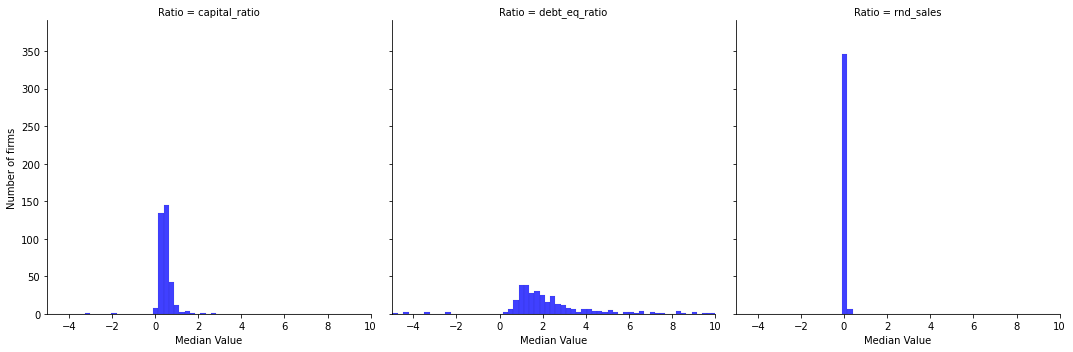

In [155]:
## create the displots from seaborn
ratios_displots_graphs = sns.displot(data=ratios_displots_df, 
                                    x='Median Value',
                                    col='Ratio',
                                    col_wrap=3,
                                    color='blue');

ratios_displots_graphs.set_axis_labels(y_var='Number of firms');

## set a sort of reasonable range we expect from financial ratios (-5 : 10) (this won't affect final analysis results)
## set the ylimits to (0) can't have negative firms and (max) number of firms (~ 360 ish)
ratios_displots_graphs.set(xlim=(-5, 10), 
                          ylim=(0, len(ratio_filtered_data_medians)));

## CLOSER INSPECTION OF A PARTICULAR RATIO
* Obviously, the R&D to sales ratio is exhibiting some serious clustering around 0
    * This would likely indicate the firm doesn't have any expenditure for R&D
    * This might be plausible given the types of the sectors some firms operate in 

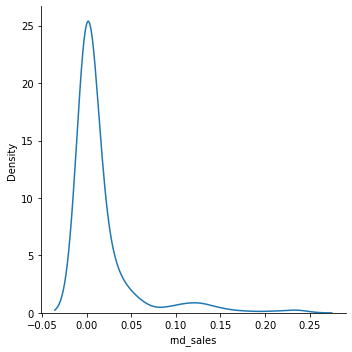

In [156]:
sns.displot(sorted_alldata_df_final_adf_results.groupby('gvkey')['rnd_sales'].median(), 
            kind="kde");

*  The density plot shows pretty heavy clustering of values around the 0 to 0.05 range
*  Indictating either 0 R&D expenditure or very low expenditure
* Additionally, it also shows a few firms which are operating in that > 0.05 range; a breakdown by sector should reveal which types of firms belong to this category

## BREAKDOWN OF RND_SALES BY SECTOR

In [157]:
## create a filtered DF which can be readily applied to the matplotlib's .boxplot functionality
rnd_sales_ratio_df = pd.DataFrame(sorted_alldata_df_final_adf_results[['gvkey','sector','rnd_sales']])

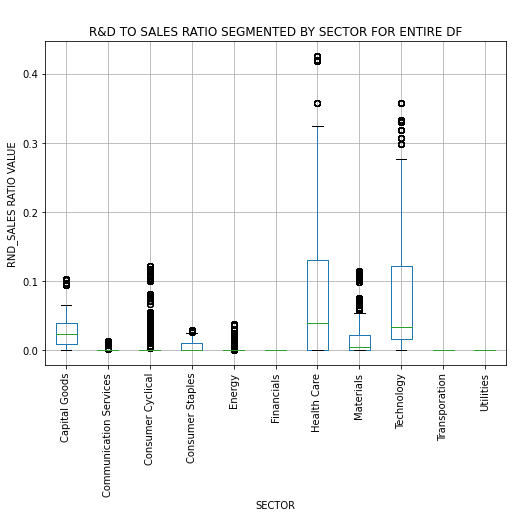

In [158]:
## create the graph object
rnd_sales_sector_breakdown = rnd_sales_ratio_df[['sector','rnd_sales']].boxplot(
by='sector', figsize=(8,6), rot=90);

## label the axes
rnd_sales_sector_breakdown.set_xlabel('SECTOR')
rnd_sales_sector_breakdown.set_ylabel('RND_SALES RATIO VALUE')
rnd_sales_sector_breakdown.set_title("R&D TO SALES RATIO SEGMENTED BY SECTOR FOR ENTIRE DF")

## this removes the default behaviour of boxplot to title the graph with the type (replacing it with nothing)
plt.suptitle(" "); 

## R&D TO SALES BY SECTOR TAKEAWAYS
* The results are fairly in line with that economic theory suggests: firms in sectors with high innovation capacity (Health Care / Technology) have higher R&D to sales ratios vs. typically less dynamic firms (E.G. Transportation / Utilities) which appear to have no firm with an RND_SALES ratio > 0 


# FULL VECM MODEL - DF PICKLE RE-IMPORT
* [full_vecm_model_dataframe_original_location](#vecm_model_results_pickle)

In [160]:
## read in the pickle of the VECM result section
vecm_result_table = pd.read_pickle("./vecm_result_table.pkl")

In [92]:
### first define the series from the main DF (need to preserve the GVKEY to merge onto the VECM results table)
### then can apply the winsorize

## define a ratio series E.G. capital_ratio (median) value by GVKEY
capital_ratio_series = sorted_alldata_df_final_adf_results.groupby('gvkey')['capital_ratio'].median()

## define debt to equity ratio series
debt_equity_ratio_series = sorted_alldata_df_final_adf_results.groupby('gvkey')['debt_eq_ratio'].median()

## define r&d to sales ratio series 
rnd_sales_ratio_series = sorted_alldata_df_final_adf_results.groupby('gvkey')['rnd_sales'].median()

In [93]:
## concatenate the 3 ratio series to facilitate merging onto the results DF 
ratio_series_concatenated = pd.concat([capital_ratio_series, debt_equity_ratio_series, rnd_sales_ratio_series], axis=1)

## merge series with VECM (full-series) results frame
vecm_pd_capital_ratio_df = vecm_result_table.merge(ratio_series_concatenated, how='left', on='gvkey')

## A CASE FOR WINSORIZING THE RATIO VARIABLES
* Re-print the distribution graphs by firm-level ratio, limited to only these VECM viable GVKEYS

* It becomes fairly apparent (primarily from the debt-equity ratio) that there are a very small amount of extreme outliers which might affect the distribution of the segmented (1/3) value bins. 
* It is also noticable that rnd_sales is still heavily clustered around zero
* the capital ratio has been stretched from the shared x-axis parameters but it is inline with financial theory about the usual range of capital ratios. 
    * NOTE: the x-axis limits here will not affect the final results; this graph is purely to provide a graphical interpretation of the data
    
    
####  Thus, a strong case exists to winsor the top and bottom variables to account for these outlier effects 

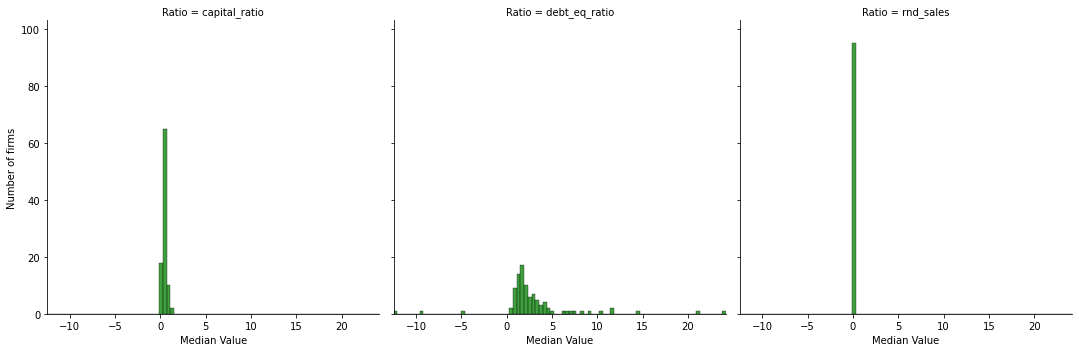

In [94]:
## repeat the distribution breakdowns for purely the VECM viable data

## extract just the GVKEY and the wanted ratios by firm
ratio_filtered_vecm_data = vecm_pd_capital_ratio_df[['gvkey','capital_ratio','debt_eq_ratio','rnd_sales']]

## either overwrite or create a copy which holds the median value of these ratios by GVKEY
ratio_filtered_vecm_data_medians = ratio_filtered_vecm_data.groupby('gvkey').median()

## for the purpose of jointl plotting the ratios, stack the data (into one cont. column) and reset the index
## rename the columns for clarity
ratios_displots_vecm_df =  ratio_filtered_vecm_data_medians.stack().reset_index(level=1).rename(columns={
    'level_1': 'Ratio', 0: 'Median Value'})

## create the displots from seaborn
ratios_displots_graphs_vecmdata = sns.displot(data=ratios_displots_vecm_df, 
                                    x='Median Value',
                                    col='Ratio',
                                    col_wrap=3,
                                    color='green')

ratios_displots_graphs_vecmdata.set_axis_labels(y_var='Number of firms')

## impose the x-axis min and max from the (most) min and max value across the ratios 
## y-axis is still imposed as between 0 and total number of VECM eligible firms ~ 53
xlim_min_vecm_data = min([ratio_filtered_vecm_data_medians['capital_ratio'].min(),
               ratio_filtered_vecm_data_medians['debt_eq_ratio'].min(),
               ratio_filtered_vecm_data_medians['rnd_sales'].min()])

xlim_max_vecm_data = max([ratio_filtered_vecm_data_medians['capital_ratio'].max(),
               ratio_filtered_vecm_data_medians['debt_eq_ratio'].max(),
               ratio_filtered_vecm_data_medians['rnd_sales'].max()])

ratios_displots_graphs_vecmdata.set(xlim=(xlim_min_vecm_data, xlim_max_vecm_data), 
                          ylim=(0, len(ratio_filtered_vecm_data_medians)));

In [95]:
## winsorize each of the ratios (median) series by the top and bottom 10% of observations 
vecm_pd_capital_ratio_df['capital_ratio'] = winsorize(vecm_pd_capital_ratio_df['capital_ratio'], 
                                   limits=[0.10, 0.10])

vecm_pd_capital_ratio_df['debt_eq_ratio'] = winsorize(vecm_pd_capital_ratio_df['debt_eq_ratio'], 
                                   limits=[0.10, 0.10])

vecm_pd_capital_ratio_df['rnd_sales'] = winsorize(vecm_pd_capital_ratio_df['rnd_sales'], 
                                   limits=[0.10, 0.10])

In [97]:
## [optional] bring an overview of the distribution/sizes of the 10% winsored variables into the 1/3 split data groups
print("WINSORED CAPITAL RATIO SPLIT INTO 3 EQUAL BINS LENGTHS", '\n', "--"*25, '\n',
      pd.cut(vecm_pd_capital_ratio_df['capital_ratio'], bins=3).value_counts(), '\n\n', 
     "WINSORED DEBT TO EQUITY RATIO SPLIT INTO 3 EQUAL BINS LENGTHS", '\n', "--"*25, '\n',
     pd.cut(vecm_pd_capital_ratio_df['debt_eq_ratio'], bins=3).value_counts(), '\n\n',
     "WINSORED RND TO SALES RATIO SPLIT INTO 3 EQUAL BINS LENGTHS", '\n', "--"*25, '\n',
     pd.cut(vecm_pd_capital_ratio_df['rnd_sales'], bins=3).value_counts(), '\n')

WINSORED CAPITAL RATIO SPLIT INTO 3 EQUAL BINS LENGTHS 
 -------------------------------------------------- 
 (0.232, 0.498]    53
(0.498, 0.763]    34
(0.763, 1.028]    16
Name: capital_ratio, dtype: int64 

 WINSORED DEBT TO EQUITY RATIO SPLIT INTO 3 EQUAL BINS LENGTHS 
 -------------------------------------------------- 
 (0.963, 5.423]     83
(9.871, 14.318]    14
(5.423, 9.871]      6
Name: debt_eq_ratio, dtype: int64 

 WINSORED RND TO SALES RATIO SPLIT INTO 3 EQUAL BINS LENGTHS 
 -------------------------------------------------- 
 (-0.000123, 0.041]    85
(0.082, 0.123]        11
(0.041, 0.082]         7
Name: rnd_sales, dtype: int64 



In [98]:
## set individual ratio labels by each ratio
cr_labels = ['low_cap_ratio','med_cap_ratio','high_cap_ratio']
debt_equity_labels = ['low_debteq','med_debteq','high_debteq']
rnd_sales_labels = ['low_rndsales', 'med_rndsales', 'high_rndsales']

## a concatenate label series to later append to the final combined DF
labels_concatenated = pd.Series(['low_cap_ratio','med_cap_ratio','high_cap_ratio', 'low_debteq','med_debteq','high_debteq',
                       'low_rndsales', 'med_rndsales', 'high_rndsales'])
                

In [99]:
## create individual objects which split the (HAS) measure into (3) bins based off that GVKEY's firm ratio value
capital_ratio_unstacked = vecm_pd_capital_ratio_df.groupby(['has_outcome',
                                 pd.cut(vecm_pd_capital_ratio_df.capital_ratio, bins=3,
                                       labels=cr_labels)]).size().unstack()

debt_eq_ratio_unstacked = vecm_pd_capital_ratio_df.groupby(['has_outcome',
                                 pd.cut(vecm_pd_capital_ratio_df.debt_eq_ratio, bins=3,
                                       labels=debt_equity_labels)]).size().unstack()

rnd_sales_ratio_unstacked = vecm_pd_capital_ratio_df.groupby(['has_outcome',
                                 pd.cut(vecm_pd_capital_ratio_df.rnd_sales, bins=3,
                                       labels=rnd_sales_labels)]).size().unstack()

In [100]:
## E.G. of the capital ratio results for the HAS PD test, split into each third based off that GVKEYS capital ratio value
capital_ratio_unstacked

capital_ratio,low_cap_ratio,med_cap_ratio,high_cap_ratio
has_outcome,,,
BOND,16,9,1
CDS,37,24,15
EQUAL,0,1,0


In [101]:
## concatenate the (3) variable split on HAS outcome groupby(DFs) objects
## set ignore_index as each object has a different label
ratios_concatenated_raw = pd.concat([capital_ratio_unstacked, debt_eq_ratio_unstacked, rnd_sales_ratio_unstacked], axis=1,
         ignore_index=True).T

## additionally, affix the additional concatenated series of all the labels so it may be set as the index/levels
ratios_concatenated_labeled = pd.concat([ratios_concatenated_raw, labels_concatenated], axis=1, 
         names=['RATIO','BOND','CDS']).set_index(0)

## [optional] create a DF object of it to facilitate printing to latex / renaming columns etc.
ratios_concatenated_labeled_df = pd.DataFrame(ratios_concatenated_labeled)

## properly label the index
ratios_concatenated_labeled_df.index.names = ['RATIO']

## [optional] print a caption 
ratios_concatenated_labeled_df.style.set_caption('HAS PRICE DISCOVERY OUTCOME DISTRIBUTION BY FIRM VARIABLES')

,BOND,CDS,EQUAL
RATIO,,,
low_cap_ratio,16,37,0
med_cap_ratio,9,24,1
high_cap_ratio,1,15,0
low_debteq,25,57,1
med_debteq,0,6,0
high_debteq,1,13,0
low_rndsales,19,65,1
med_rndsales,3,4,0
high_rndsales,4,7,0


* **NOTE: 102 total firms in each ratio segment**


* There are some interesting takeaways, particularly from the rnd_sales ratio. While the distribution is heavily skewed towards the lower end for rnd_sales, in the medium to high tiers, bonds actually have their highest share of contribution towards price discovery out of any of the ratios; albeit, still less than CDS in absolute terms. 
    * An initial intuitive thought behind this is that firms with established R&D divisions (hence medium to high expenditure in this regard) are mature firms. These firms likely have established bond offerings and may be perceived as safer firms by the market; thus, their respective bond series are regarded as more trustworthy channels for price information for these firms relative to newer, less-established firms (represented by low rnd_sales ratios). 
    
    
* A similar train of thought but from a different angle is the higher degree of bond contribution in the low debt to equity ratio segment; potentially suggesting that firms with low debt (perhaps suggesting default is unlikely) tend to have more trusted bond channels then other firms with higher debt ratios (where perhaps, default is seen as more likely). Thus, in the latter case, information pertaining to credit risk with the higher possibility of default is being first discovered in the CDS market. 
    * Further strength is given to this idea if you consider CDS dominates the price discovery process at both the high debt-equity and capital-ratio bins

## [OPTIONAL]  ALTERNATIVE PRESENTATION METHOD TO VIEW MORE DETAILED JOINT DISTRIBUTION OF CDS:BONDS LEADERSHIP ACROSS RATIOS
* Another method of providing a more detailed breakdown of firm distribution jointly across the 3 variables
* E.G. it is possible to cross-sectionally observe the number of CDS series leading the price discovery in the HAS price discovery measure across the 3 sub-categories [capital ratio // debt to equity ratio  //  r&d to sales ratio]

* E.G. within the 3 sub-categories: medium capital ratio / low  debt to equity ratio and low r&d to sales ratio -- the number of CDS leading GVKEYS is (19) and bonds is (8) and (1) is equal. 
    * Similarily, in the highest bin for all 3 ratios, out of the (8) firms in this bracket, (7) favour CDS and (1) favours BONDS. 

In [102]:
## using groupby objects + unstack method + transpose
vecm_pd_capital_ratio_df.groupby(['has_outcome',
                                 pd.cut(vecm_pd_capital_ratio_df.capital_ratio, bins=3,
                                       labels=cr_labels),
                                 pd.cut(vecm_pd_capital_ratio_df.debt_eq_ratio, bins=3,
                                       labels=debt_equity_labels),
                                pd.cut(vecm_pd_capital_ratio_df.rnd_sales, bins=3,
                                       labels=rnd_sales_labels)]).size().unstack(level=['capital_ratio',
                                                                                       'debt_eq_ratio',
                                                                                       'rnd_sales']).T

has_outcome                                 BOND  CDS  EQUAL
capital_ratio  debt_eq_ratio rnd_sales                      
low_cap_ratio  low_debteq    low_rndsales     11   31      0
                             med_rndsales      2    4      0
                             high_rndsales     3    0      0
               med_debteq    low_rndsales      0    1      0
                             med_rndsales      0    0      0
                             high_rndsales     0    0      0
               high_debteq   low_rndsales      0    1      0
                             med_rndsales      0    0      0
                             high_rndsales     0    0      0
med_cap_ratio  low_debteq    low_rndsales      8   19      1
                             med_rndsales      1    0      0
                             high_rndsales     0    0      0
               med_debteq    low_rndsales      0    3      0
                             med_rndsales      0    0      0
                             high_rndsales     0    0      0
               high_debteq   low_rndsales      0    2      0
                             med_rndsales      0    0      0
                             high_rndsales     0    0      0
high_cap_ratio low_debteq    low_rndsales      0    3      0
                             med_rndsales      0    0      0
                             high_rndsales     0    0      0
               med_debteq    low_rndsales      0    2      0
                             med_rndsales      0    0      0
                             high_rndsales     0    0      0
               high_debteq   low_rndsales      0    3      0
                             med_rndsales      0    0      0
                             high_rndsales     1    7      0

<a id='oos_vecm_fitting'></a>


## ROBUSTNESS CHECK: OUT OF SAMPLE FIT TESTING

* We examine the strength of the bivariate VECM model framework to assess whether it has any predictive power in predicting future asset prices (either CDS/PECDS value for BONDS)
* Given the derivative nature of how the PECDS value is calculated, it has been included for curiosity, however the predictive power of the model is focused around the CDS spread. 



In [114]:
%%time

warnings.filterwarnings("ignore") 

## initialise dictionary 
bivariate_vecm_oos_dict = collections.defaultdict(list)

## define the different lengths to test: 85% of the DF == 15% out-of-sample forecast, 90%=10% OOS, etc.
out_of_sample_tests =[85, 90, 95, 99]

## FILTER THE ORIGINAL FRAME TO INCLUDE ONLY THOSE FIRMS WITH COINT RANK == 1, then apply model loop  
for i, val in enumerate(sorted_alldata_df_final_adf_results.loc[(
    sorted_alldata_df_final_adf_results.coint_rank==float(1.0))].groupby('gvkey')):    
    
    gvkey = val[0]
    data = val[1]
    sector_string = data.sector

    ## append the usual identifying information 
    bivariate_vecm_oos_dict['gvkey'].append(gvkey)
    bivariate_vecm_oos_dict['sector'].append(sector_string.iloc[0]) 
    
    ## load the data to create the model for each GVKEY/LOOP
    cds = data.market_cds_spread
    pecds = data.pecds
    
    ## for each different series length among the 4 (above-specified) options
    for i in out_of_sample_tests:
    
        ## reconstruct the base DF so that the loop correctly iterates
        vecm_data = pd.DataFrame(data=(cds, pecds)).T

        ## restrict the in-sample VECM model to be less than the specified (i) (in-sample length)
        vecm_data = vecm_data[(vecm_data.index <= np.floor(np.percentile(vecm_data.index, i)))]
        
        try:

            ## create the model instance which holds the optimal lag order (including the BIC)
            vecm_model_order = vecm.select_order(vecm_data, maxlags=10)

            ## create the VECM model instance
            ## note -- cointegration rank is set to int(1) as the DF has already been restricted to coint_rank == 1 above
            vecm_regression_model = vecm.VECM(vecm_data, 
                                              k_ar_diff=vecm_model_order.bic, 
                                              coint_rank=1, 
                                              deterministic='co')

            ## seperate the base model and the fit, otherwise the loop won't properly update for each iteration
            vecm_reg_fitted = vecm_regression_model.fit()
                  
            ## define the length of the prediction (out-of-sample) for each VECM model 
            prediction_window = len(cds) - vecm_reg_fitted.nobs

            ## slice the jointly predicted VECM array into the CDS[:0] and BOND[:,1] slices respectively 
            cds_predicted = vecm_reg_fitted.predict(prediction_window)[:,0]
            bond_predicted = vecm_reg_fitted.predict(prediction_window)[:,1]

            ## grab the actual series from the original data which is beyond the specified sample window size
            cds_actual = cds[(cds.index > np.floor(np.percentile(cds.index, i)))]
            bond_actual = pecds[(pecds.index > np.floor(np.percentile(pecds.index, i)))]

            ## due to some rounding errors at some point in the slicing, the length of the two series may mis-align
            ## thus, depending on which series has rounded-up or down, reduce one array to match the other
            if len(cds_actual) > len(cds_predicted):   
                while len(cds_actual) > len(cds_predicted):
                    cds_actual = cds_actual[:-1]
            else:
                while len(cds_actual) < len(cds_predicted):
                    cds_predicted = cds_predicted[:-1]

                    
            ####  repeat for bonds  #####        
            if len(bond_actual) > len(bond_predicted):   
                while len(bond_actual) > len(bond_predicted):
                    bond_actual = bond_actual[:-1]
            else:
                while len(bond_actual) < len(bond_predicted):
                    bond_predicted = bond_predicted[:-1]                    
                    

            ## calculate the MAPE
            ## NOTE: squared=False, returns MAPE; if==True, returns MSE.
            mape_iteration_cds = mean_squared_error(cds_actual, cds_predicted, squared=False)
            mape_iteration_bond = mean_squared_error(bond_actual, bond_predicted, squared=False)

            ## pre-round the values (optional)
            mape_iteration_cds = np.round(mape_iteration_cds, 2)
            mape_iteration_bond = np.round(mape_iteration_bond, 2)
            
            ## append outcome based off iteration sequence (85, 90, 95, 99)
            if i==out_of_sample_tests[0]:
                
                ## use this code to print in table publication ready format with (%) attached
                #bivariate_vecm_oos_dict['CDS_MAPE_85'].append("{:.2%}".format(mape_iteration_cds/100))
                #bivariate_vecm_oos_dict['BOND_MAPE_85'].append("{:.2%}".format(mape_iteration_bond/100))
                
                ##else print with numeric dtypes
                bivariate_vecm_oos_dict['CDS_MAPE_85'].append(mape_iteration_cds)
                bivariate_vecm_oos_dict['BOND_MAPE_85'].append(mape_iteration_bond)

            elif i==out_of_sample_tests[1]:
                #bivariate_vecm_oos_dict['CDS_MAPE_90'].append("{:.2%}".format(mape_iteration_cds/100))
                #bivariate_vecm_oos_dict['BOND_MAPE_90'].append("{:.2%}".format(mape_iteration_bond/100))
                
                bivariate_vecm_oos_dict['CDS_MAPE_90'].append(mape_iteration_cds)
                bivariate_vecm_oos_dict['BOND_MAPE_90'].append(mape_iteration_bond)                

            elif i==out_of_sample_tests[2]:
                #bivariate_vecm_oos_dict['CDS_MAPE_95'].append("{:.2%}".format(mape_iteration_cds/100))
                #bivariate_vecm_oos_dict['BOND_MAPE_95'].append("{:.2%}".format(mape_iteration_bond/100))  
                
                bivariate_vecm_oos_dict['CDS_MAPE_95'].append(mape_iteration_cds)
                bivariate_vecm_oos_dict['BOND_MAPE_95'].append(mape_iteration_bond)                

            else:
                #bivariate_vecm_oos_dict['CDS_MAPE_99'].append("{:.2%}".format(mape_iteration_cds/100))
                #bivariate_vecm_oos_dict['BOND_MAPE_99'].append("{:.2%}".format(mape_iteration_bond/100))
                
                bivariate_vecm_oos_dict['CDS_MAPE_99'].append(mape_iteration_cds)
                bivariate_vecm_oos_dict['BOND_MAPE_99'].append(mape_iteration_bond)                
                
                
        ## append the errors to the respective (i) column from that respective (i)-length VECM model 
        except ValueError as ve_vecm:
            print(ve_vecm.args, "GVKEY: {}, ITERATION LENGTH: {}".format(gvkey, i))
            
            if i==out_of_sample_tests[0]:
                bivariate_vecm_oos_dict['CDS_MAPE_85'].append(np.nan)
                bivariate_vecm_oos_dict['BOND_MAPE_85'].append(np.nan)

            elif i==out_of_sample_tests[1]:
                bivariate_vecm_oos_dict['CDS_MAPE_90'].append(np.nan)
                bivariate_vecm_oos_dict['BOND_MAPE_90'].append(np.nan)

            elif i==out_of_sample_tests[2]:
                bivariate_vecm_oos_dict['CDS_MAPE_95'].append(np.nan)
                bivariate_vecm_oos_dict['BOND_MAPE_95'].append(np.nan)  

            else:
                bivariate_vecm_oos_dict['CDS_MAPE_99'].append(np.nan)
                bivariate_vecm_oos_dict['BOND_MAPE_99'].append(np.nan)


## construct the DF from the the dictionary     
bivariate_vecm_oos_df_results = pd.DataFrame.from_dict(bivariate_vecm_oos_dict)

## note: 
## this method of DF construction requires the arrays to all be of the same-length, check by: 
## [len(x) for k, x in bivariate_vecm_oos_dict.items()]


("x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.",) GVKEY: 10247, ITERATION LENGTH: 85
("x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.",) GVKEY: 10247, ITERATION LENGTH: 90
("x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.",) GVKEY: 10247, ITERATION LENGTH: 95
("x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.",) GVKEY: 10247, ITERATION LENGTH: 99
("x contains one or more constant columns. Column(s) 0 are constant. Adding a constant with trend='c' is not allowed.",) GVKEY: 144559, ITERATION LENGTH: 85
Wall time: 38.1 s


In [124]:
bivariate_vecm_oos_df_results.head()

,gvkey,sector,CDS_MAPE_85,BOND_MAPE_85,CDS_MAPE_90,BOND_MAPE_90,CDS_MAPE_95,BOND_MAPE_95,CDS_MAPE_99,BOND_MAPE_99
0,1045,Transporation,450.13,4.80,304.88,3.68,172.04,2.10,43.39,0.48
1,1356,Materials,156.14,12.10,138.21,14.95,137.49,7.79,12.74,3.77
2,1919,Technology,40.93,5.65,27.36,5.28,34.03,2.19,5.57,0.10
3,1976,Energy,1.38,1.03,2.57,0.80,2.60,0.71,1.73,0.12
4,2055,Materials,0.01,26.89,0.01,30.76,0.01,0.39,0.00,0.24


In [122]:
## show sector sizes
bivariate_vecm_oos_df_results.groupby('sector')['gvkey'].nunique()

sector
Capital Goods             12
Communication Services     2
Consumer Cyclical         11
Consumer Staples          20
Energy                     6
Financials                11
Health Care                5
Materials                 16
Technology                 6
Transporation              6
Utilities                  7
Name: gvkey, dtype: int64

## INSPECTING THE MEAN AVERAGE PERCENT ERROR (MAPE) BY SECTOR FOR BOTH CDS AND BOND(PECDS) OUT-OF-SAMPLE FORECASTING
* A brief glance at even the upper range (99%) in the mean choses that even a 1%-length forecast has a large degree of error
    * As you zoom out, the margin of error at even the 95% range becomes absurdly large

* The initial results would strongly suggest the bivariate VECM model is not suitable for predicting future assetprices / finding trading opportunities 


In [157]:
np.round(bivariate_vecm_oos_df_results.groupby('sector')[bivariate_vecm_oos_df_results.columns[2:].values.tolist()].mean(),2)

,CDS_MAPE_85,BOND_MAPE_85,CDS_MAPE_90,BOND_MAPE_90,CDS_MAPE_95,BOND_MAPE_95,CDS_MAPE_99,BOND_MAPE_99
sector,,,,,,,,
Capital Goods,19.65,20.77,22.70,20.66,19.30,12.66,5.25,6.99
Communication Services,12.27,35.69,10.06,14.27,8.32,19.97,2.70,0.52
Consumer Cyclical,379.04,10.57,407.40,8.50,616.36,6.39,74.32,0.97
Consumer Staples,29.37,17.70,26.15,13.27,22.17,13.98,5.87,5.09
Energy,12211.50,50.21,121.27,12.11,43.54,11.90,24.98,2.92
Financials,55.29,13.26,35.48,8.86,18.18,6.95,6.87,1.11
Health Care,31.45,10.51,53.73,13.11,16.57,16.67,14.58,11.42
Materials,277.45,14.21,149.71,13.18,269.26,7.43,35.06,1.13
Technology,49.46,31.25,18.91,18.22,23.00,20.74,12.46,7.19


* Inspecting whether this is the result of outliers or not, the median is shown as well by sector
    * Particularly for CDS, the median values for MAPE are extremely large, and well outside any feasible parameter to utilise the bivariate VECM model for forecasting

In [156]:
np.round(bivariate_vecm_oos_df_results.groupby('sector')[bivariate_vecm_oos_df_results.columns[2:].values.tolist()].median(),2)

,CDS_MAPE_85,BOND_MAPE_85,CDS_MAPE_90,BOND_MAPE_90,CDS_MAPE_95,BOND_MAPE_95,CDS_MAPE_99,BOND_MAPE_99
sector,,,,,,,,
Capital Goods,6.28,19.94,4.85,9.72,2.60,4.76,0.84,1.10
Communication Services,12.27,35.69,10.06,14.27,8.32,19.97,2.70,0.52
Consumer Cyclical,38.82,9.14,35.04,6.48,18.72,4.98,7.08,0.34
Consumer Staples,10.39,13.61,9.21,7.41,5.85,6.67,2.07,0.62
Energy,47.62,10.72,24.39,10.09,27.04,8.22,9.34,1.45
Financials,25.94,7.71,25.82,5.93,11.35,2.09,4.11,0.44
Health Care,19.12,7.49,10.28,9.16,2.68,9.68,4.02,2.37
Materials,13.32,12.52,15.06,10.86,12.42,6.43,5.36,0.38
Technology,34.98,33.12,18.32,5.25,27.16,5.07,6.97,0.87


<a id='ovb_analysis'></a>

## OMITTED VARIABLE ANALYSIS 
* We extend slightly on the idea that the bivariate VECM model is insufficient for forecasting future asset prices / trading-- thus, we examine if other exogenous factors can be incorporated into the model to provide superior performance


* Initially, we extend the VAR framework to include daily closing stock price and the VIX to determine whether other variables have a significant impact on CDS-BOND system.

### GRANGER CAUSALITY TEST SPECIFICATIONS 
* Only some causal relationships are supported by theory; consequently, not all relationships will be tested
    * For example, it makes sense for the VIX to potentially influence stock closing prices (as an aggregate measure can trickle down / the VIX is in a sense related to stock closing prices already through the derivatives market)
        * However, it is not logically feasible to presume individual stock closing prices in this sample could influence the VIX; as such, this relationship is not tested.

In [36]:
%%time 

warnings.filterwarnings("ignore") 

## initialise the dictionary
granger_causality_dict_4v = collections.defaultdict(list)

## initialise error counters by type
dfgls_errors_s1 = 0
dfgls_errors_s2 = 0
error_counter_var = 0

## problem instances ##
unique_gct_4v_problem_instances = []

## initialise a counter by stationarity-level
in_levels_counter = 0
first_dif_counter = 0
first_dif_not_stat = 0
                              
## run the regression loop by GVKEY group:
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):  
    gvkey = val[0]
    data = val[1]
    granger_causality_dict_4v['gvkey'].append(gvkey)  
    sector_string = data.sector
    granger_causality_dict_4v['sector'].append(sector_string.iloc[0]) 
    
    cointegration_rank = data.coint_rank
    granger_causality_dict_4v['coint_rank'].append(cointegration_rank.iloc[0])
    
    ## generate the series items 
    cds = data.market_cds_spread 
    pecds = data.pecds
    vix = data.cboe_vix
    stock_close = data.price_close

    ## if there are any missing stock_close values from Wharton Data Services
    ## ffill with the most recent values, limit to one trading week max of missing data
    if stock_close.isna().any() == True:
        stock_close = stock_close.fillna(method='ffill', limit=5)  
        
    try: 
        try:
            
            dfgls_cds = DFGLS(cds, trend='c', max_lags=10, method='BIC')
            dfgls_pecds = DFGLS(pecds, trend='c', max_lags=10, method='BIC')
            dfgls_vix = DFGLS(vix, trend='c', max_lags=10, method='BIC')
            dfgls_stock_close = DFGLS(stock_close, trend='c', max_lags=10, method='BIC')
            
        except (ValueError, np.linalg.LinAlgError, InfeasibleTestException) as dfgls_errors_s1:
            dfgls_errors_s1 += 1    
            
            granger_causality_dict_4v['bond_on_cds'].append("DFGLS_ERR_S1")
            granger_causality_dict_4v['cds_on_bond'].append("DFGLS_ERR_S1")
            granger_causality_dict_4v['vix_stock_on_cds'].append("DFGLS_ERR_S1")
            granger_causality_dict_4v['vix_stock_on_bond'].append("DFGLS_ERR_S1")    
            granger_causality_dict_4v['vix_on_stock'].append("DFGLS_ERR_S1")
            granger_causality_dict_4v['vix_stock_corr'].append("DFGLS_ERR_S1")
            
        if ((dfgls_cds.stat < dfgls_cds.critical_values['5%']) and 
         (dfgls_pecds.stat < dfgls_pecds.critical_values['5%']) and 
         (dfgls_vix.stat < dfgls_vix.critical_values['5%']) and 
         (dfgls_stock_close.stat < dfgls_stock_close.critical_values['5%'])) == True:

            ## initialise the DF in levels
            var_model_df_4v = pd.DataFrame(data=(cds, pecds, vix, stock_close)).T

            in_levels_counter += 1

        else:
        
            ## take first differences of each series & re-run the DFGLS tests
            cds = cds.pct_change().dropna()
            pecds = pecds.pct_change().dropna()
            vix = vix.pct_change().dropna()
            stock_close = stock_close.pct_change().dropna()

            try:
                dfgls_cds = DFGLS(cds, trend='c', max_lags=10, method='BIC')
                dfgls_pecds = DFGLS(pecds, trend='c', max_lags=10, method='BIC')
                dfgls_vix = DFGLS(vix, trend='c', max_lags=10, method='BIC')
                dfgls_stock_close = DFGLS(stock_close, trend='c', max_lags=10, method='BIC')
                 
                
            except (ValueError, np.linalg.LinAlgError, InfeasibleTestException) as dfgls_errors_second_diff:
                dfgls_errors_s2 += 1
                 
            
            ## re-check for stationarity
            if ((dfgls_cds.stat < dfgls_cds.critical_values['5%']) and 
             (dfgls_pecds.stat < dfgls_pecds.critical_values['5%']) and 
             (dfgls_vix.stat < dfgls_vix.critical_values['5%']) and 
             (dfgls_stock_close.stat < dfgls_stock_close.critical_values['5%'])) == True:
                
                ## initialise the DF in (1st) differences
                var_model_df_4v = pd.DataFrame(data=(cds, pecds, vix, stock_close)).T

                first_dif_counter += 1
                
            else:

                ## update counter for GVKEY groups with non-stationary first differences
                first_dif_not_stat += 1
                    
        ## run the model # #
        model = smt.VAR(var_model_df_4v)
                    
        max_lags_bic = model.select_order(maxlags=10).bic

        ## hard enforce a minimum of (1) lags -- avoids GCT errors
        ## won't affect the sign of the GCT outcome as artificial lag length will evaulate to not-significant
        if max_lags_bic == 0:
            max_lags_bic = 1

        res = model.fit(maxlags=max_lags_bic)

        ## test bonds on CDS causality ## 
        res_causality_bond = res.test_causality(causing=['pecds'], 
            caused=['market_cds_spread'], kind='wald', signif=0.05)  

        ## test CDS on bonds causality ## 
        res_causality_cds = res.test_causality(causing=['market_cds_spread'], 
            caused=['pecds'], kind='wald', signif=0.05) 

        ## test VIX / Stock Closing Price Jointly on CDS causality ## 
        res_causality_vixstock_cds = res.test_causality(causing=['cboe_vix','price_close'], 
            caused=['market_cds_spread'], kind='wald', signif=0.05) 

        ## test VIX / Stock Closing Price Jointly on PECDS causality ##
        res_causality_vixstock_bond = res.test_causality(causing=['cboe_vix','price_close'], 
            caused=['pecds'], kind='wald', signif=0.05)

        ## test VIX on closing price ##
        res_causality_vix_on_stock = res.test_causality(causing=['cboe_vix'], 
            caused=['price_close'], kind='wald', signif=0.05) 

        ## calculate spearmanr coefficient of VIX / stock_close ## 
        vix_stock_close_spearman_corr = np.round(stats.spearmanr(vix, stock_close), 4)

        ## append items only after all GRANGER CAUSALITY TESTS ARE CONFIRMED
        granger_causality_dict_4v['vix_on_stock'].append(res_causality_vix_on_stock.conclusion)
        
        #granger_causality_dict_4v['vix_on_stock_stat'].append(np.round(res_causality_vix_on_stock.test_statistic,4))
        
        granger_causality_dict_4v['vix_stock_on_bond'].append(res_causality_vixstock_bond.conclusion)
        granger_causality_dict_4v['vix_stock_on_cds'].append(res_causality_vixstock_cds.conclusion)
        granger_causality_dict_4v['cds_on_bond'].append(res_causality_cds.conclusion)
        granger_causality_dict_4v['bond_on_cds'].append(res_causality_bond.conclusion)
        granger_causality_dict_4v['vix_stock_corr'].append(vix_stock_close_spearman_corr[0])     
        
    except (ValueError, np.linalg.LinAlgError, InfeasibleTestException) as vme:
        
        ## print only unique/novel model errors the first time they are encountered
        var_model_err_instance = str(vme.args)
        if var_model_err_instance not in unique_gct_4v_problem_instances:
            print("NOVEL VAR MODEL ERROR- ROW: {}, GVKEY: {}, REASON: {}".format(i, gvkey, vme), '\n')
            unique_gct_4v_problem_instances.append(var_model_err_instance)
        
        error_counter_var +=1 
        
        ## append place holder NaN to the lists 
        granger_causality_dict_4v['bond_on_cds'].append(np.nan)
        granger_causality_dict_4v['cds_on_bond'].append(np.nan)
        granger_causality_dict_4v['vix_stock_on_cds'].append(np.nan)
        granger_causality_dict_4v['vix_stock_on_bond'].append(np.nan)    
        granger_causality_dict_4v['vix_on_stock'].append(np.nan)
        granger_causality_dict_4v['vix_stock_corr'].append(np.nan)     
            
## construct the DF         
granger_causality_4v_df = pd.DataFrame.from_dict(granger_causality_dict_4v)        

print("  DFGLS Errors from in-levels: {}".format(dfgls_errors_s1),'\n', 
      " DFGLS Errors from 1st-Differences: {}".format(dfgls_errors_s2),'\n',   
     " VAR MODEL ERRORS: {}".format(error_counter_var), '\n', "--"*25, '\n', 
      "in levels counter: {}".format(in_levels_counter), '\n', 
      "first_dif_counter: {}".format(first_dif_counter), '\n', 
     "first differences not stationary: {}".format(first_dif_not_stat), '\n', "--"*25)       
        


NOVEL VAR MODEL ERROR- ROW: 24, GVKEY: 2085, REASON: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 521 and the array at index 1 has size 0 

NOVEL VAR MODEL ERROR- ROW: 60, GVKEY: 3416, REASON: SVD did not converge in Linear Least Squares 

NOVEL VAR MODEL ERROR- ROW: 105, GVKEY: 5671, REASON: The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after including 0 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models. 

NOVEL VAR MODEL ERROR- ROW: 179, GVKEY: 8551, REASON: The maximum lag you are considering (10) results in an ADF regression with a
singular regressor matrix after including 2 lags, and so a specification test be
run. This may occur if your ser

In [45]:
## E.G. of cointegration rank = 1 for the 4V GCT
granger_causality_4v_df.head()

,gvkey,sector,coint_rank,vix_on_stock,vix_stock_on_bond,vix_stock_on_cds,cds_on_bond,bond_on_cds,vix_stock_corr
0,1045,Transporation,1.0,fail to reject,fail to reject,fail to reject,fail to reject,fail to reject,-0.3603
1,1078,Health Care,0.0,fail to reject,fail to reject,fail to reject,fail to reject,fail to reject,-0.4363
2,1161,Technology,0.0,fail to reject,fail to reject,reject,fail to reject,fail to reject,-0.3671
3,1209,Materials,0.0,fail to reject,fail to reject,reject,fail to reject,fail to reject,-0.5736
4,1300,Capital Goods,0.0,fail to reject,fail to reject,reject,reject,fail to reject,-0.6388


In [90]:
## GCT = Granger Causality Tests

print("NUMBER OF REJECTED GCT FOR VIX & STOCK CLOSING PRICE JOINTLY IMPACTING CDS SPREAD: {}".format(
    len(granger_causality_4v_df.loc[granger_causality_4v_df.vix_stock_on_cds=='reject'])), '\n', "--"*45)

print("NUMBER OF REJECTED GCT FOR VIX & STOCK CLOSING PRICE JOINTLY IMPACTING BOND YIELD: {}".format(
    len(granger_causality_4v_df.loc[granger_causality_4v_df.vix_stock_on_bond=='reject'])), '\n', "--"*45)

print("NUMBER OF REJECTED GCT FOR VIX ON STOCK CLOSING PRICE: {}".format(
    len(granger_causality_4v_df.loc[granger_causality_4v_df.vix_on_stock=='reject'])), '\n', "--"*45)

print("NUMBER OF REJECTED GCT FOR CDS ON BOND IN 4V SPECIFICATION: {}".format(
    len(granger_causality_4v_df.loc[granger_causality_4v_df.cds_on_bond=='reject'])), '\n', "--"*45)

print("NUMBER OF REJECTED GCT FOR BOND ON CDS IN 4V SPECIFICATION: {}".format(
    len(granger_causality_4v_df.loc[granger_causality_4v_df.bond_on_cds=='reject'])))

NUMBER OF REJECTED GCT FOR VIX & STOCK CLOSING PRICE JOINTLY IMPACTING CDS SPREAD: 217 
 ------------------------------------------------------------------------------------------
NUMBER OF REJECTED GCT FOR VIX & STOCK CLOSING PRICE JOINTLY IMPACTING BOND YIELD: 18 
 ------------------------------------------------------------------------------------------
NUMBER OF REJECTED GCT FOR VIX ON STOCK CLOSING PRICE: 45 
 ------------------------------------------------------------------------------------------
NUMBER OF REJECTED GCT FOR CDS ON BOND IN 4V SPECIFICATION: 14 
 ------------------------------------------------------------------------------------------
NUMBER OF REJECTED GCT FOR BOND ON CDS IN 4V SPECIFICATION: 26


## BRIEF RESULTS SUMMARY
* The CDS-BOND Granger Causality Outcomes have flipped somewhat
    * It was 29 favouring CDS to 22 favouring BONDS in the pure 2-series VAR framework above
    * Bonds now have more causality, albeit only +4, but CDS causality has fallen by over half.
    * This generally favours the idea that when the BOND series leads, there may be other factors (E.G. aggregate market conditions, firm capitalisation, credit quality) which mean the BOND series has distinct regimes in which it leads the price discovery process VS. CDS which is more volatile in this regard
    
    
* This idea is further reinforced by the large number (217) of joint VIX / STOCK CLOSE rejections on CDS; meaning these variables may have a large degree of inter-causality.
* The (45) rejections of VIX on stock should be examined more closely -- see graph below
    * As below, there are a reasonable number of exceptions by sector; most importantly, the bulk of the rejections are occuring in consumer staples, which tends to be a "safer" stock sector in times of higher volatility. This could partially explain the number of rejections of VIX on stock closing prices

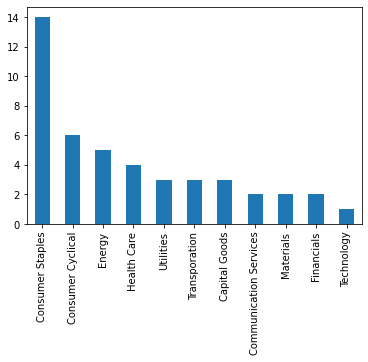

In [47]:
## filter the original dataframe on rejects for the vix on stock
gct_vix_on_stock_rejects = granger_causality_4v_df.loc[granger_causality_4v_df.vix_on_stock=='reject']

## plot by sector on a histogram
gct_vix_on_stock_rejects['sector'].value_counts().plot(kind='bar');

#### ADD COINTEGRATION VS. NO-COINTEGRATION COMPARISON
* Filtering the number of rejections by cointegration vs no-cointegration, still broken down by sector, the results seems to be fairly evenly distributed by sector. 
* Thus, the tendency for rejection by any sector appears to have little bearing on whether the GVKEYs in that sector where cointegrated or not. 

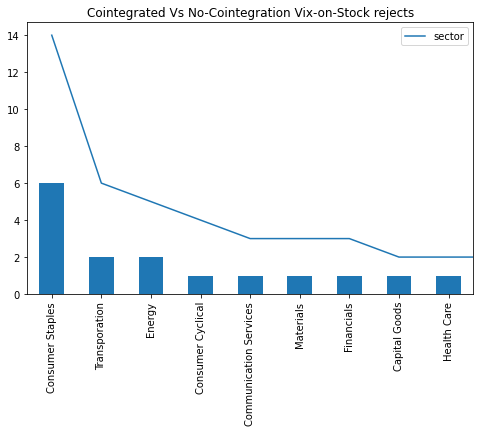

In [67]:
gct_4v_cointegrated = granger_causality_4v_df.loc[granger_causality_4v_df.coint_rank==1]

cointegration_vixstk = gct_4v_cointegrated.loc[gct_4v_cointegrated.vix_on_stock=='reject']

coint_vikstk_rejects = cointegration_vixstk['sector'].value_counts().plot(kind='bar', figsize=(8, 5))
total_vixstk_rejects = gct_vix_on_stock_rejects['sector'].value_counts().plot(kind='line', 
                                        title='Cointegrated Vs No-Cointegration Vix-on-Stock rejects',
                                                                              use_index=False,
                                                                              legend=True)

plt.xticks(rotation=90);


<a id='appendix_a'></a>

# APPENDIX (A): SINGLE GVKEY QUICK REGRESSION COMPILER
    * This function performs virtually all of the statistical tests in the main body (unit root tests / VAR / (full) VECM models, with the relevant visual aids to create a quick and easy overview to understand the process of going from the base data through to a valid end result

  
    Returns all the key statistical tests and regressions models conducted on the entire data sample in the main project.
    This function will run identical test specifications but pertaining only to a single specified GVKEY. 
    
    Parameters
    ----------
    gvkey_selection: int 
        The selected GVKEY (unique group identifier)
    dataframe: 
        The DataFrame which contains the relevant GVKEY's CDS and PECDS data series
    data_series: array_like
        The chosen primary data series to display summary statistics for
    graphs: bool, optional
        Will display data series with known breakpoints in graphical form
    unit_root_tests: bool, optional
        Will return the ADF and DFGLS unit root test results on the selected [data_series]
    vr_ratio: bool, optional
        Will return the Variance Ratio test on the selected [data_series]
    vr_ratio_increment: int, optional
        The size of the Variance Ratio increments to conduct the joint variance tests on. Default is 2.5%
    za_test: bool, optional
        Will return the results of the Zivot Andrews Breakpoint test
    vecm_model: bool, optional
        Will return the results of the Vector Error Correction Model and Granger Causality Test Results within the 
        VECM framework
        Associated price discovery leadership methods (GG and HAS measures) are also included.

### E.G. GVKEY = 1045

In [8]:
from single_gvkey_model_outcomes_compiler import * 

C:\Users\JasonSpano\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 ---------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------- 
 //////////////////// << SUMMARY MODEL OUTCOMES VIEWER >>  //////////////////  
 ---------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------- 

+------------------+-----------------------------+
| SELECTED GVKEY:  |            1045             |
+------------------+-----------------------------+
|   COMPANY NAME   | AMERICAN AIRLINES GROUP INC |
|  COMPANY SECTOR  |        Transporation        |
|     BOND ID      |           AMR.UY            |
+------------------+-----------------------------+
+---------------------+-------------------+
|  SELECTED SERIES:   | MARKET_CDS_SPREAD |
+---------------------+-------------------+
|      TOTAL OBS      |        546        |
|      FIRST OBS      |    2009-09-24     |
|      LAST OBS       |  

C:\Users\JasonSpano\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


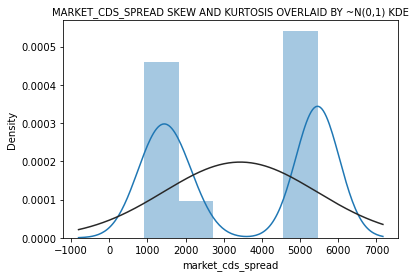


 ---------------------------------------------------------------------------- 
 UNIT ROOT TESTS
+------------+-----------+------------+-----------------------------------+
| TEST TYPE  | TEST STAT | TEST 5% CV |           TEST OUTCOME            |
+------------+-----------+------------+-----------------------------------+
|  ADF TEST  |  -1.0259  |   -2.867   | The process contains a unit root. |
| DFGLS TEST |  -0.2413  |  -1.9826   | The process contains a unit root. |
+------------+-----------+------------+-----------------------------------+

 ----------------------------------------------------------------------------
 VARIANCE RATIO
+----------------+--------+
| VARIANCE RATIO |  1.02  |
|  VR TEST STAT  |  0.96  |
|   VR P-VALUE   | 0.3392 |
|  VR LAGS USED  |   13   |
+----------------+--------+
VR TEST-STATISTIC CONCLUSION:  The process is a random walk. 
 ----------------------------------------------------------------------------

 ------------------------------------------

C:\Users\JasonSpano\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:1109: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))


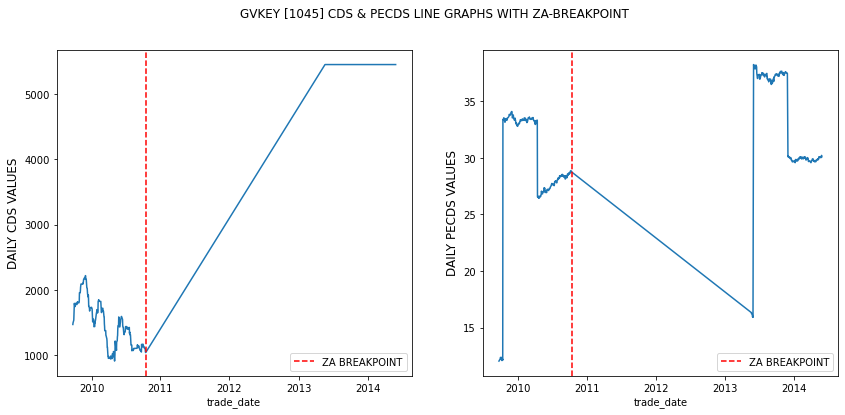

In [9]:
single_series_model_outcomes_and_summary_statistics(gvkey_selection=1045, 
                                                    dataframe=sorted_alldata_df_final_adf_results,
                                                    data_series='market_cds_spread', 
                                                    graphs='yes', 
                                                    vr_ratio_increment=0.025,
                                                    unit_root_tests='yes', 
                                                    vr_ratio='yes', 
                                                    za_test='yes', 
                                                    vecm_model='yes')

<a id='appendix_b'></a>

# APPENDIX (B): REFERENCES


Alexander, C., & Kaeck, A. (2008). Regime dependent determinants of credit default swap spreads. Journal of banking & finance, 32(6), 1008-1021.

Bai, J., & Collin-Dufresne, P. (2011). The determinants of the CDS-bond basis during the financial crisis of 2007-2009. Columbia University, Working Paper.

Bai, J., & Dufresne, P. C. (2019). The CDS-bond basis. Financial Management 48, 417-439.

Blanco, R., Brennan, S., & Marsh, I. W. (2005). An Empirical Analysis of the Dynamic Relation between Investment-Grade Bonds and Credit Default Swaps. The Journal of Finance 60, 2255-2281.

Chalamandaris, G., & Pagratis, S. (2019). Limits to arbitrage and CDS-bond dynamics around the financial crisis. Journal of Empirical Finance, 54, 213-235.

De Wit, J. (2006). Exploring the CDS-bond Basis. National Bank of Belgium.

Dickey, D., & Fuller, W. (1979). Distribution of the estimators for autoregressive time series with a unit root (Vol. 74). J. Am. Statist. Assoc.

Dotz, N. (2007). Time-varying contributions by the corporate bond and CDS markets to credit risk price discovery. Working Paper, Deutsche Bank.

Duffie, D. (1999). Credit Swap Valuation. Financial analysts journal, 73-87.

Elizalde, Abel, Doctor, S., & Saltuk, Y. (2009). Bond-CDS Basis Handbook: Measuring, Trading, and Analysing Basis Trades. J.P. Morgan Credit Derivatives Research.

Engle, R. F., & Granger, C. (1987). Co-Integration and error correction: representation, estimation and testing. Econometrica, 251-276.

Fontana, A. (2010). The Persistent Negative Cds-Bond Basis during the 2007/08 Financial Crisis. Venice: Department of Economics, University of Venice.

Gonzalo, J., & Granger, C. (1995). Estimation of common long-memory components in cointegrated systems. Journal of business & economic statistics, 27-36.

Granger, C. (1969). Investigating Causal Relations by Econometric Models and Cross-spectral Methods. Econometrica, 424-438.
Gromb, D., & Vayanos, D. (2010). Limits of Arbitrage. The annual review of financial economics, 51-75.

Guesmi, S., Ben-Abdallah, R., Breton, M., & Dionne, G. (2019). The CDS-Bond Basis: Negativity Persistence and Limits to Arbitrage. Canadian Derivatives Institute. Montreal: CIRRELT.

Gyntelberg, J., Hordahl, P., Ters, K., & Urban, J. (2017). Arbitrage costs and the persistent non-zero CDS-bond basis: Evidence from intraday euro area sovereign debt markets. Monetary and Economic Department. Switzerland: Bank for International Settlements.

Hasbrouck, J. (1995). One Security, Many Markets: Determining the Contributions to Price Discovery. Journal of Finance, 1175-1199.

Houweling, P., & Vorst, T. (2002). An Empirical Comparison of Default Swap Pricing Models. ERIM Report Series(ERS-2002-23-F&A), 1-55.

Hull, J., Predescu, M., & White, A. (2004). The relationship between credit default swap spreads, bond yields, and credit rating announcements. Journal of Banking and Finance 28, 2789-2811.

Kim, G. H., Li, H., & Zhang, W. (2016). CDS-Bond Basis and Bond Return Predictability. Journal of Empirical Finance.
Lee, J., Naranjo, A., & Velioglu, G. (2017). When do CDS spreads lead? Rating events, private entities, and firm-specific information flows. Journal of Financial Economics, 1-81.

Lin, H., Liu, S., & Wu, C. (2010). Dissecting Corporate Bond and CDS Spreads. The Journal of Fixed Income, 20(3), 7-39.
Liu, S. X., Wu, C., & Ying Lin, H. (2009). Determinants of Corporate Bond and CDS Spreads. 

Longstaff, F. A., Mithal, S., & Neis, E. (2005, October). Corporate Yield Spreads: Default Risk or Liquidity? New Evidence from the Credit Default Swap Market. The Journal Of Finance, LX(5), 2213-2254.

Mayordomo, S., Pena, J. I., & Romo, J. (2010). The Effect of Liquidity on the Price Discovery PRocess in Credit Derivative Markets in Times of Financial Distress. European Journal of Finance, 5-48.

Mitchell, M. L., & Pulvino, T. C. (2012). Arbitrage Crashes and the Speed of Capital. Journal of Financial Economics, 104(3), 469-490.

Nashikkar, A., Subrahmanyam, M. G., & Mahanti, S. (2011). Liquidity and Arbitrage in the Market for Credit Risk. Journal of Financial and Quantitative Analysis 46, 627-656.

Norden, L., & Weber, M. (2004). The comovement of credit default swap, bond and stock markets: an empirical analysis. European Financial Management(20), 529-562.

Palladini, G., & Portes, R. (2011). The Information Content of Euro-area Sovereign CDS Spreads. Working Paper.
Phillips, C. (1991). Optimal Inference in Cointegrated Systems. Eocnometrica, 283-306.

S&P Global Ratings. (2018). 2018 Annual Global Corporate Default And Rating Transition Study. New York: S&P Global- RatingsDirect.

Shim, I., & Zhu, H. (2010). The impact of CDS trading on the bond market: evidence from Asia, Working Paper. Bank of international settlements.

Tolikas, K., & Topaloglou, N. (2017). Is default risk priced equally fast in the credit default swap and the stock markets? An empirical investigation. hournal of International Financial Markets, Institutions & Money, 39-57.

Xiang, V., Chng, M. T., & Fang, V. (2017). The Economic Significance of CDS Price Discovery. The Review of Quantitative Finance and Accounting, 48, 1-30.

Zhu, H. (2006). An empirical comparison of credit spreads between the bond market and the credit default swap market. Journal of Financial Services, 29(3), 211-235.



<a id='appendix_c'></a>

# APPENDIX C: ALL FIRMS COMPENDIUM
* A latex table PDF which contains all firms: names, GVKEY, mean basis, median basis, mean lambda (hazard/default rate). This represents a full description of all firms which survived the data matching process: had CDS contracts with the appropriate clause and duration, matching bond data etc.


* uploaded to github in PDF
* see: https://github.com/Jspano95/Jspano_MScQFin_Thesis/blob/main/All_Firms_Compendium.pdf